In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

In [3]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [4]:
# del xgboost
xgb_dir = "C:\\Users\\Marios\\AppData\\Local\\conda\\conda\\envs\\BES_analysis\\Lib\\site-packages\\xgboost"
import sys, os
sys.path.append(xgb_dir)
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, DMatrix, cv, plot_tree

# First XGBoost model for Pima Indians dataset
import graphviz

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

from boostaroota import BoostARoota

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator

import shap
shap.initjs()

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from xgboost_tuner.tuner import tune_xgb_params

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
dataset_name = "W13_comb"
data_subfolder = BES_data_folder + dataset_name + os.sep

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]
dataset_filename = manifest["Stata_Filename"].values[0]

BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
print("BES_Panel", BES_Panel.shape )

BES_Panel (68625, 5150)


In [6]:
%%time
dataset_name = "W13_comb_complete"
data_subfolder = BES_data_folder + dataset_name + os.sep

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_reduced_with_na (68625, 9978)
Wall time: 19.8 s


In [7]:
def get_base(im_var, waves=None, noNans = False):
    skip = False
    if waves:
        wave_list = waves
    else:
        wave_list = [x.replace(im_var,"") for x in BES_Panel.columns if re.match(im_var+"W\d+$",  x)]
#     if not wave_list:
#         skip = True
#         return None, None, skip
#     else:
    immig_vars = [im_var+x for x in wave_list]
    if any([(x not in BES_Panel.columns) for x in immig_vars]):
        skip = True
        return None, None, skip
    if noNans:
        all_in_dataset = BES_Panel[immig_vars].notnull().all(axis=1)

        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars][all_in_dataset]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range
    else:
        all_in_dataset = BES_Panel[immig_vars].isnull()

        max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
        BES_immig = BES_Panel[immig_vars]\
        .replace("Don't know",np.nan)\
        .apply(lambda x: x.cat.codes)\
        .replace(-1,np.nan)\
        .apply(lambda x: x.fillna(x.median())) / max_range

        BES_immig[all_in_dataset] = np.nan
        all_in_dataset = ~all_in_dataset


    return BES_immig, all_in_dataset, skip

In [8]:
imvar_list = ["immigEcon","immigCultural", "immigSelf",
             "immigrationLevel", "immigContributeTake",
             "immigrantsWelfareState", "controlImmig",
             "effectsEUImmigration", "euPriorityBalance",
             "changeImmig", "changeImmigLab",
             "govtHandleImmig", "labHandleImmig",
             "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore",              
             "ukCoopMovement","ukCoopTrade","ukCoopWorkers","ukCoopCAP","ukCoopEuro",
             "trustMPs", "polAttention", "discussPolDays",
             "benefitsToMigrants",
             "europeanness","englishness","britishness",
             "populism1","populism2","populism4","populism5","populism6",
             "EUIntegrationSelf", "harkBack", "euLeaveBigBusiness",
             "coalitionInTune", "happyEULeave", "overseasAid",
             "euLeaveScotIndep","effectsEUTerror","effectsEUTrade","effectsEUUnemployment",
             "effectsEUWorkers","effectsEUEcon","effectsEUFinance","effectsEUNHS",
             "certaintyUKLeave","certaintyUKRemain",
             "satDemUK", "satDemEU", "satDemEng",
             "prefTradeoff","beliefTradeoff",
             "euRefDoOver","expectAccess","handleEUNegotiate"              
             
             ]

In [9]:
num = 0
for im_var in imvar_list:
    print(im_var)
    #wave_list = ['W1', 'W2', 'W3', 'W4', 'W7', 'W8', 'W10', 'W11', 'W13']
    wave_list = []
    immig, mask, skip = get_base(im_var,waves = wave_list,noNans = False)
    if not skip:
        immig.columns = ["Delta_"+x for x in immig.columns]
        if num ==0:
            immigDiff = immig.diff(axis=1).drop(immig.columns[0],axis=1)
        else:
            immigDiff = pd.concat( [immigDiff, immig.diff(axis=1).drop(immig.columns[0],axis=1)], axis=1)
    num = num + 1
    
null_columns = immigDiff.columns[immigDiff.isnull().all()]
if null_columns.any():
    immigDiff = immigDiff.drop( null_columns[0] , axis=1, errors= 'ignore')

immigEcon
immigCultural
immigSelf
immigrationLevel
immigContributeTake
immigrantsWelfareState
controlImmig
effectsEUImmigration
euPriorityBalance
changeImmig
changeImmigLab
govtHandleImmig
labHandleImmig
asylumMore
euMore
noneuMore
studentsMore
familiesMore
ukCoopMovement
ukCoopTrade
ukCoopWorkers
ukCoopCAP
ukCoopEuro
trustMPs
polAttention
discussPolDays
benefitsToMigrants
europeanness
englishness
britishness
populism1
populism2
populism4
populism5
populism6
EUIntegrationSelf
harkBack
euLeaveBigBusiness
coalitionInTune
happyEULeave
overseasAid
euLeaveScotIndep
effectsEUTerror
effectsEUTrade
effectsEUUnemployment
effectsEUWorkers
effectsEUEcon
effectsEUFinance
effectsEUNHS
certaintyUKLeave
certaintyUKRemain
satDemUK
satDemEU
satDemEng
prefTradeoff
beliefTradeoff
euRefDoOver
expectAccess
handleEUNegotiate


In [10]:
%%time
# http://www.britishelectionstudy.com/data-object/2017-bes-constituency-results-with-census-and-candidate-data/
BES_census_data = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
print("BES_census_data", BES_census_data.shape )

pano_var_dict = {int(x.replace("panoW","")):x for x in BES_Panel.columns if "pano" in x}
sorted_pano_vars = [ pano_var_dict[x] for x in sorted( pano_var_dict.keys() ) ]

BES_reduced_with_na["pano"] = BES_Panel[sorted_pano_vars].bfill(axis=1).iloc[:, 0]

# len()
census_vars = [x for x in BES_census_data.columns if re.match('c\w',x) ]
census_vars.append("leaveHanretty")
census_vars.append("remainHanretty")
census_vars.append("pano")
# ConstituencyType
BES_reduced_with_na = pd.merge(BES_reduced_with_na, BES_census_data[census_vars], how = 'left', on = 'pano')

BES_census_data (632, 308)
Wall time: 3min 4s


In [11]:
pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)    
import shap
shap.initjs()

In [12]:
BES_reduced_with_na.columns

Index(['ageW1', 'turnoutUKGeneralW1__Very likely that I will vote',
       'turnoutUKGeneralW2__Very likely that I will vote',
       'turnoutUKGeneralW3__Very likely that I will vote',
       'turnoutUKGeneralW4__Very likely that I will vote',
       'turnoutUKGeneralW5__Very likely that I will vote',
       'turnoutUKGeneralW7__Very likely that I will vote',
       'turnoutUKGeneralW8__Very likely that I will vote',
       'turnoutUKGeneralW9__Very likely that I will vote',
       'turnoutUKGeneralW10__Very likely that I will vote',
       ...
       'c11NoAdultsEmployed', 'c11NoAdultsEmployedChildren',
       'c11NoAdultsEmployedNoChildren', 'c11DeprivedNone', 'c11Deprived1',
       'c11Deprived2', 'c11Deprived3', 'c11Deprived4', 'leaveHanretty',
       'remainHanretty'],
      dtype='object', length=10166)

In [22]:
var_stub_list = ["immigEcon","immigCultural","immigSelf"]
# var_stub_list = ["immigEcon","immigCultural"]
var_list = ['Delta_immigEcon&Cultural&Self']
# var_list = ['Delta_immigEcon&Cultural']

In [23]:
base = BES_reduced_with_na[['immigEconW8__Good for economy',
                            'immigCulturalW8__Enriches cultural life',
                            'immigSelfW8__Allow many more']].mean(axis=1)

# base = BES_reduced_with_na[['immigEconW8__Good for economy',
#                      'immigCulturalW8__Enriches cultural life']].mean(axis=1)


In [24]:
# takes a while!
ec_var_list = [x for x in BES_reduced_with_na.columns if "immigEcon" in x] 
# [x.replace("Econ","Cultural") for x in ec_var_list]
for ec_var in ec_var_list:
    cult_var = ec_var.replace("Econ","Cultural").replace("Good for economy","Enriches cultural life")
    merg_var = ec_var.replace("Econ","Cult_plus_Ec").replace("Good for economy","Positive")
    print(ec_var,cult_var,merg_var)
    BES_reduced_with_na[merg_var] = BES_reduced_with_na[[ec_var,cult_var]].mean(axis=1)


ec_var_list = [x for x in immigDiff.columns if "Delta_immigEcon" in x] 
# [x.replace("Econ","Cultural") for x in ec_var_list]
for ec_var in ec_var_list:
    cult_var = ec_var.replace("Econ","Cultural")
    merg_var = ec_var.replace("Econ","Cult_plus_Ec")
    immigDiff[merg_var] = immigDiff[[ec_var,cult_var]].mean(axis=1)

immigEconW1__Good for economy immigCulturalW1__Enriches cultural life immigCult_plus_EcW1__Positive
immigEconW2__Good for economy immigCulturalW2__Enriches cultural life immigCult_plus_EcW2__Positive
immigEconW3__Good for economy immigCulturalW3__Enriches cultural life immigCult_plus_EcW3__Positive
immigEconW4__Good for economy immigCulturalW4__Enriches cultural life immigCult_plus_EcW4__Positive
immigEconW7__Good for economy immigCulturalW7__Enriches cultural life immigCult_plus_EcW7__Positive
immigEconW8__Good for economy immigCulturalW8__Enriches cultural life immigCult_plus_EcW8__Positive
immigEconW10__Good for economy immigCulturalW10__Enriches cultural life immigCult_plus_EcW10__Positive
immigEconW11__Good for economy immigCulturalW11__Enriches cultural life immigCult_plus_EcW11__Positive
immigEconW13__Good for economy immigCulturalW13__Enriches cultural life immigCult_plus_EcW13__Positive


In [25]:
var_stub = "immigCult_plus_Ec"
var_list = [x for x in immigDiff.columns if var_stub in x]
var_stub_list = ["immigCultural","immigEcon","immigCult_plus_Ec"]
# var_list = var_list[-3:]
var_list

['Delta_immigCult_plus_EcW2',
 'Delta_immigCult_plus_EcW3',
 'Delta_immigCult_plus_EcW4',
 'Delta_immigCult_plus_EcW7',
 'Delta_immigCult_plus_EcW8',
 'Delta_immigCult_plus_EcW10',
 'Delta_immigCult_plus_EcW11',
 'Delta_immigCult_plus_EcW13']

In [27]:
base_list = [x for x in BES_reduced_with_na.columns if var_stub in x][0:len(var_list)]
base_list

['immigCult_plus_EcW1__Positive',
 'immigCult_plus_EcW2__Positive',
 'immigCult_plus_EcW3__Positive',
 'immigCult_plus_EcW4__Positive',
 'immigCult_plus_EcW7__Positive',
 'immigCult_plus_EcW8__Positive',
 'immigCult_plus_EcW10__Positive',
 'immigCult_plus_EcW11__Positive']

Delta_immigCult_plus_EcW2 2
missing vals in sample weights: 8
[0]	validation_0-rmse:0.462895
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.446762
[2]	validation_0-rmse:0.431377
[3]	validation_0-rmse:0.416711
[4]	validation_0-rmse:0.402785
[5]	validation_0-rmse:0.389526
[6]	validation_0-rmse:0.376823
[7]	validation_0-rmse:0.364581
[8]	validation_0-rmse:0.353048
[9]	validation_0-rmse:0.342046
[10]	validation_0-rmse:0.33159
[11]	validation_0-rmse:0.321714
[12]	validation_0-rmse:0.31223
[13]	validation_0-rmse:0.303215
[14]	validation_0-rmse:0.294731
[15]	validation_0-rmse:0.28667
[16]	validation_0-rmse:0.278843
[17]	validation_0-rmse:0.271601
[18]	validation_0-rmse:0.264704
[19]	validation_0-rmse:0.258257
[20]	validation_0-rmse:0.252095
[21]	validation_0-rmse:0.246324
[22]	validation_0-rmse:0.240881
[23]	validation_0-rmse:0.235743
[24]	validation_0-rmse:0.230891
[25]	validation_0-rmse:0.226381
[26]	validation_0-rmse:0.222124
[27]	validation_0-r

[249]	validation_0-rmse:0.16108
[250]	validation_0-rmse:0.161069
[251]	validation_0-rmse:0.161089
[252]	validation_0-rmse:0.161073
[253]	validation_0-rmse:0.161059
[254]	validation_0-rmse:0.161051
[255]	validation_0-rmse:0.161044
[256]	validation_0-rmse:0.161066
[257]	validation_0-rmse:0.161063
[258]	validation_0-rmse:0.161057
[259]	validation_0-rmse:0.161047
[260]	validation_0-rmse:0.161046
[261]	validation_0-rmse:0.161045
[262]	validation_0-rmse:0.161043
[263]	validation_0-rmse:0.16106
[264]	validation_0-rmse:0.161073
[265]	validation_0-rmse:0.161096
[266]	validation_0-rmse:0.161112
[267]	validation_0-rmse:0.161107
[268]	validation_0-rmse:0.161122
[269]	validation_0-rmse:0.161111
[270]	validation_0-rmse:0.161127
[271]	validation_0-rmse:0.161137
[272]	validation_0-rmse:0.161134
[273]	validation_0-rmse:0.161145
[274]	validation_0-rmse:0.161146
[275]	validation_0-rmse:0.161143
[276]	validation_0-rmse:0.161127
[277]	validation_0-rmse:0.161137
[278]	validation_0-rmse:0.161141
[279]	valida

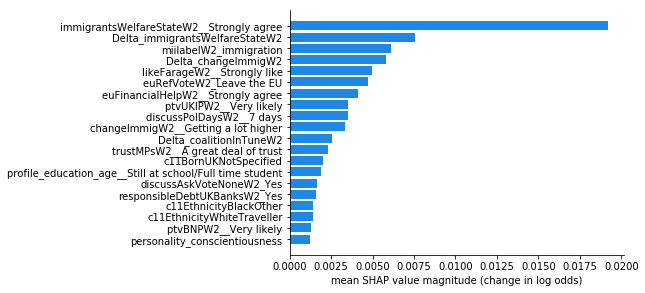

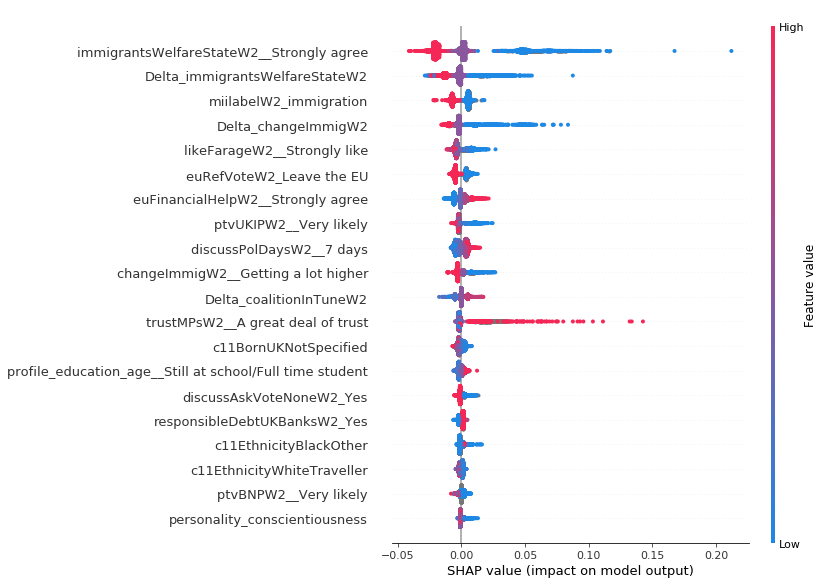

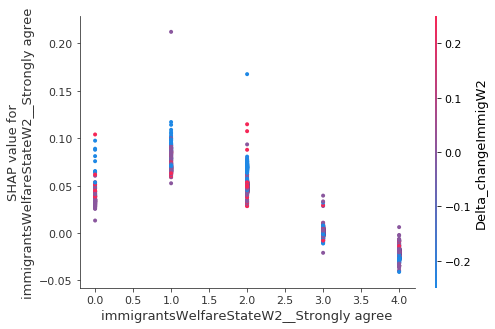

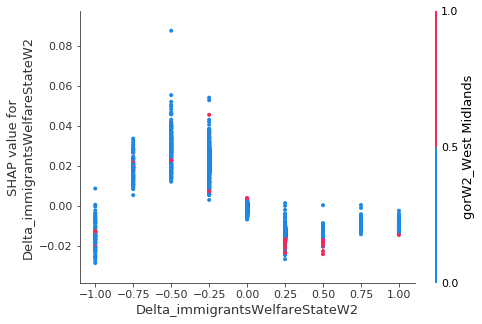

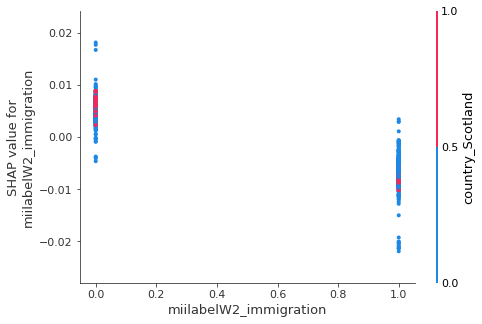

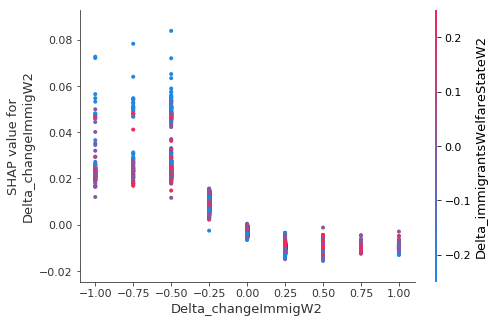

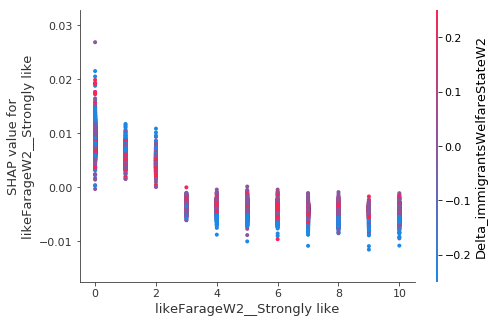

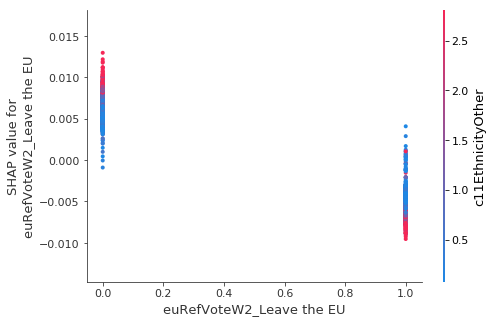

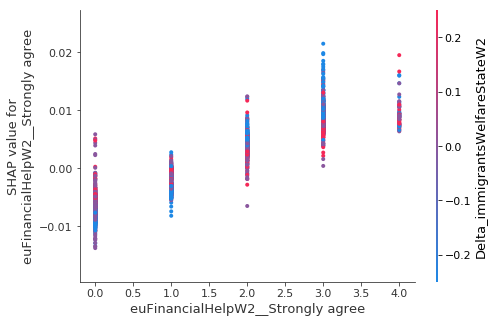

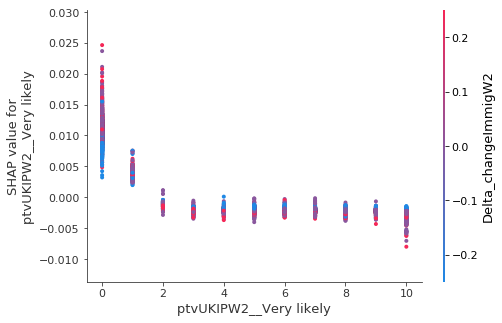

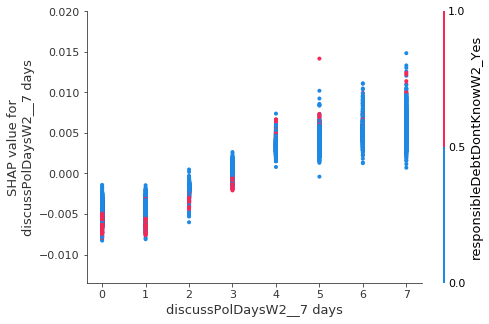

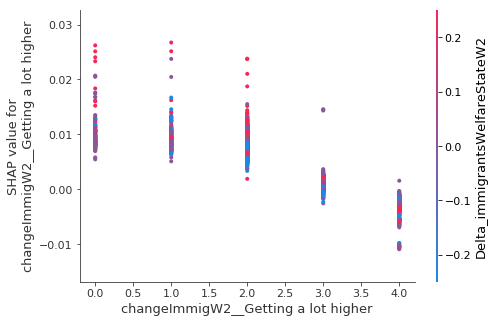

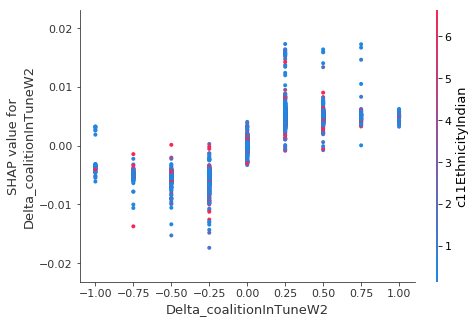

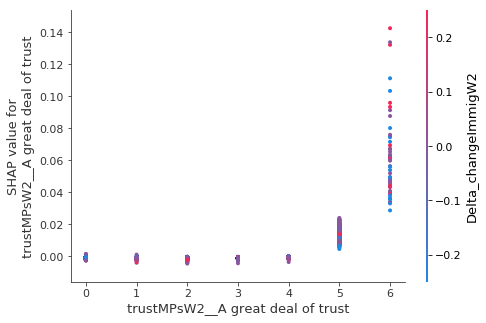

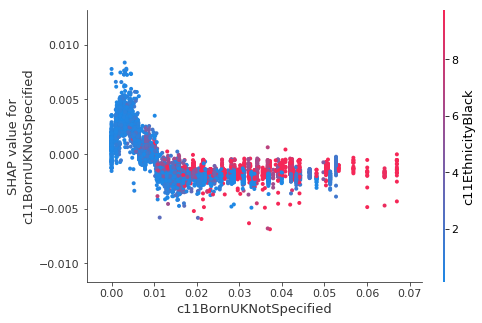

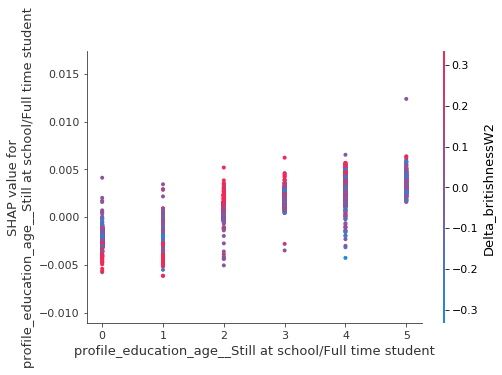

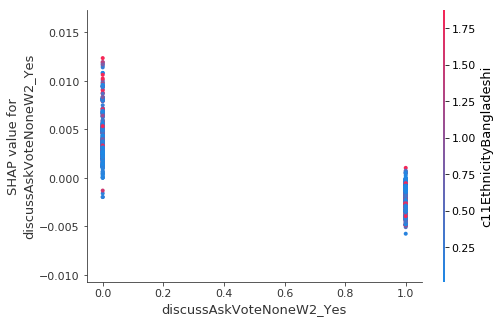

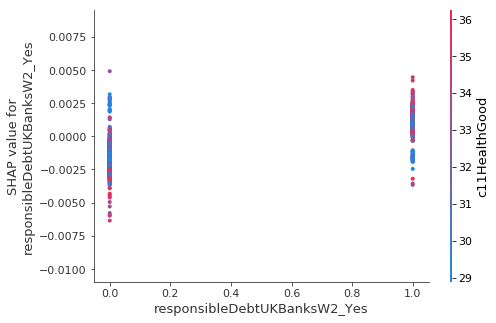

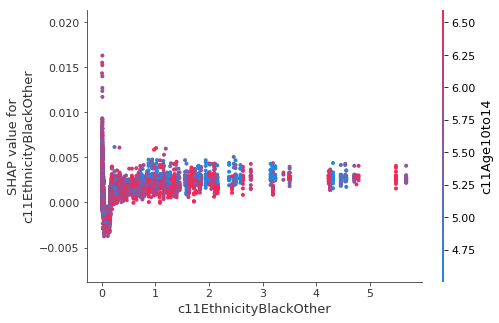

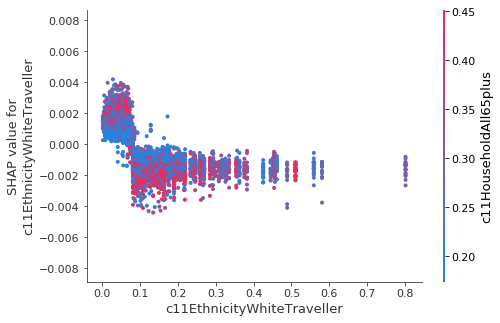

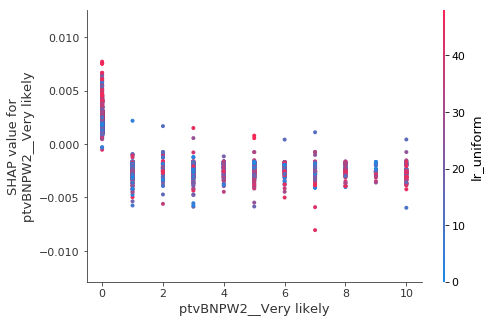

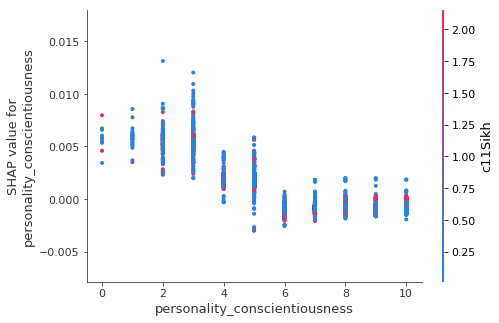

Delta_immigCult_plus_EcW3 3
missing vals in sample weights: 0
[0]	validation_0-rmse:0.503657
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.485476
[2]	validation_0-rmse:0.468095
[3]	validation_0-rmse:0.451449
[4]	validation_0-rmse:0.435606
[5]	validation_0-rmse:0.420458
[6]	validation_0-rmse:0.405875
[7]	validation_0-rmse:0.392007
[8]	validation_0-rmse:0.378875
[9]	validation_0-rmse:0.36643
[10]	validation_0-rmse:0.354446
[11]	validation_0-rmse:0.343138
[12]	validation_0-rmse:0.332284
[13]	validation_0-rmse:0.32198
[14]	validation_0-rmse:0.312185
[15]	validation_0-rmse:0.302827
[16]	validation_0-rmse:0.294083
[17]	validation_0-rmse:0.285609
[18]	validation_0-rmse:0.277641
[19]	validation_0-rmse:0.270061
[20]	validation_0-rmse:0.262921
[21]	validation_0-rmse:0.256209
[22]	validation_0-rmse:0.249773
[23]	validation_0-rmse:0.243758
[24]	validation_0-rmse:0.238077
[25]	validation_0-rmse:0.232765
[26]	validation_0-rmse:0.227669
[27]	validation_0-

[249]	validation_0-rmse:0.158192
[250]	validation_0-rmse:0.158187
[251]	validation_0-rmse:0.158203
[252]	validation_0-rmse:0.158202
[253]	validation_0-rmse:0.158213
[254]	validation_0-rmse:0.158231
[255]	validation_0-rmse:0.15824
[256]	validation_0-rmse:0.158263
[257]	validation_0-rmse:0.158276
[258]	validation_0-rmse:0.158264
[259]	validation_0-rmse:0.15826
[260]	validation_0-rmse:0.158262
[261]	validation_0-rmse:0.158255
[262]	validation_0-rmse:0.158266
[263]	validation_0-rmse:0.158267
[264]	validation_0-rmse:0.158257
[265]	validation_0-rmse:0.158264
[266]	validation_0-rmse:0.158271
[267]	validation_0-rmse:0.15828
[268]	validation_0-rmse:0.158292
[269]	validation_0-rmse:0.15832
[270]	validation_0-rmse:0.158313
[271]	validation_0-rmse:0.158316
[272]	validation_0-rmse:0.158325
[273]	validation_0-rmse:0.158321
[274]	validation_0-rmse:0.158316
[275]	validation_0-rmse:0.15832
[276]	validation_0-rmse:0.158319
[277]	validation_0-rmse:0.158315
[278]	validation_0-rmse:0.15831
[279]	validation

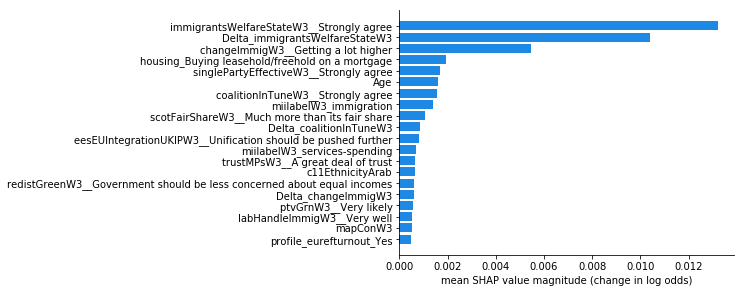

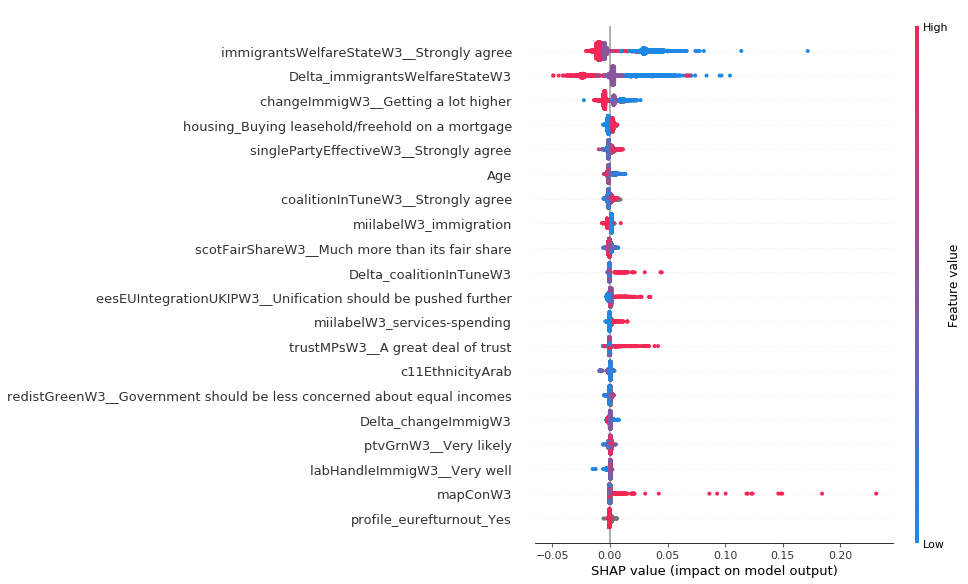

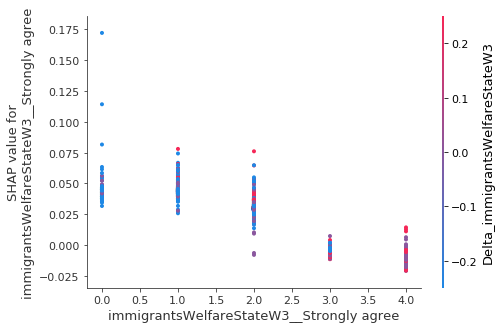

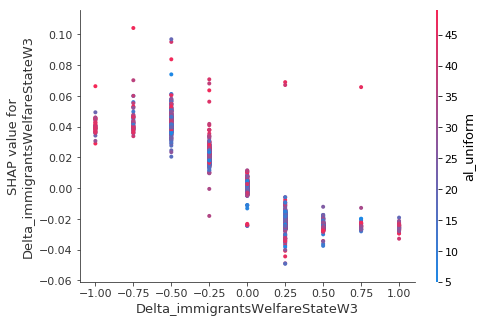

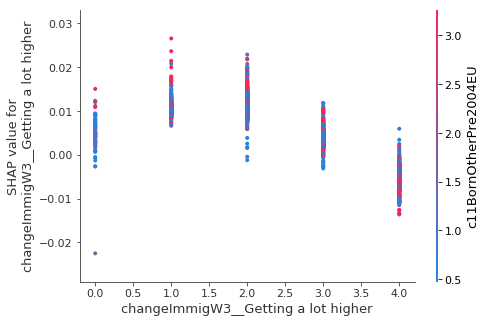

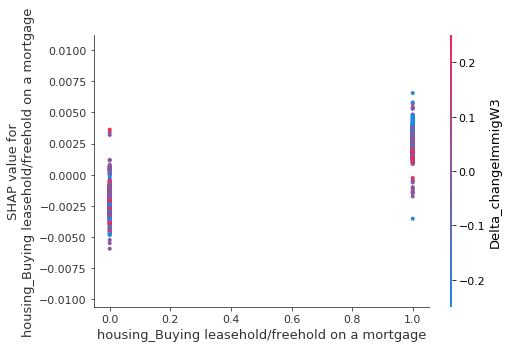

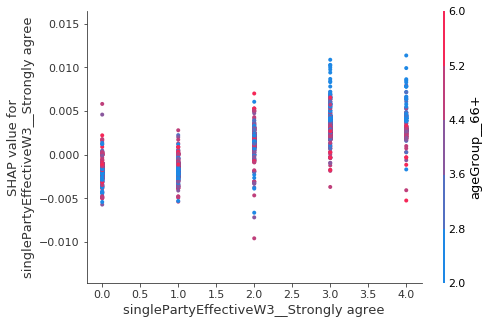

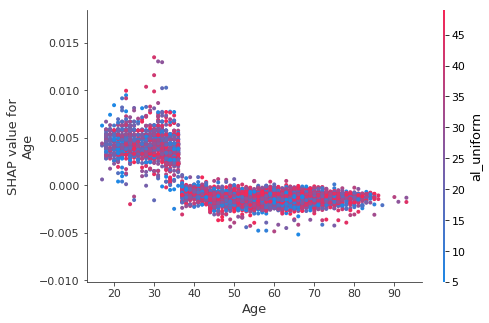

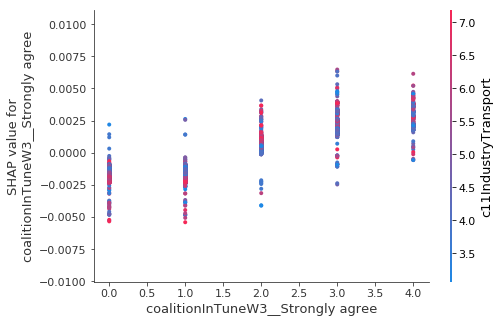

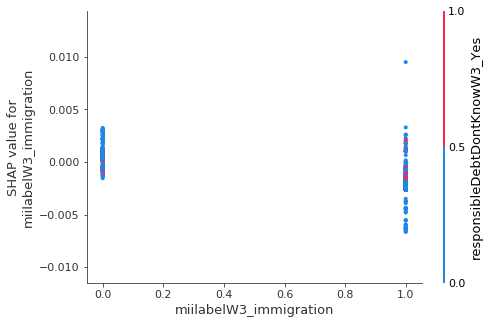

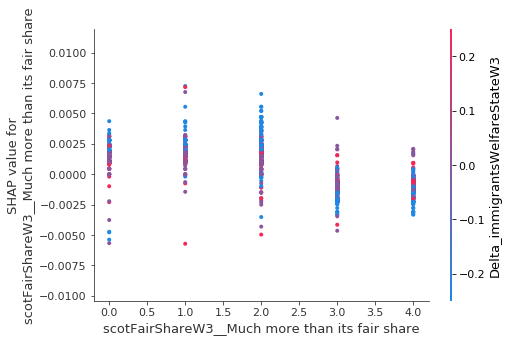

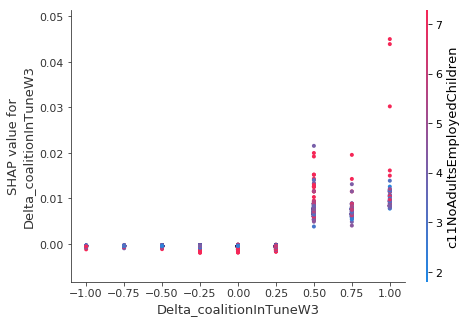

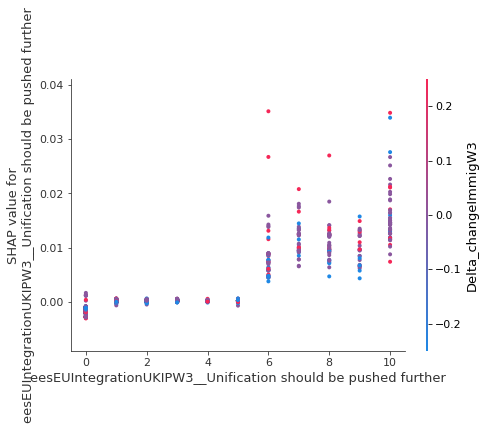

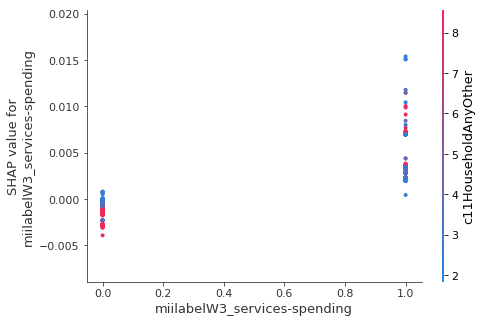

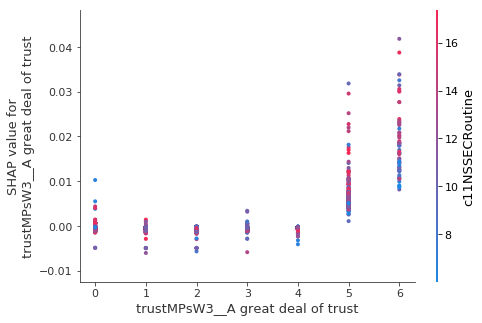

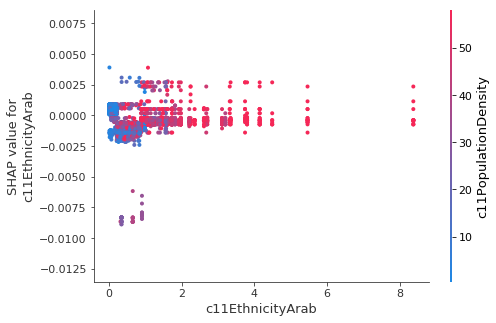

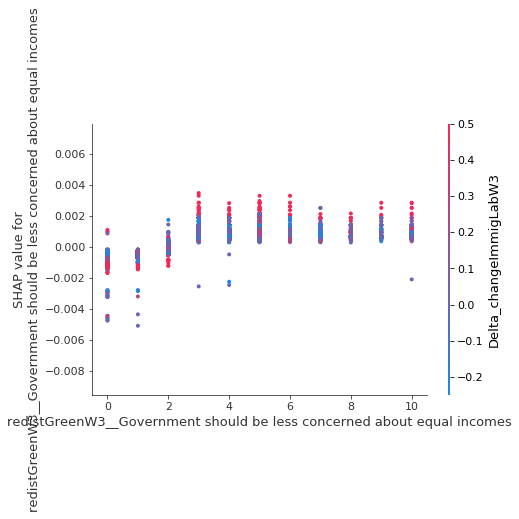

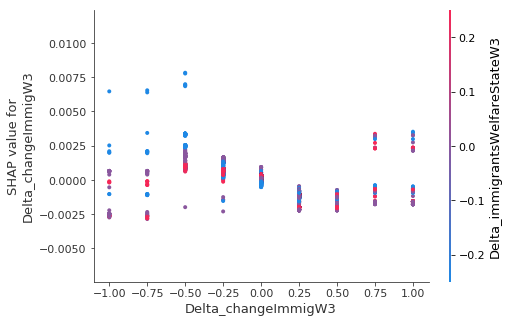

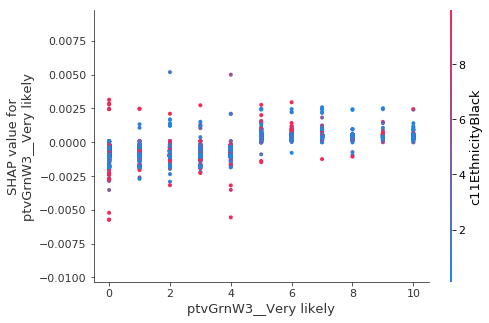

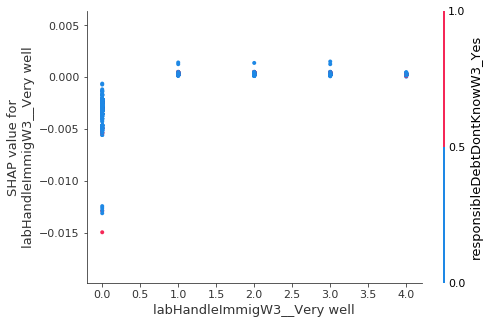

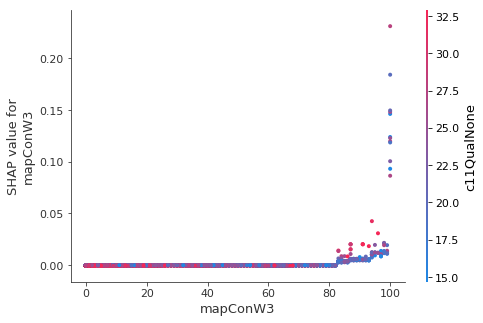

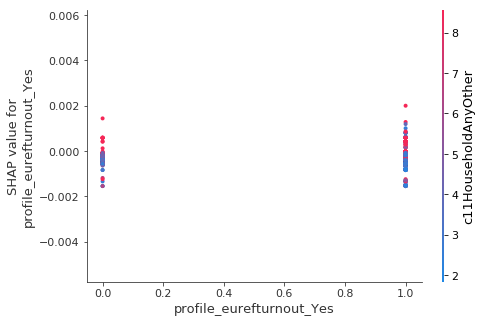

Delta_immigCult_plus_EcW4 4
missing vals in sample weights: 25
[0]	validation_0-rmse:0.427119
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.412699
[2]	validation_0-rmse:0.398938
[3]	validation_0-rmse:0.385736
[4]	validation_0-rmse:0.373248
[5]	validation_0-rmse:0.361389
[6]	validation_0-rmse:0.35001
[7]	validation_0-rmse:0.339233
[8]	validation_0-rmse:0.328936
[9]	validation_0-rmse:0.319119
[10]	validation_0-rmse:0.309734
[11]	validation_0-rmse:0.300908
[12]	validation_0-rmse:0.292611
[13]	validation_0-rmse:0.284725
[14]	validation_0-rmse:0.277257
[15]	validation_0-rmse:0.270066
[16]	validation_0-rmse:0.263272
[17]	validation_0-rmse:0.256919
[18]	validation_0-rmse:0.250815
[19]	validation_0-rmse:0.245151
[20]	validation_0-rmse:0.239691
[21]	validation_0-rmse:0.234679
[22]	validation_0-rmse:0.229935
[23]	validation_0-rmse:0.225497
[24]	validation_0-rmse:0.221197
[25]	validation_0-rmse:0.217219
[26]	validation_0-rmse:0.213458
[27]	validation_

[249]	validation_0-rmse:0.161061
[250]	validation_0-rmse:0.16109
[251]	validation_0-rmse:0.161088
[252]	validation_0-rmse:0.161098
[253]	validation_0-rmse:0.161095
[254]	validation_0-rmse:0.161105
[255]	validation_0-rmse:0.161096
[256]	validation_0-rmse:0.161096
[257]	validation_0-rmse:0.161082
[258]	validation_0-rmse:0.161074
[259]	validation_0-rmse:0.161053
[260]	validation_0-rmse:0.16104
[261]	validation_0-rmse:0.161037
[262]	validation_0-rmse:0.161033
[263]	validation_0-rmse:0.161064
[264]	validation_0-rmse:0.161065
[265]	validation_0-rmse:0.161072
[266]	validation_0-rmse:0.161083
[267]	validation_0-rmse:0.161088
[268]	validation_0-rmse:0.161073
[269]	validation_0-rmse:0.161105
[270]	validation_0-rmse:0.16108
[271]	validation_0-rmse:0.161085
[272]	validation_0-rmse:0.161082
[273]	validation_0-rmse:0.161092
[274]	validation_0-rmse:0.161119
[275]	validation_0-rmse:0.161117
[276]	validation_0-rmse:0.161126
[277]	validation_0-rmse:0.161167
[278]	validation_0-rmse:0.161161
[279]	validat

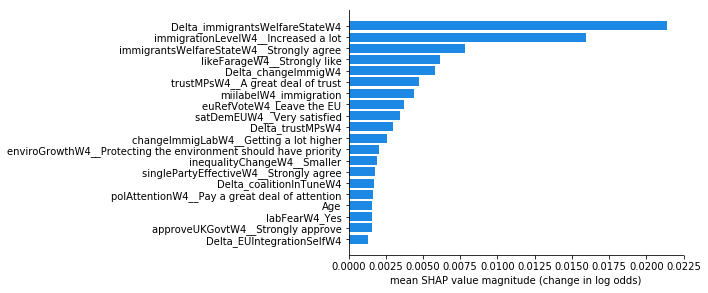

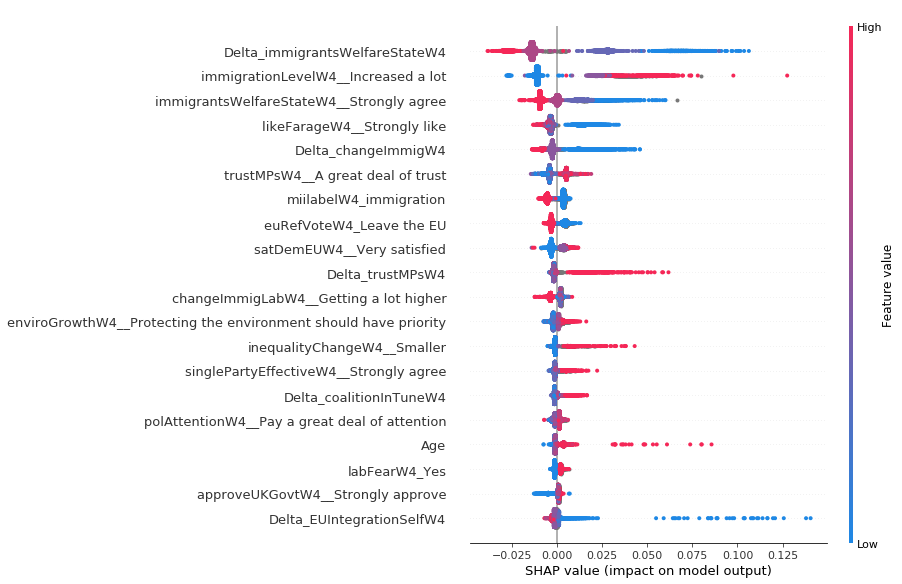

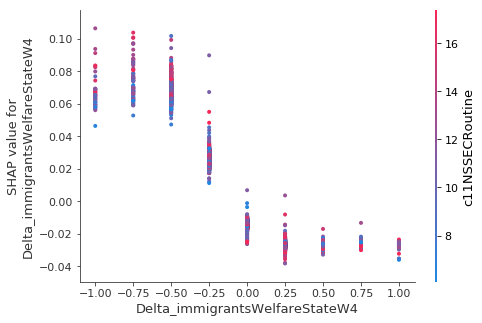

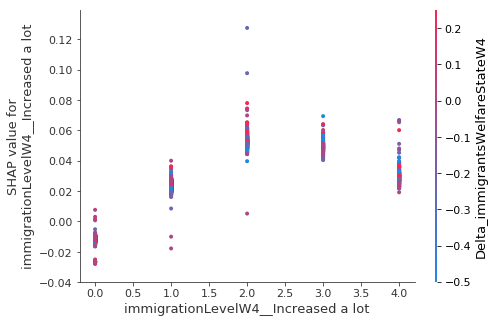

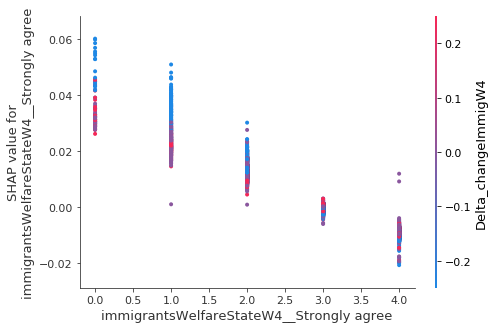

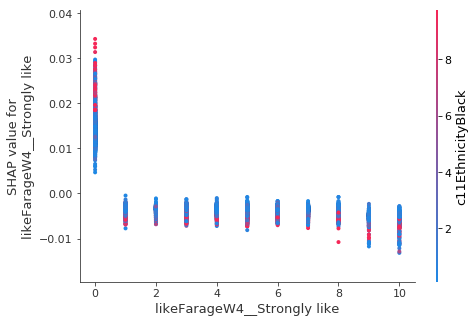

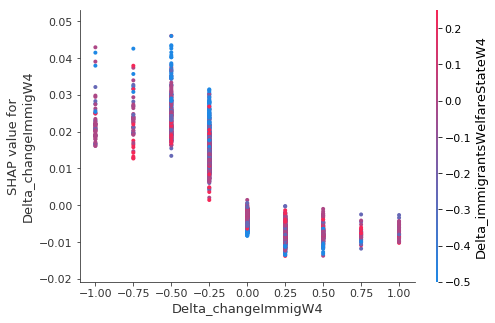

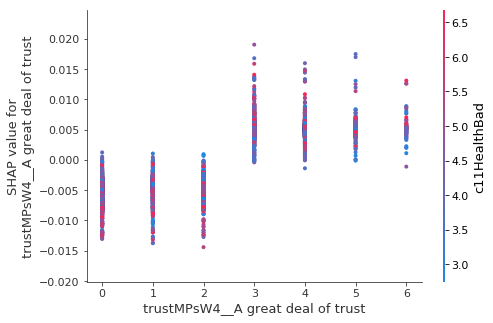

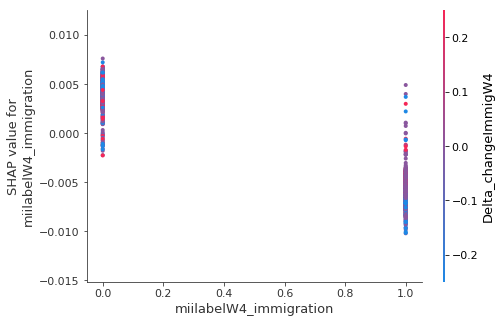

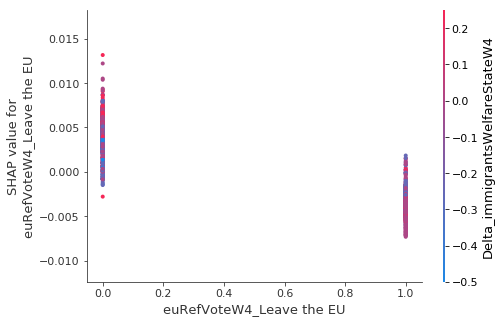

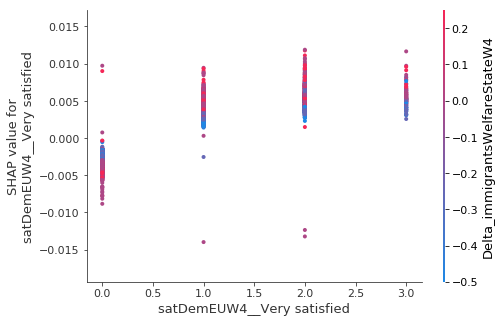

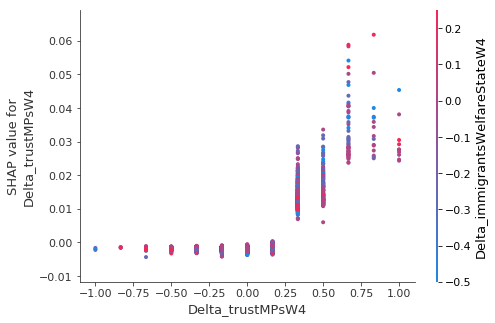

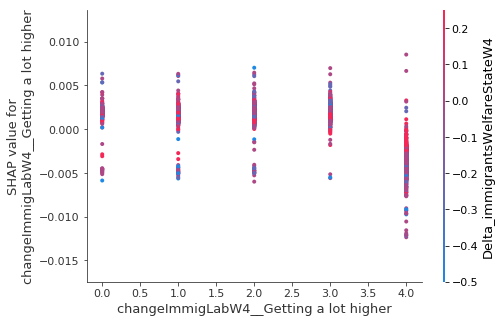

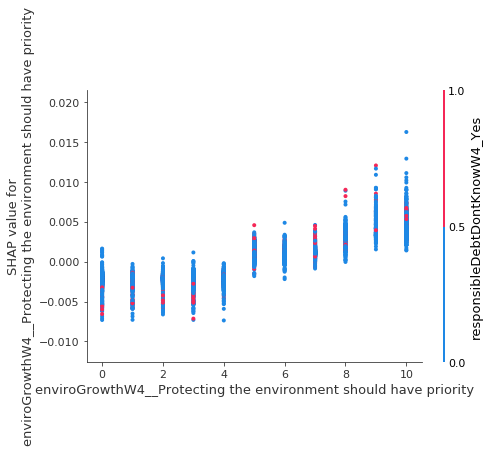

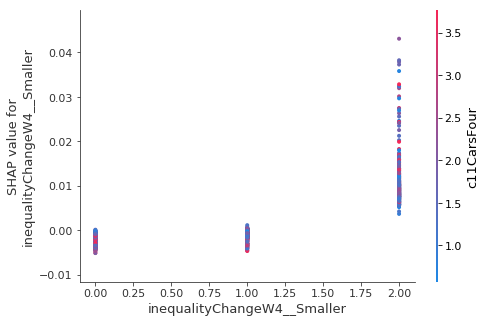

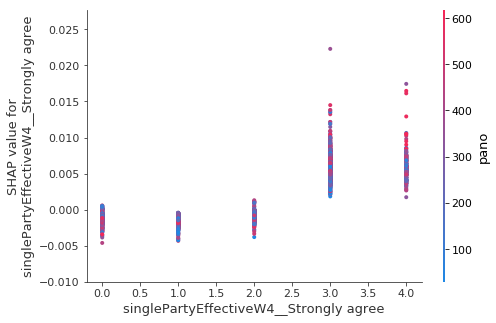

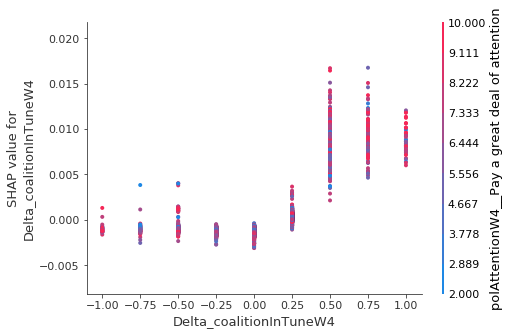

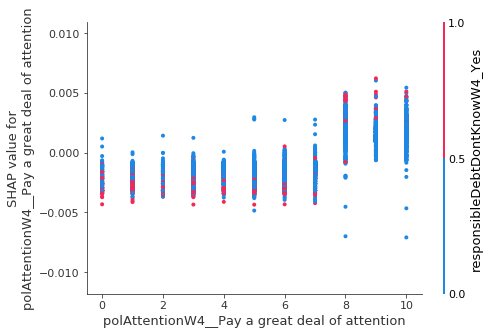

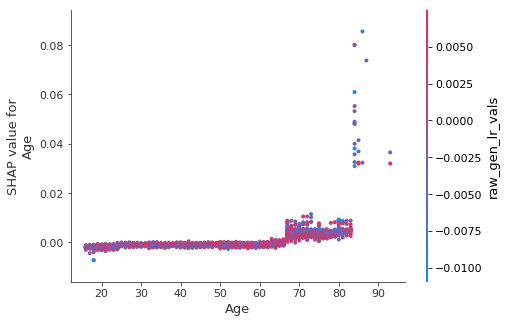

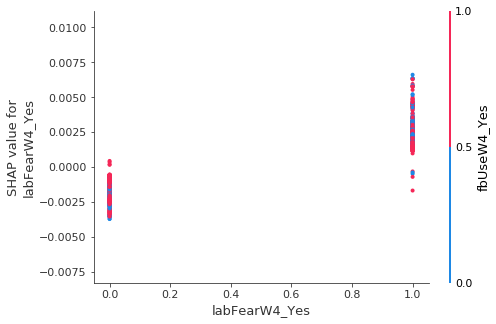

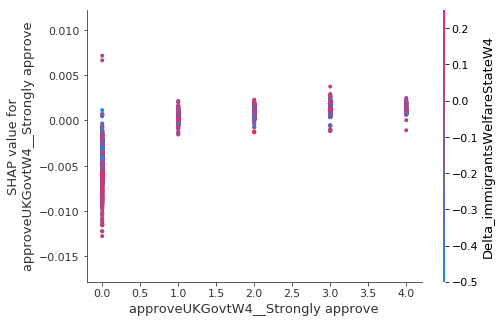

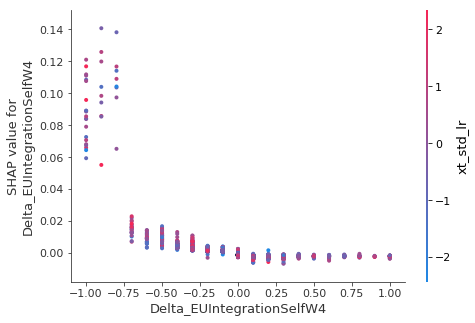

Delta_immigCult_plus_EcW7 7
missing vals in sample weights: 0
[0]	validation_0-rmse:0.48492
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.467718
[2]	validation_0-rmse:0.451339
[3]	validation_0-rmse:0.43564
[4]	validation_0-rmse:0.420613
[5]	validation_0-rmse:0.406406
[6]	validation_0-rmse:0.392977
[7]	validation_0-rmse:0.379978
[8]	validation_0-rmse:0.367651
[9]	validation_0-rmse:0.355928
[10]	validation_0-rmse:0.344811
[11]	validation_0-rmse:0.334113
[12]	validation_0-rmse:0.324091
[13]	validation_0-rmse:0.314486
[14]	validation_0-rmse:0.305324
[15]	validation_0-rmse:0.296711
[16]	validation_0-rmse:0.288527
[17]	validation_0-rmse:0.280735
[18]	validation_0-rmse:0.273432
[19]	validation_0-rmse:0.266535
[20]	validation_0-rmse:0.260001
[21]	validation_0-rmse:0.253762
[22]	validation_0-rmse:0.247876
[23]	validation_0-rmse:0.242307
[24]	validation_0-rmse:0.237147
[25]	validation_0-rmse:0.2323
[26]	validation_0-rmse:0.227658
[27]	validation_0-rm

[249]	validation_0-rmse:0.164846
[250]	validation_0-rmse:0.16486
[251]	validation_0-rmse:0.164852
[252]	validation_0-rmse:0.164866
[253]	validation_0-rmse:0.16487
[254]	validation_0-rmse:0.16486
[255]	validation_0-rmse:0.164844
[256]	validation_0-rmse:0.164857
[257]	validation_0-rmse:0.16485
[258]	validation_0-rmse:0.164858
[259]	validation_0-rmse:0.16485
[260]	validation_0-rmse:0.164864
[261]	validation_0-rmse:0.164878
[262]	validation_0-rmse:0.164893
[263]	validation_0-rmse:0.164897
[264]	validation_0-rmse:0.164923
[265]	validation_0-rmse:0.164919
[266]	validation_0-rmse:0.164937
[267]	validation_0-rmse:0.164921
[268]	validation_0-rmse:0.164898
[269]	validation_0-rmse:0.164882
[270]	validation_0-rmse:0.164909
[271]	validation_0-rmse:0.164926
[272]	validation_0-rmse:0.164917
[273]	validation_0-rmse:0.16491
[274]	validation_0-rmse:0.164918
[275]	validation_0-rmse:0.164906
[276]	validation_0-rmse:0.164908
[277]	validation_0-rmse:0.164901
[278]	validation_0-rmse:0.1649
[279]	validation_0

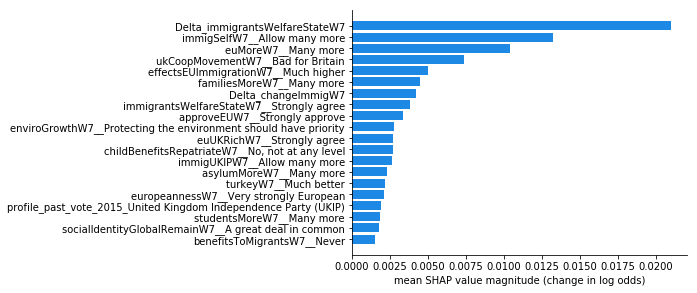

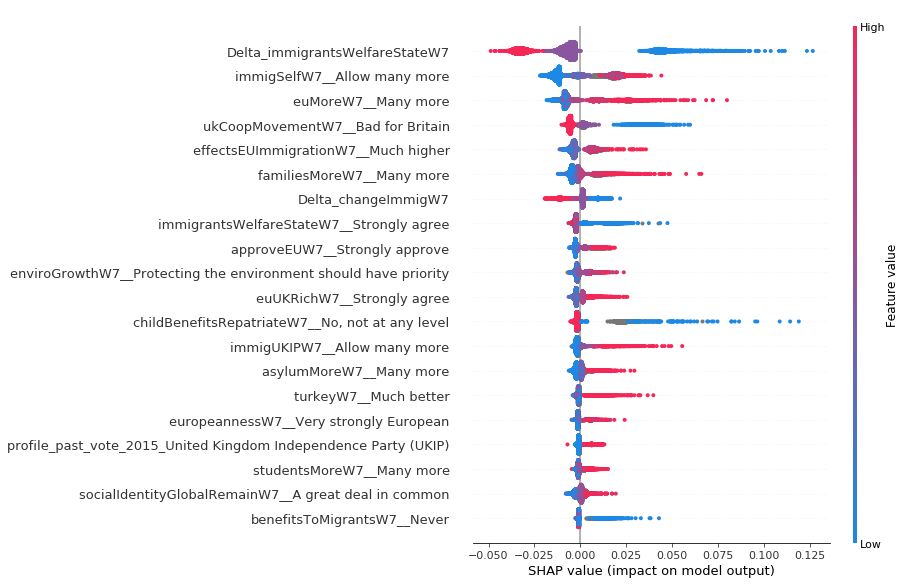

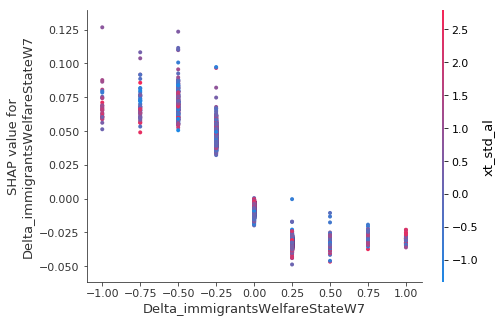

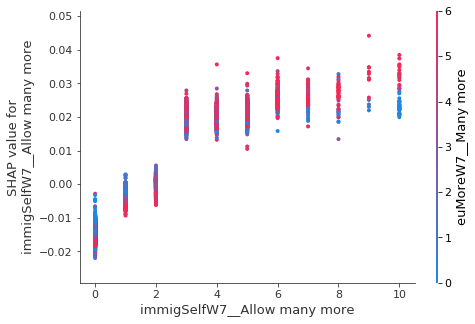

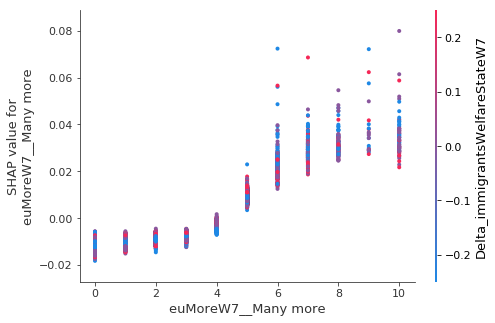

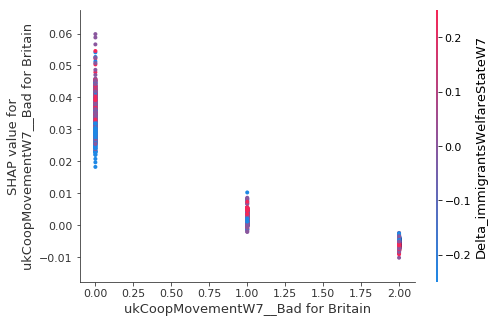

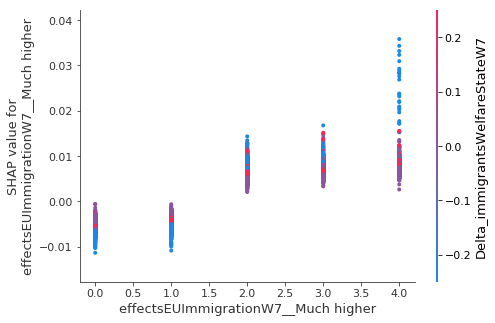

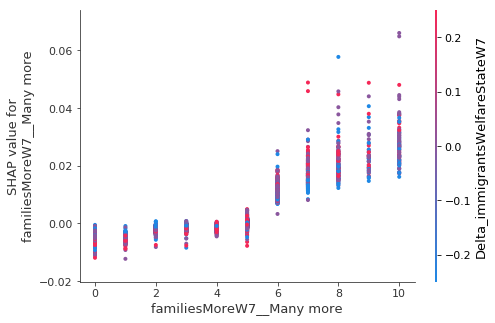

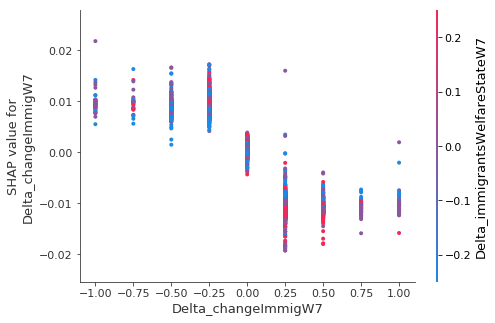

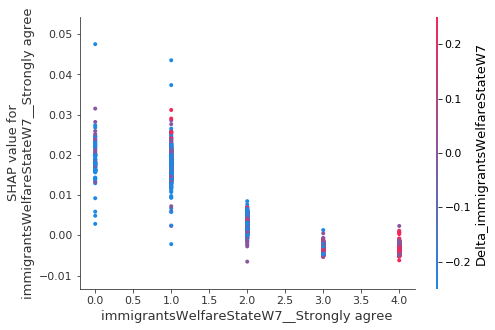

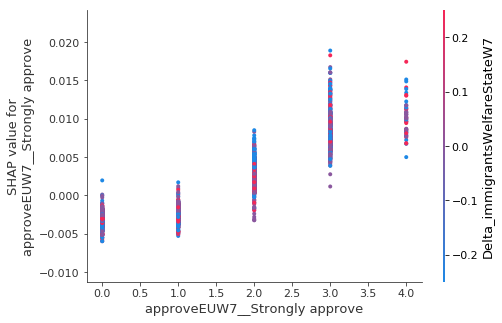

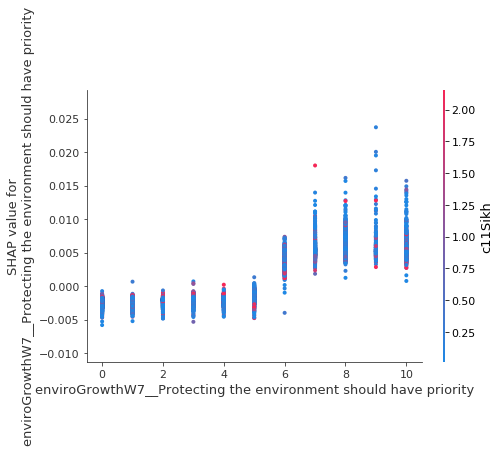

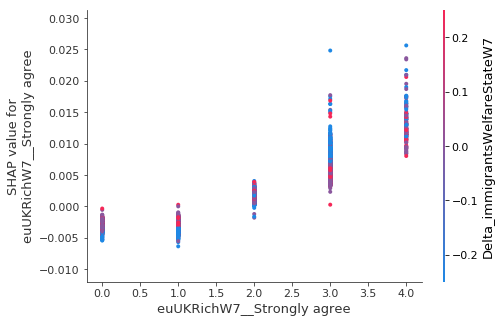

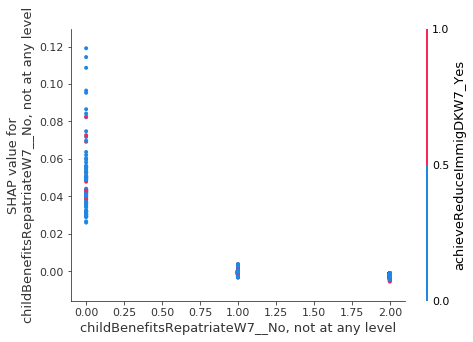

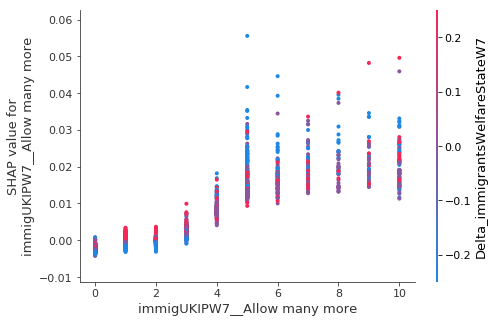

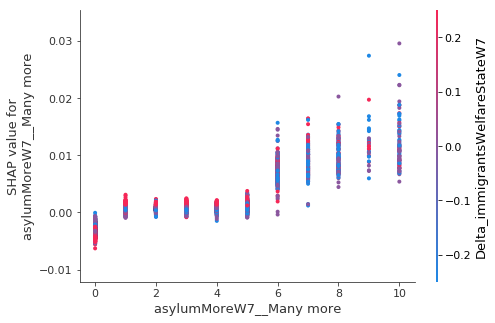

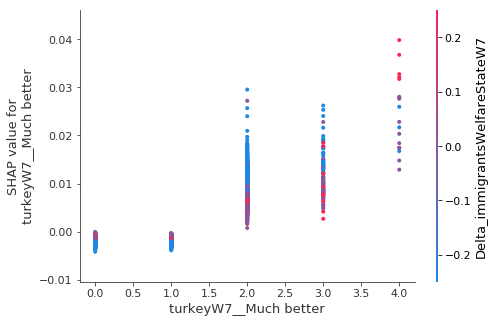

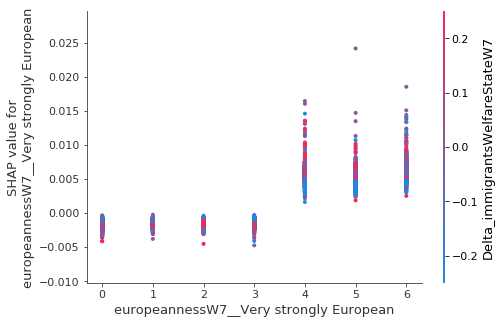

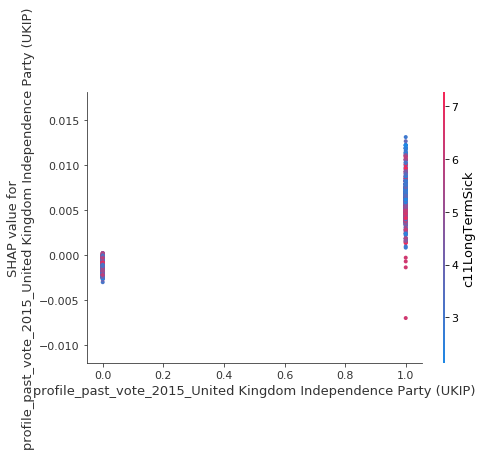

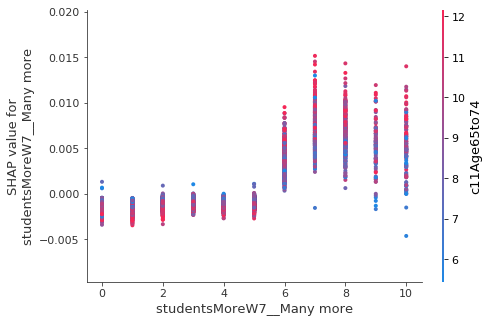

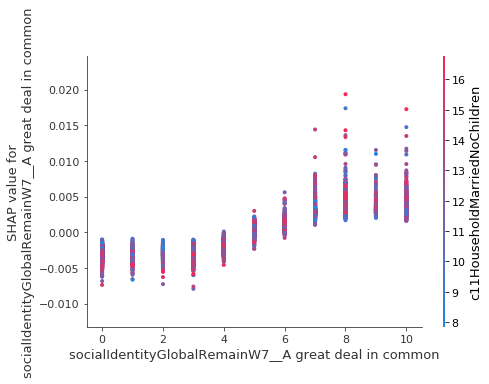

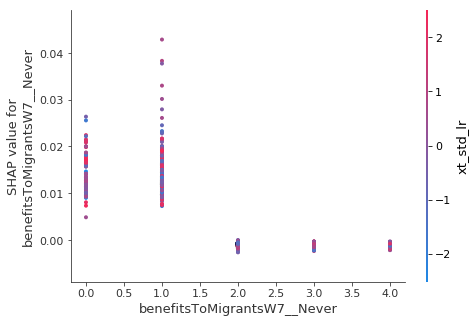

Delta_immigCult_plus_EcW8 8
missing vals in sample weights: 0
[0]	validation_0-rmse:0.470925
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.454323
[2]	validation_0-rmse:0.438411
[3]	validation_0-rmse:0.423155
[4]	validation_0-rmse:0.408509
[5]	validation_0-rmse:0.394614
[6]	validation_0-rmse:0.381309
[7]	validation_0-rmse:0.368631
[8]	validation_0-rmse:0.356504
[9]	validation_0-rmse:0.344989
[10]	validation_0-rmse:0.334133
[11]	validation_0-rmse:0.323711
[12]	validation_0-rmse:0.313675
[13]	validation_0-rmse:0.304181
[14]	validation_0-rmse:0.295332
[15]	validation_0-rmse:0.286855
[16]	validation_0-rmse:0.278834
[17]	validation_0-rmse:0.271167
[18]	validation_0-rmse:0.263821
[19]	validation_0-rmse:0.256985
[20]	validation_0-rmse:0.25044
[21]	validation_0-rmse:0.244275
[22]	validation_0-rmse:0.238447
[23]	validation_0-rmse:0.233041
[24]	validation_0-rmse:0.227872
[25]	validation_0-rmse:0.22293
[26]	validation_0-rmse:0.218314
[27]	validation_0-

[249]	validation_0-rmse:0.152146
[250]	validation_0-rmse:0.152131
[251]	validation_0-rmse:0.15214
[252]	validation_0-rmse:0.152141
[253]	validation_0-rmse:0.152157
[254]	validation_0-rmse:0.152145
[255]	validation_0-rmse:0.152138
[256]	validation_0-rmse:0.152154
[257]	validation_0-rmse:0.152136
[258]	validation_0-rmse:0.152142
[259]	validation_0-rmse:0.152153
[260]	validation_0-rmse:0.152147
[261]	validation_0-rmse:0.152139
[262]	validation_0-rmse:0.152133
[263]	validation_0-rmse:0.152125
[264]	validation_0-rmse:0.152125
[265]	validation_0-rmse:0.152143
[266]	validation_0-rmse:0.152153
[267]	validation_0-rmse:0.152137
[268]	validation_0-rmse:0.152135
[269]	validation_0-rmse:0.152126
[270]	validation_0-rmse:0.152114
[271]	validation_0-rmse:0.152121
[272]	validation_0-rmse:0.15213
[273]	validation_0-rmse:0.15214
[274]	validation_0-rmse:0.15215
[275]	validation_0-rmse:0.152151
[276]	validation_0-rmse:0.152166
[277]	validation_0-rmse:0.152162
[278]	validation_0-rmse:0.152163
[279]	validati

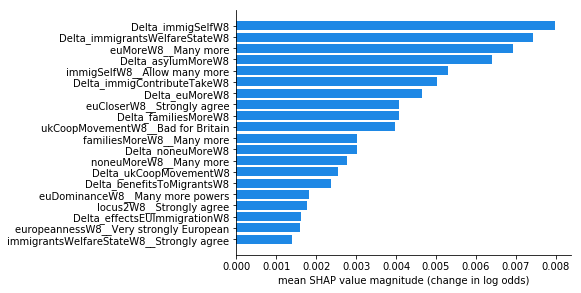

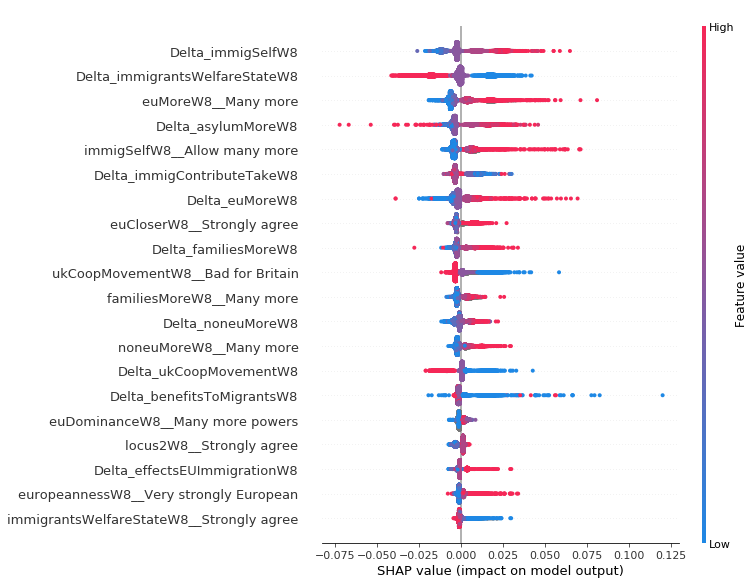

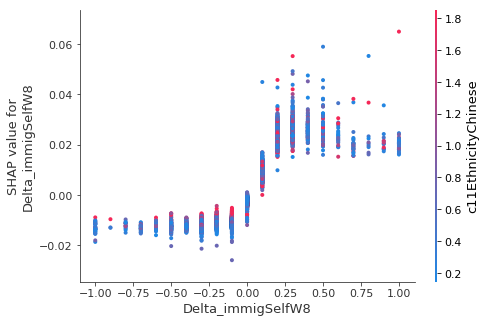

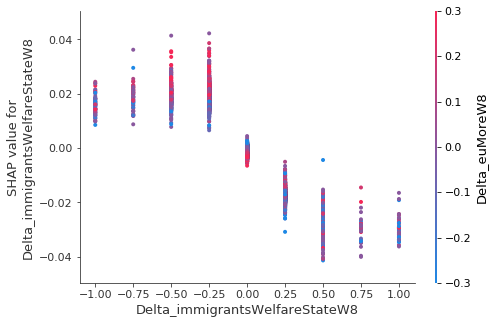

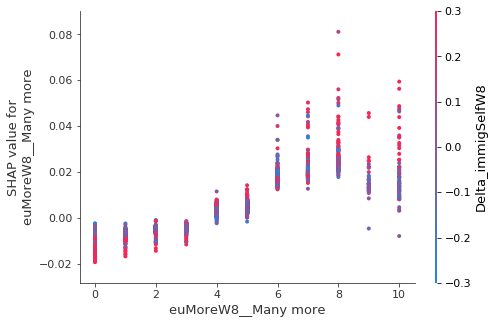

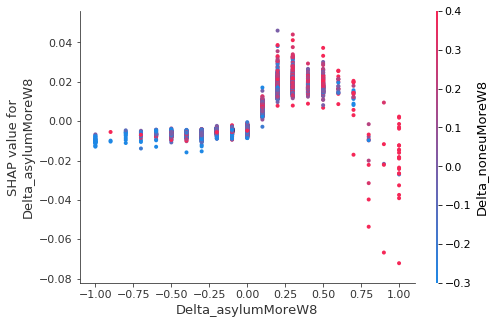

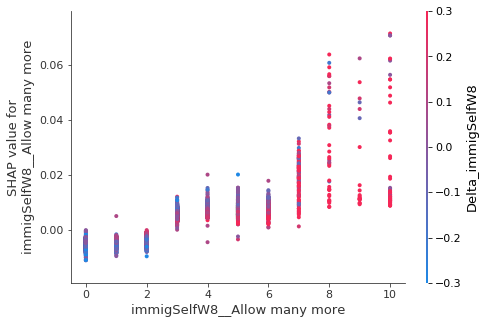

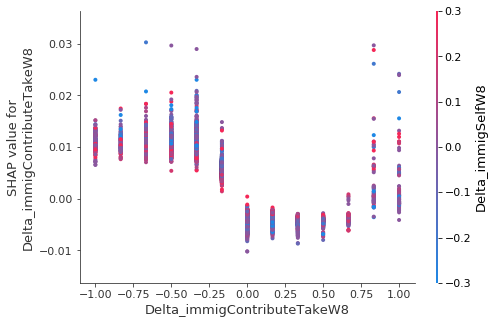

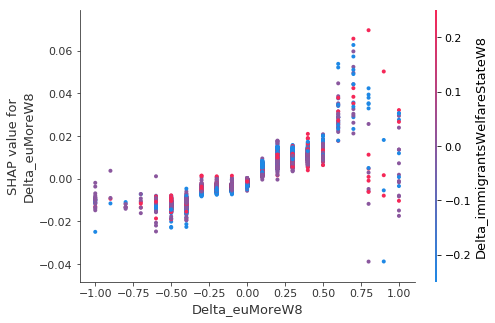

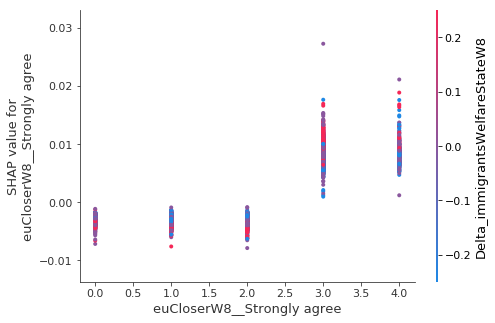

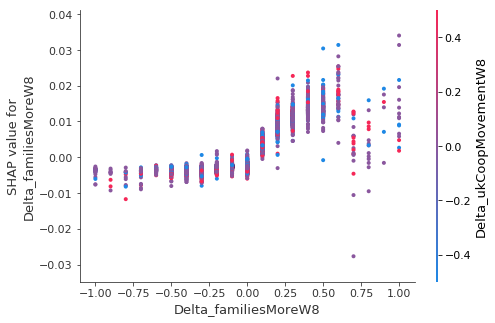

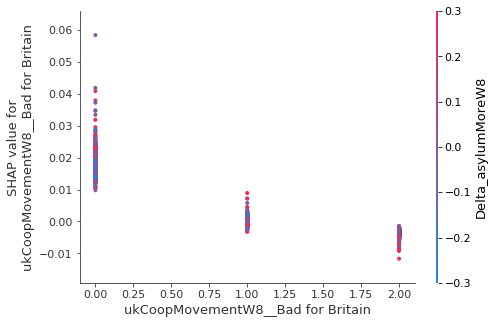

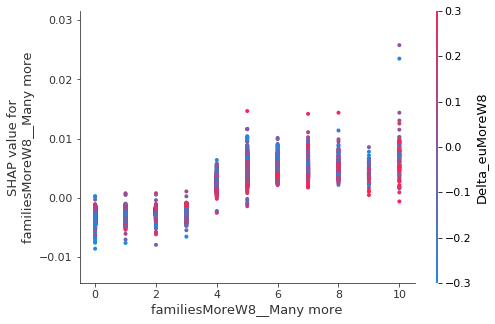

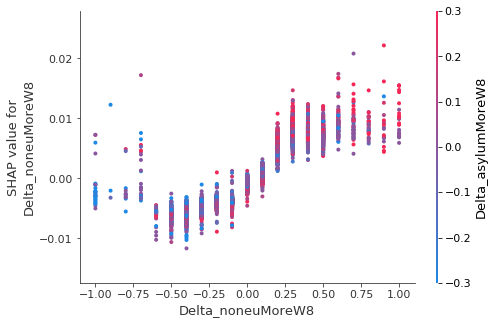

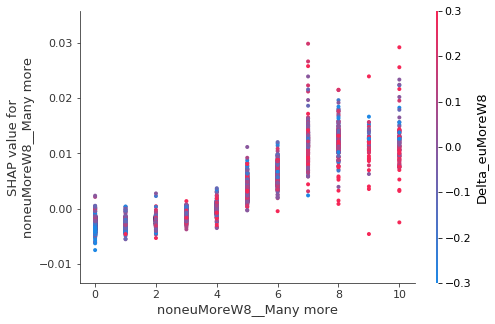

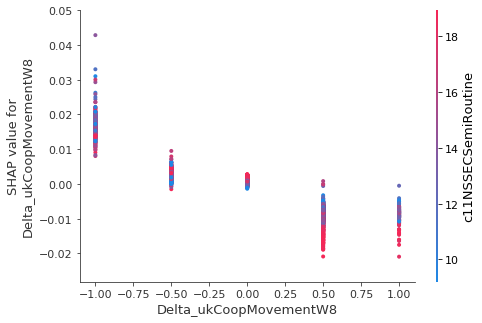

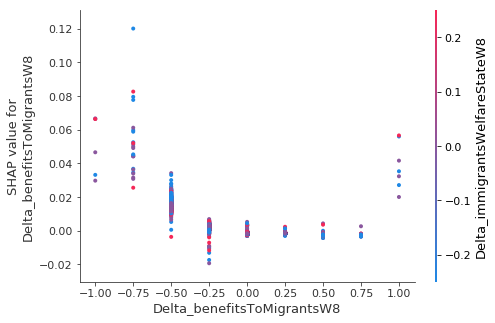

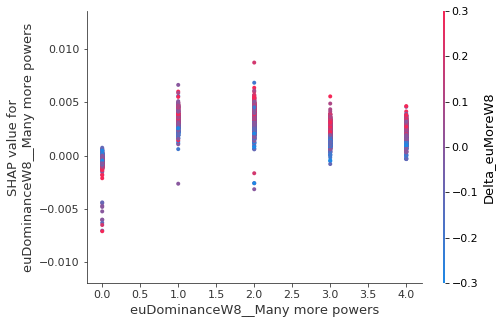

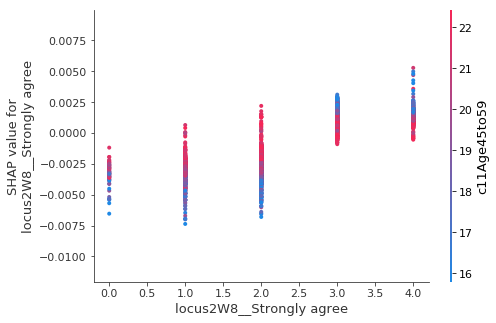

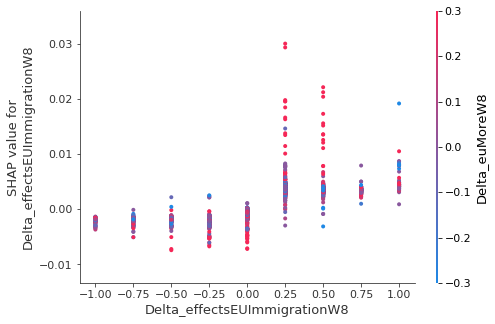

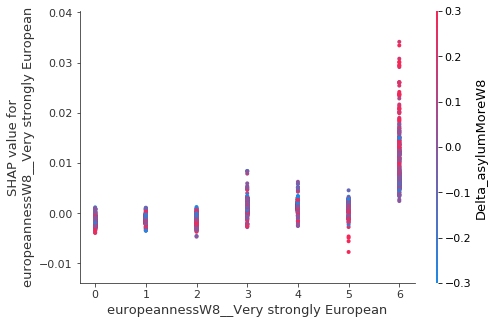

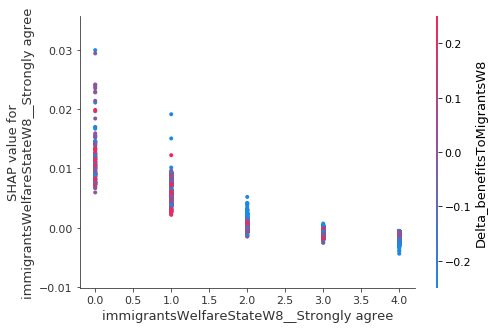

Delta_immigCult_plus_EcW10 10
missing vals in sample weights: 0
[0]	validation_0-rmse:0.431742
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.417448
[2]	validation_0-rmse:0.403971
[3]	validation_0-rmse:0.391076
[4]	validation_0-rmse:0.378714
[5]	validation_0-rmse:0.367108
[6]	validation_0-rmse:0.356044
[7]	validation_0-rmse:0.345482
[8]	validation_0-rmse:0.335465
[9]	validation_0-rmse:0.326013
[10]	validation_0-rmse:0.316961
[11]	validation_0-rmse:0.308351
[12]	validation_0-rmse:0.300191
[13]	validation_0-rmse:0.292518
[14]	validation_0-rmse:0.28522
[15]	validation_0-rmse:0.278328
[16]	validation_0-rmse:0.271801
[17]	validation_0-rmse:0.265777
[18]	validation_0-rmse:0.260061
[19]	validation_0-rmse:0.254549
[20]	validation_0-rmse:0.249528
[21]	validation_0-rmse:0.244677
[22]	validation_0-rmse:0.240243
[23]	validation_0-rmse:0.236029
[24]	validation_0-rmse:0.231969
[25]	validation_0-rmse:0.228218
[26]	validation_0-rmse:0.224794
[27]	validation

[249]	validation_0-rmse:0.176265
[250]	validation_0-rmse:0.176264
[251]	validation_0-rmse:0.176257
[252]	validation_0-rmse:0.176249
[253]	validation_0-rmse:0.176261
[254]	validation_0-rmse:0.176267
[255]	validation_0-rmse:0.176281
[256]	validation_0-rmse:0.176269
[257]	validation_0-rmse:0.176213
[258]	validation_0-rmse:0.176203
[259]	validation_0-rmse:0.176212
[260]	validation_0-rmse:0.176198
[261]	validation_0-rmse:0.176215
[262]	validation_0-rmse:0.176193
[263]	validation_0-rmse:0.176164
[264]	validation_0-rmse:0.176145
[265]	validation_0-rmse:0.176147
[266]	validation_0-rmse:0.176165
[267]	validation_0-rmse:0.176194
[268]	validation_0-rmse:0.176173
[269]	validation_0-rmse:0.176145
[270]	validation_0-rmse:0.176118
[271]	validation_0-rmse:0.176116
[272]	validation_0-rmse:0.176108
[273]	validation_0-rmse:0.176136
[274]	validation_0-rmse:0.176137
[275]	validation_0-rmse:0.176128
[276]	validation_0-rmse:0.176132
[277]	validation_0-rmse:0.17615
[278]	validation_0-rmse:0.176136
[279]	valid

[499]	validation_0-rmse:0.17665
[500]	validation_0-rmse:0.176644
[501]	validation_0-rmse:0.17664
[502]	validation_0-rmse:0.176636
[503]	validation_0-rmse:0.17664
[504]	validation_0-rmse:0.176631
[505]	validation_0-rmse:0.176635
[506]	validation_0-rmse:0.176638
[507]	validation_0-rmse:0.176625
[508]	validation_0-rmse:0.176607
[509]	validation_0-rmse:0.176614
[510]	validation_0-rmse:0.176602
[511]	validation_0-rmse:0.176615
[512]	validation_0-rmse:0.176603
[513]	validation_0-rmse:0.176594
[514]	validation_0-rmse:0.176613
[515]	validation_0-rmse:0.176605
[516]	validation_0-rmse:0.176613
[517]	validation_0-rmse:0.176623
[518]	validation_0-rmse:0.176638
[519]	validation_0-rmse:0.176635
[520]	validation_0-rmse:0.176622
[521]	validation_0-rmse:0.176621
[522]	validation_0-rmse:0.176608
[523]	validation_0-rmse:0.176617
[524]	validation_0-rmse:0.176628
[525]	validation_0-rmse:0.176633
[526]	validation_0-rmse:0.176644
[527]	validation_0-rmse:0.176639
[528]	validation_0-rmse:0.176651
[529]	validat

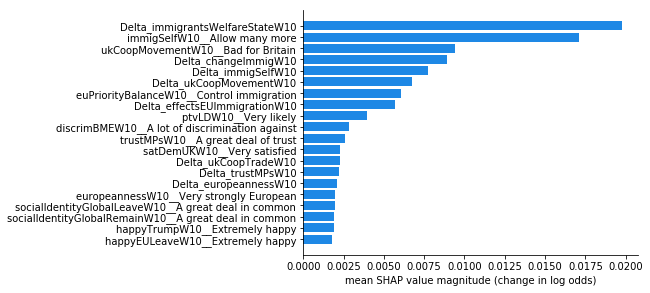

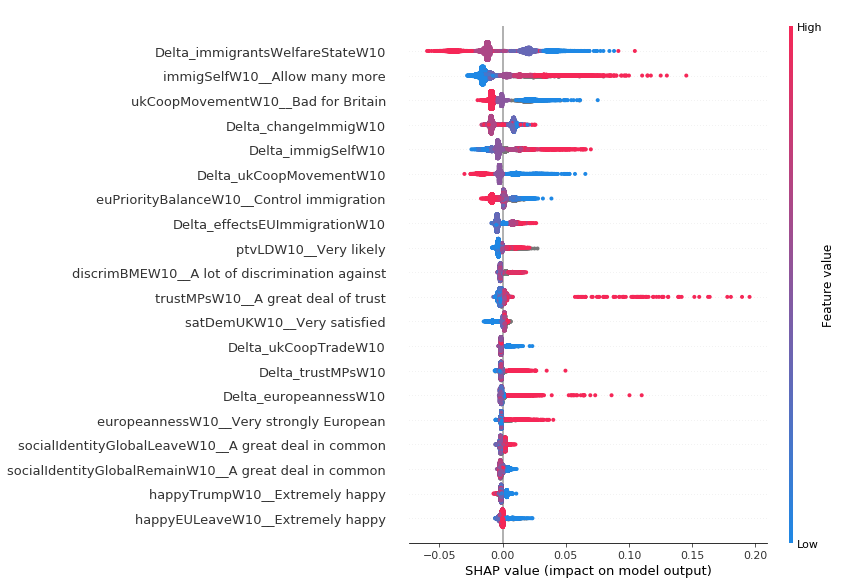

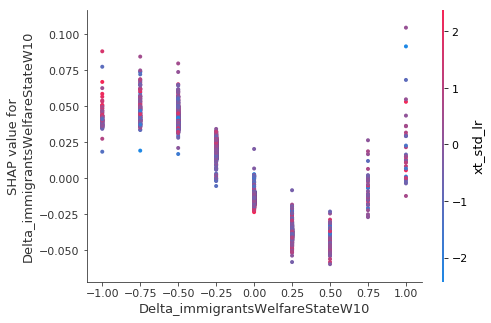

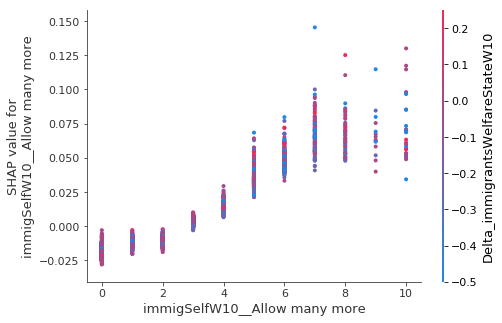

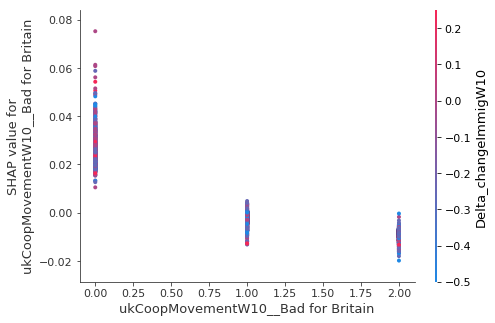

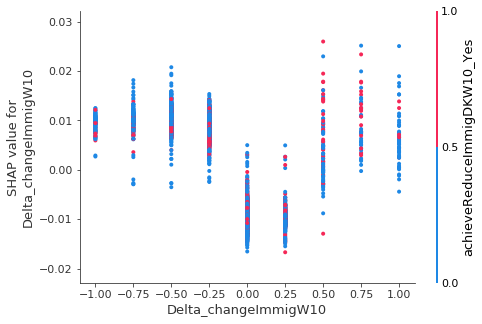

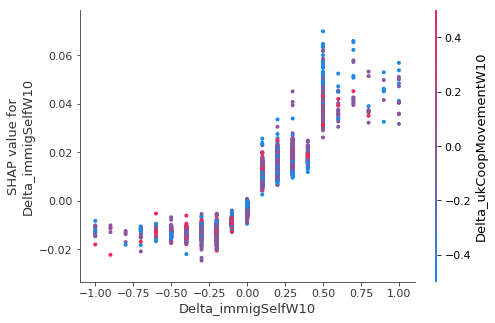

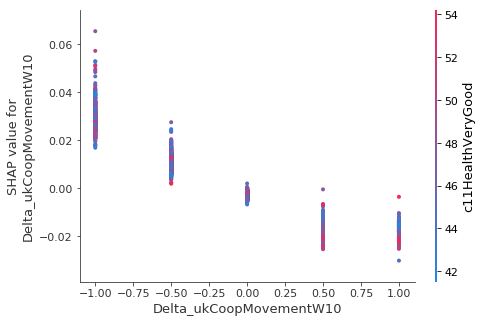

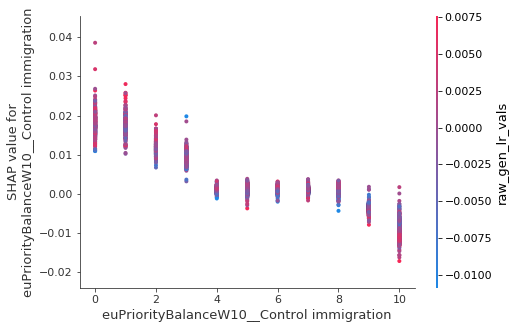

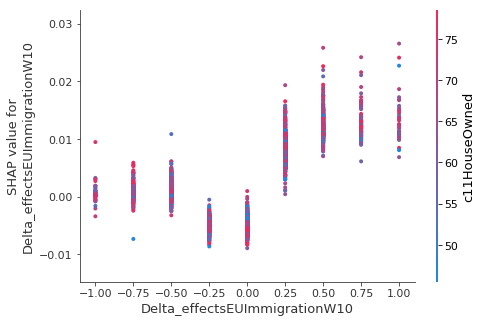

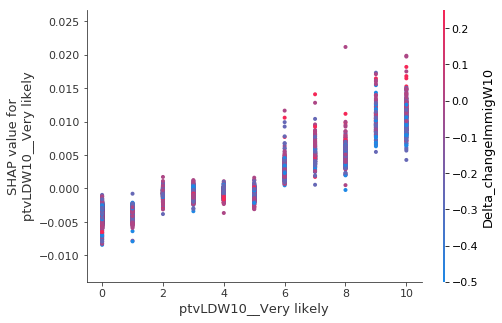

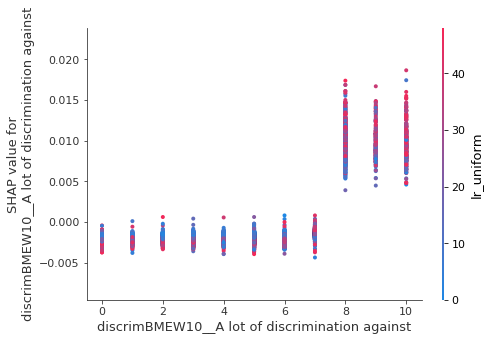

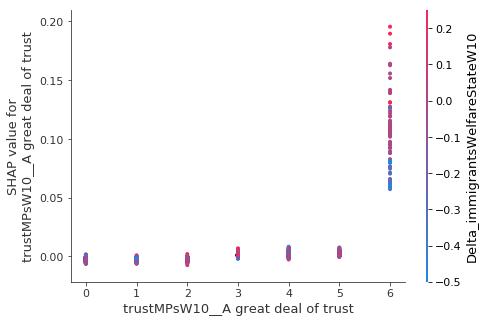

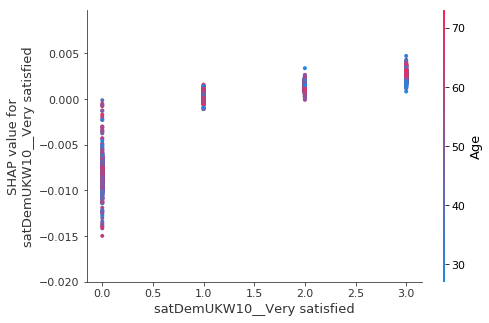

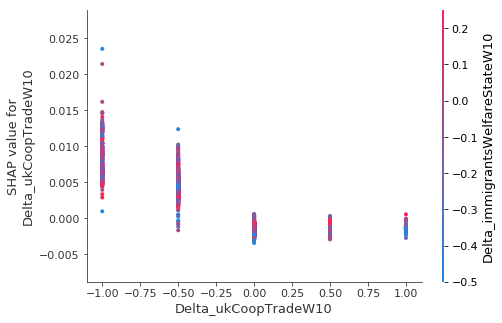

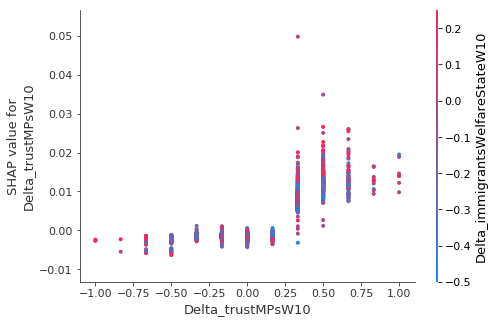

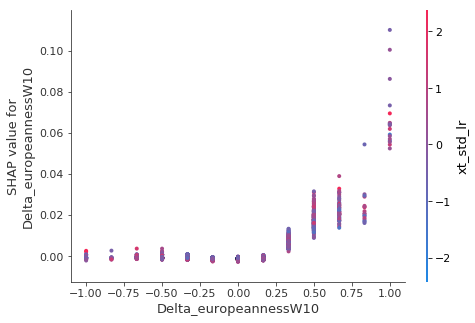

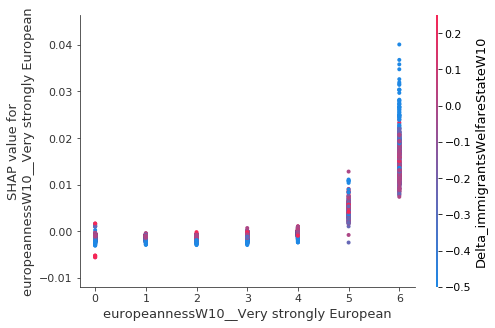

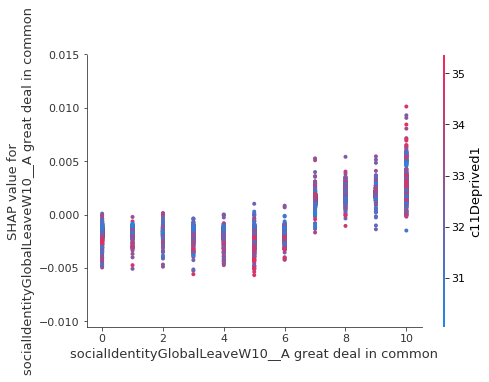

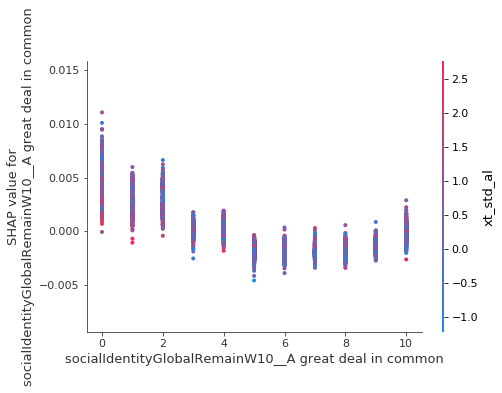

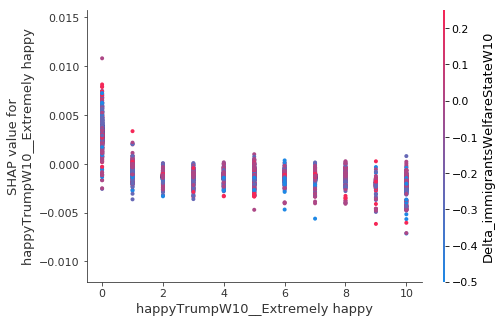

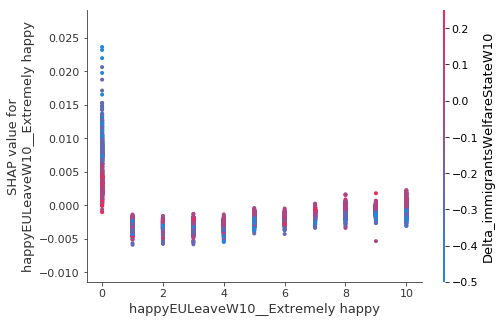

Delta_immigCult_plus_EcW11 11
missing vals in sample weights: 0
[0]	validation_0-rmse:0.44683
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.431449
[2]	validation_0-rmse:0.416664
[3]	validation_0-rmse:0.402728
[4]	validation_0-rmse:0.38945
[5]	validation_0-rmse:0.376767
[6]	validation_0-rmse:0.364829
[7]	validation_0-rmse:0.353432
[8]	validation_0-rmse:0.342525
[9]	validation_0-rmse:0.332217
[10]	validation_0-rmse:0.32231
[11]	validation_0-rmse:0.313026
[12]	validation_0-rmse:0.304307
[13]	validation_0-rmse:0.29579
[14]	validation_0-rmse:0.287807
[15]	validation_0-rmse:0.280243
[16]	validation_0-rmse:0.2731
[17]	validation_0-rmse:0.266307
[18]	validation_0-rmse:0.259971
[19]	validation_0-rmse:0.253926
[20]	validation_0-rmse:0.248239
[21]	validation_0-rmse:0.242963
[22]	validation_0-rmse:0.237908
[23]	validation_0-rmse:0.23311
[24]	validation_0-rmse:0.228707
[25]	validation_0-rmse:0.224521
[26]	validation_0-rmse:0.22058
[27]	validation_0-rmse

[249]	validation_0-rmse:0.168468
[250]	validation_0-rmse:0.168458
[251]	validation_0-rmse:0.168477
[252]	validation_0-rmse:0.168496
[253]	validation_0-rmse:0.168499
[254]	validation_0-rmse:0.168522
[255]	validation_0-rmse:0.168486
[256]	validation_0-rmse:0.168507
[257]	validation_0-rmse:0.168512
[258]	validation_0-rmse:0.168549
[259]	validation_0-rmse:0.168533
[260]	validation_0-rmse:0.168535
[261]	validation_0-rmse:0.168519
[262]	validation_0-rmse:0.168532
[263]	validation_0-rmse:0.168532
[264]	validation_0-rmse:0.168527
[265]	validation_0-rmse:0.168523
[266]	validation_0-rmse:0.168545
[267]	validation_0-rmse:0.168546
[268]	validation_0-rmse:0.168561
[269]	validation_0-rmse:0.168568
[270]	validation_0-rmse:0.168571
[271]	validation_0-rmse:0.168571
[272]	validation_0-rmse:0.168582
[273]	validation_0-rmse:0.168593
[274]	validation_0-rmse:0.168594
[275]	validation_0-rmse:0.168587
[276]	validation_0-rmse:0.168602
[277]	validation_0-rmse:0.16859
[278]	validation_0-rmse:0.168571
[279]	valid

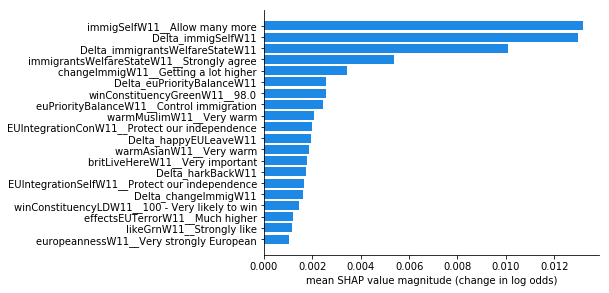

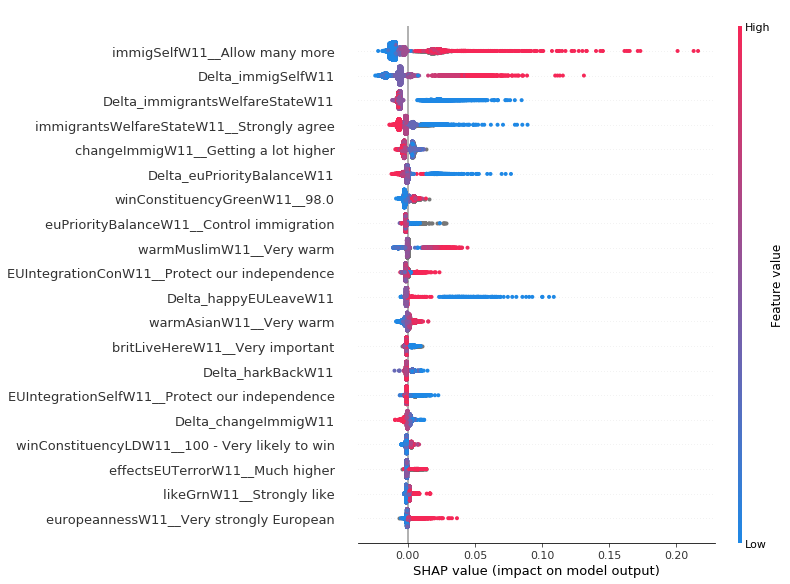

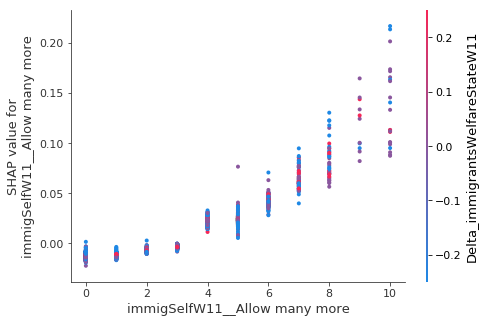

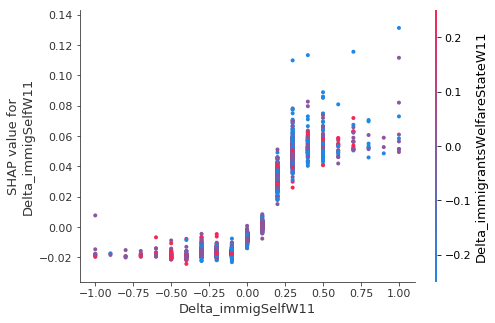

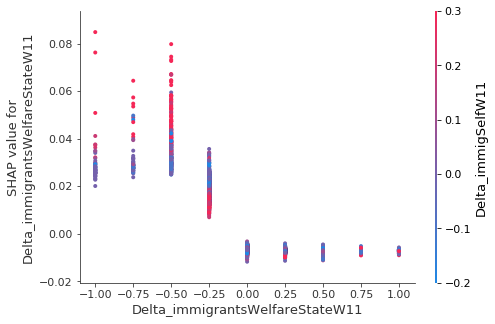

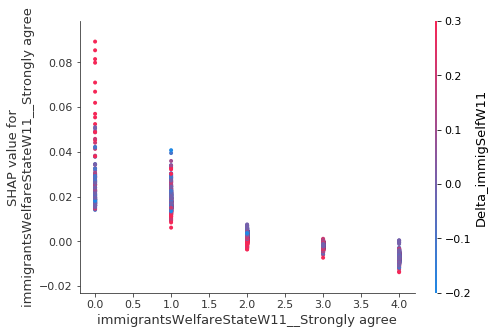

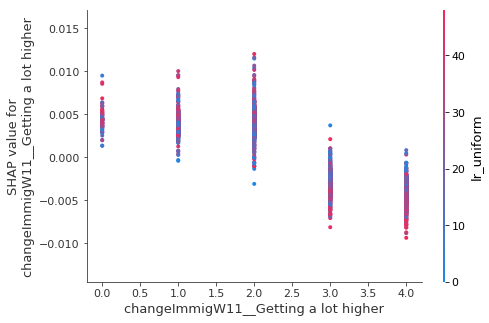

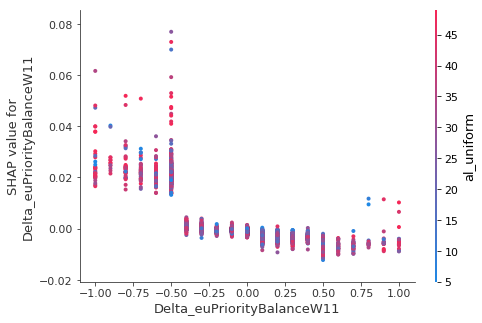

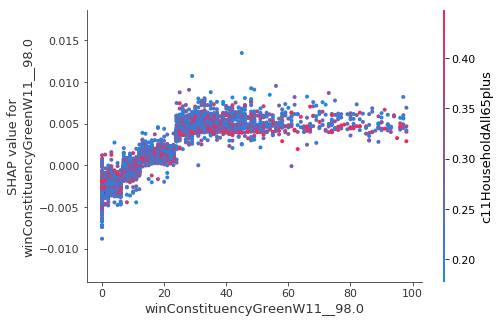

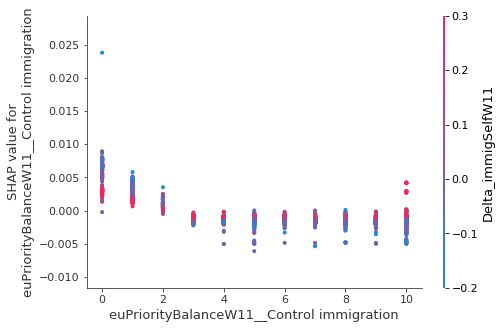

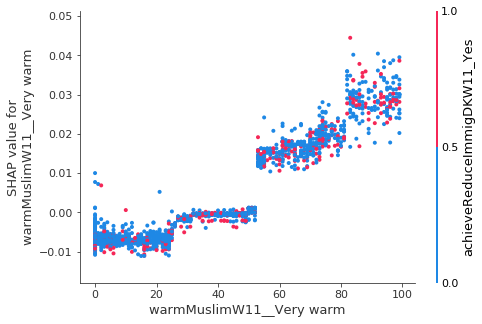

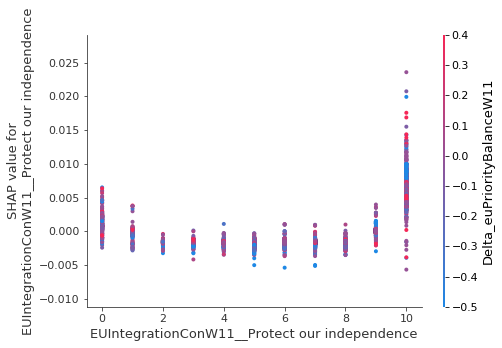

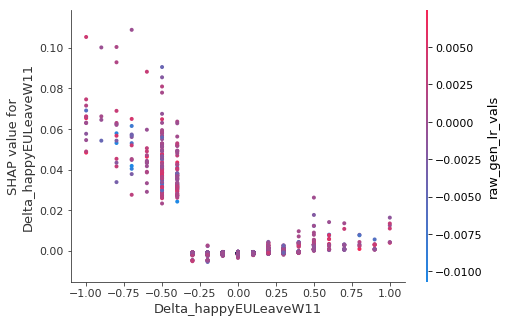

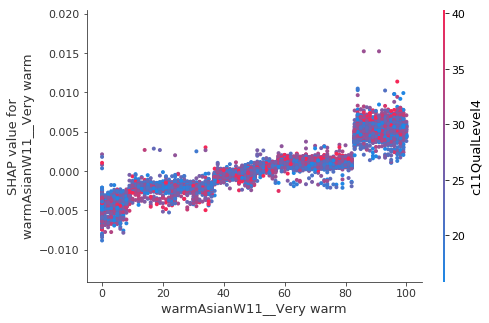

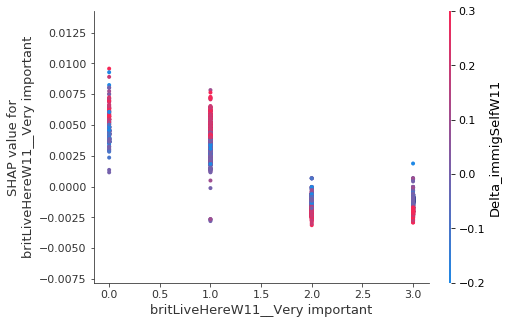

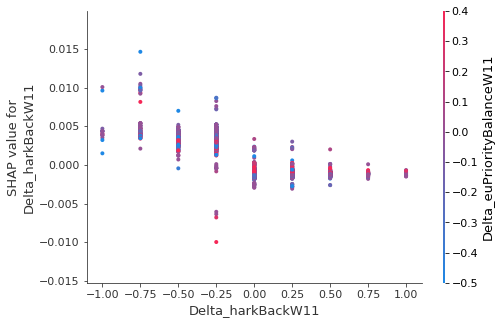

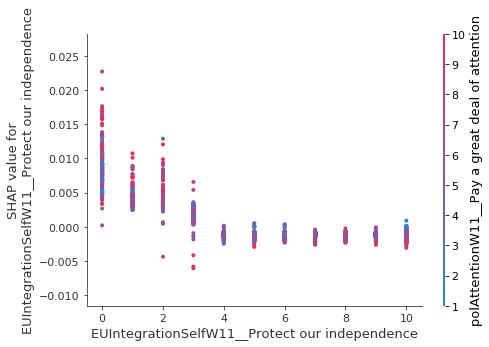

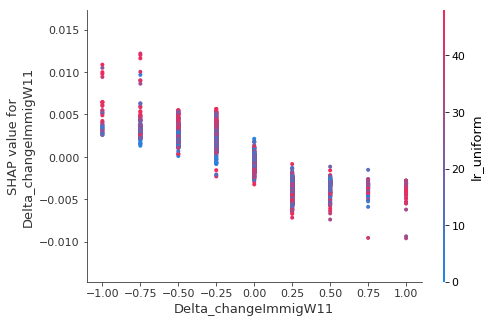

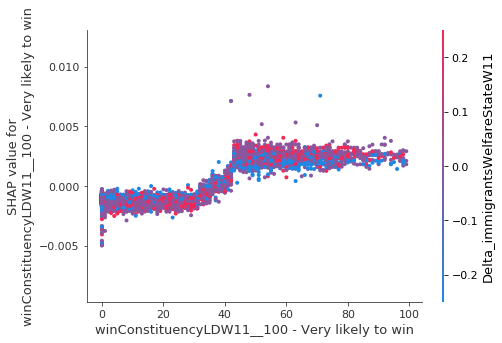

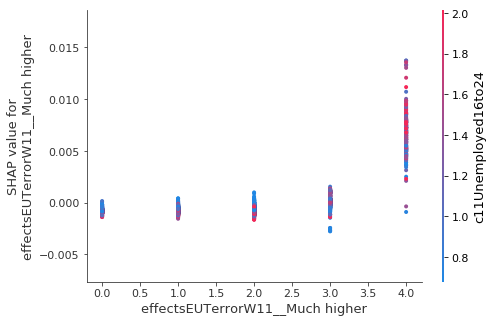

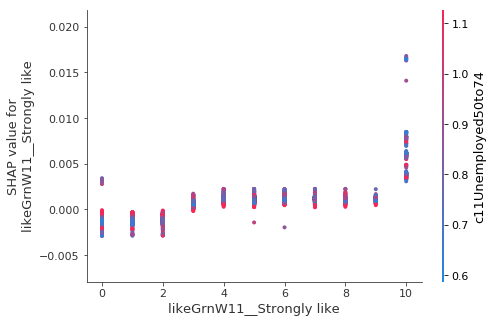

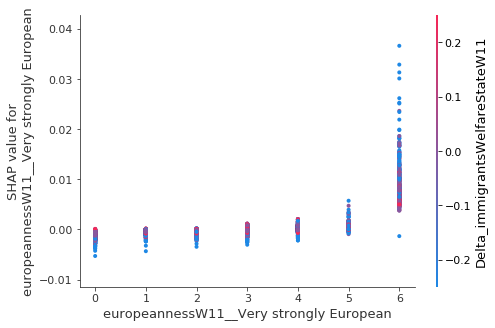

Delta_immigCult_plus_EcW13 13
missing vals in sample weights: 0
[0]	validation_0-rmse:0.497536
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:0.479911
[2]	validation_0-rmse:0.462968
[3]	validation_0-rmse:0.446867
[4]	validation_0-rmse:0.431419
[5]	validation_0-rmse:0.41667
[6]	validation_0-rmse:0.40264
[7]	validation_0-rmse:0.3892
[8]	validation_0-rmse:0.376463
[9]	validation_0-rmse:0.364253
[10]	validation_0-rmse:0.352629
[11]	validation_0-rmse:0.34153
[12]	validation_0-rmse:0.331011
[13]	validation_0-rmse:0.320974
[14]	validation_0-rmse:0.311391
[15]	validation_0-rmse:0.302414
[16]	validation_0-rmse:0.293859
[17]	validation_0-rmse:0.285793
[18]	validation_0-rmse:0.278032
[19]	validation_0-rmse:0.270755
[20]	validation_0-rmse:0.263783
[21]	validation_0-rmse:0.25722
[22]	validation_0-rmse:0.251099
[23]	validation_0-rmse:0.245262
[24]	validation_0-rmse:0.239765
[25]	validation_0-rmse:0.234662
[26]	validation_0-rmse:0.229756
[27]	validation_0-rm

[249]	validation_0-rmse:0.160713
[250]	validation_0-rmse:0.160736
[251]	validation_0-rmse:0.160735
[252]	validation_0-rmse:0.160744
[253]	validation_0-rmse:0.160747
[254]	validation_0-rmse:0.160756
[255]	validation_0-rmse:0.160757
[256]	validation_0-rmse:0.160773
[257]	validation_0-rmse:0.160779
[258]	validation_0-rmse:0.160773
[259]	validation_0-rmse:0.160761
[260]	validation_0-rmse:0.160766
[261]	validation_0-rmse:0.160774
[262]	validation_0-rmse:0.16077
[263]	validation_0-rmse:0.160754
[264]	validation_0-rmse:0.160753
[265]	validation_0-rmse:0.16077
[266]	validation_0-rmse:0.160769
[267]	validation_0-rmse:0.16077
[268]	validation_0-rmse:0.160775
[269]	validation_0-rmse:0.16078
[270]	validation_0-rmse:0.160792
[271]	validation_0-rmse:0.160801
[272]	validation_0-rmse:0.16082
[273]	validation_0-rmse:0.160828
[274]	validation_0-rmse:0.160824
[275]	validation_0-rmse:0.160831
[276]	validation_0-rmse:0.160833
[277]	validation_0-rmse:0.160845
[278]	validation_0-rmse:0.160852
[279]	validatio

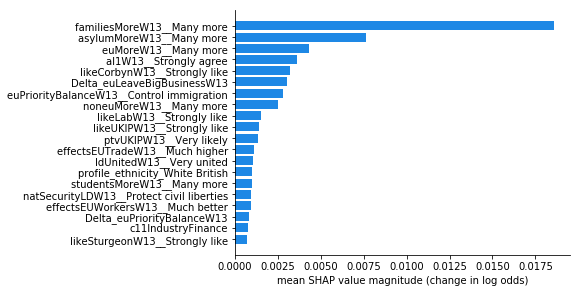

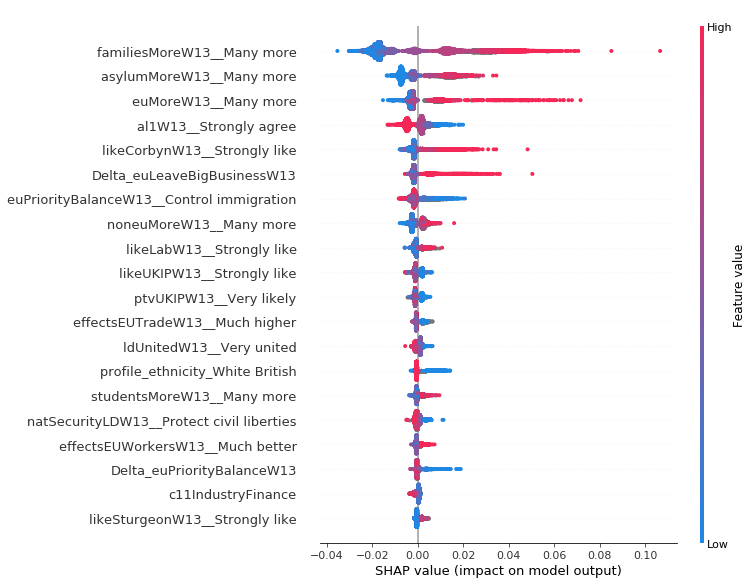

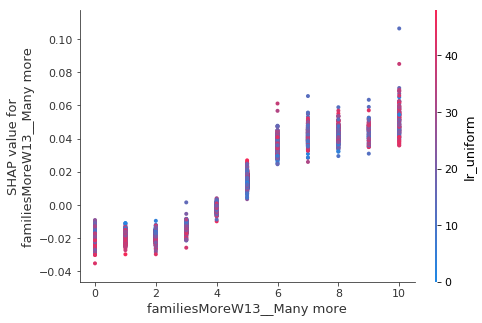

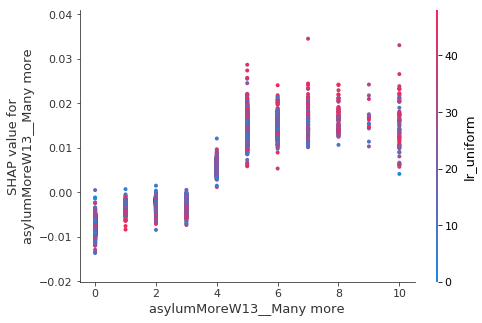

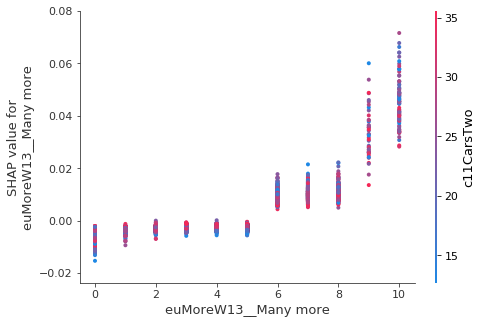

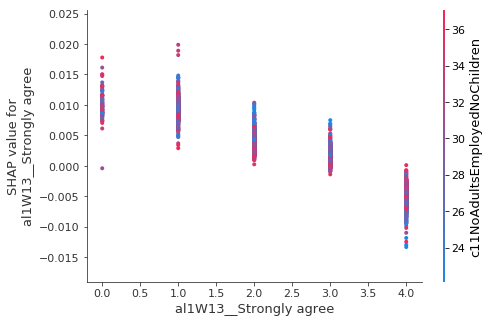

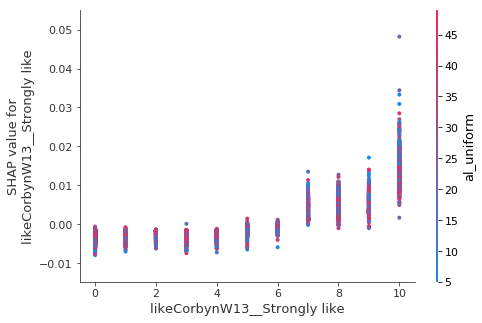

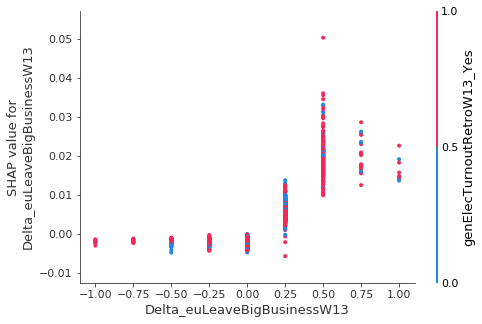

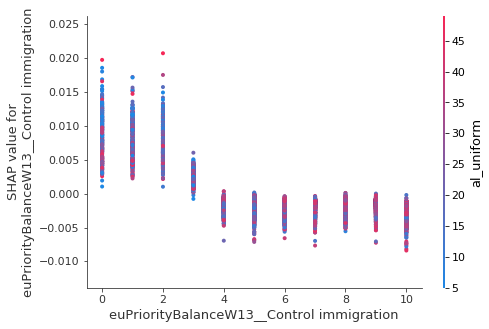

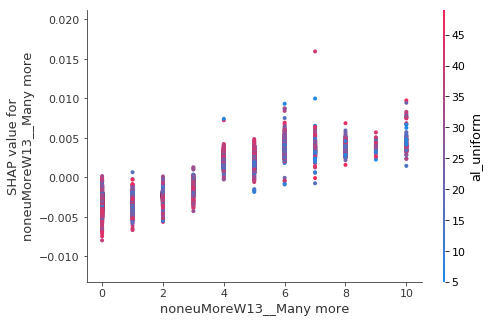

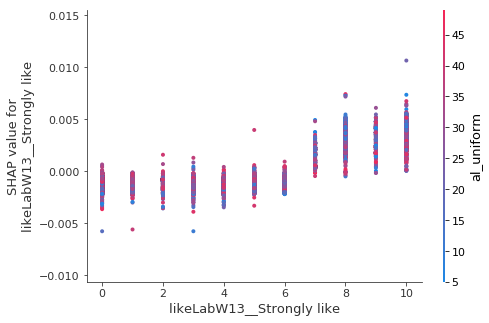

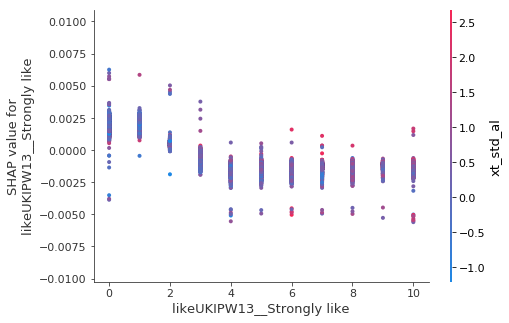

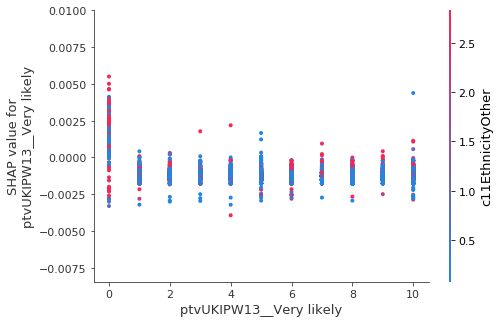

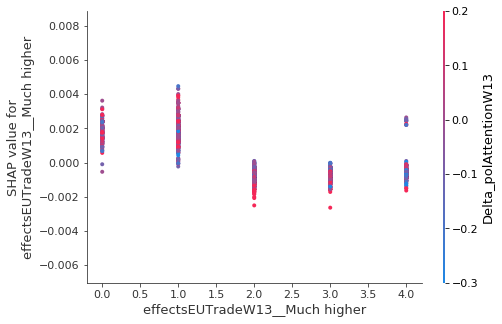

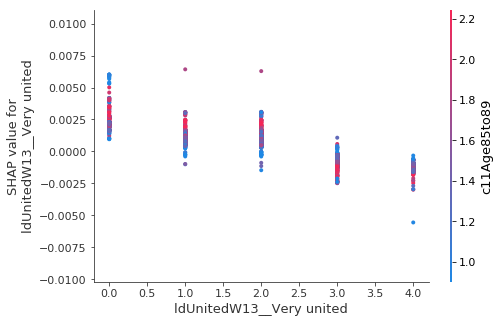

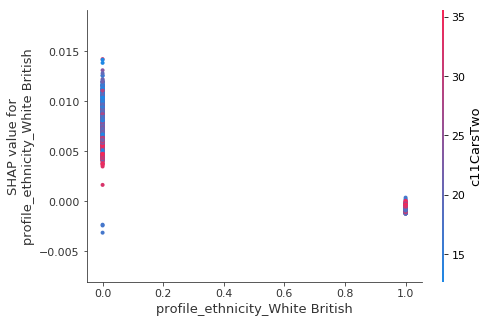

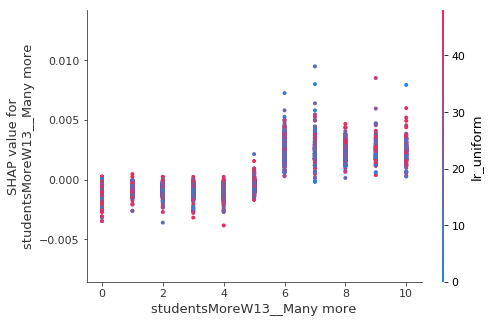

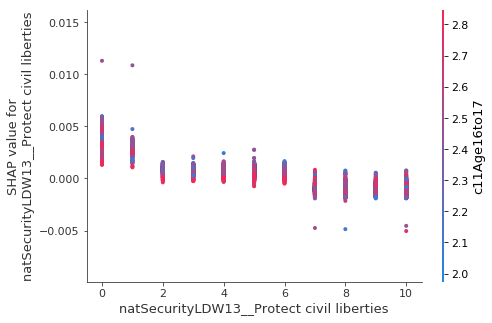

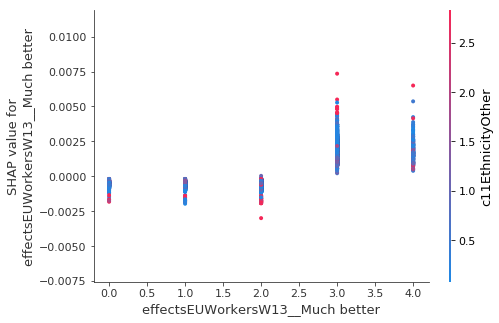

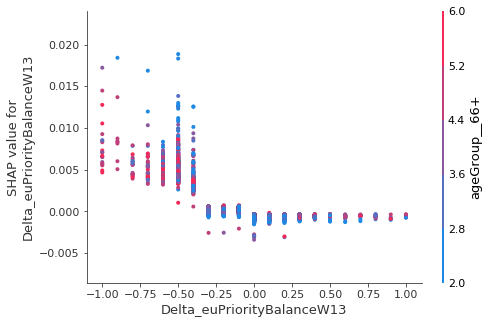

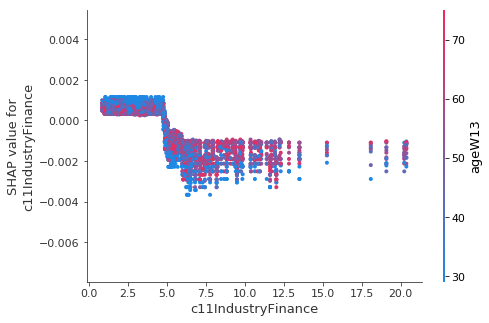

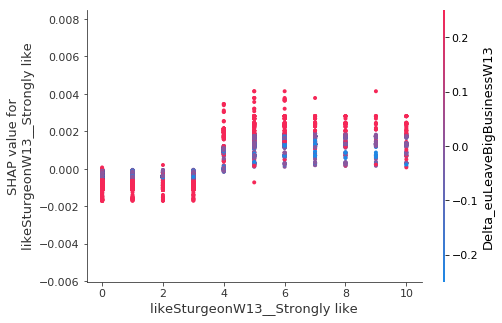

Wall time: 1h 44min 47s


In [29]:
%%time
#     target_var = "immigSelfW10__Allow many more"
# weight_var = 'wt_new_W10'  

num_to_wave = {x:"W"+str(x) for x in range(1,14)}
num_to_weight = { y:[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,14) }
# 'wt_new_W10'

#'wt_full_W9'
# track base variable in list
base_var = 0
for target_var in var_list:
    
#     wave_no = 10
    wave_no = int( re.search( 'W(\d+)$', target_var ).groups()[0] )
    weight_var = num_to_weight[wave_no]
    
    print( target_var, wave_no )
    
#     mask  = immigDiff[target_var].notnull()
#     target = immigDiff[target_var][mask]
#     mask = immigDiff[diff_list ].notnull().all(axis=1)
    mask = immigDiff[target_var].notnull()
    base = BES_reduced_with_na[base_list[base_var]]
    base_var = base_var +1
#     mask = mask & (base >= base.quantile(0.25)) & (base <=base.quantile(0.75))    
    mask = mask & (base <=base.quantile(0.5))
    target = immigDiff[target_var][mask]
#     target = immigDiff[diff_list ].mean(axis=1)[mask]
    
    
    train  = BES_reduced_with_na[mask].copy()
    train = pd.concat([train,immigDiff[mask]],axis=1)
#     train  = train.drop(target_var, axis=1)    
    
#     mask   = changeImmigCultural.notnull()    
#     target = changeImmigCultural[mask]
    
#     train  = train.drop(target_var, axis=1)
    

    
#     mask   = BES_reduced_with_na[target_var].notnull()
#    target = BES_reduced_with_na[target_var][mask]
#     mask   = train[target_var].notnull()

    train  = pd.concat([train,pan_dataset_values.drop('id',axis=1)[mask]],axis=1)
    
    
    # remove zero variance columns
#     train  = train.drop(train.columns[train.var()==0], axis=1)
    drop_columns = train.columns[train.var()==0]
    train_columns = train.columns
    
    # add pan_dataset_values columns
    
#     train  = train.drop("genImmigSentiment", axis=1)
    drop_columns.append("genImmigSentiment")
    
    # drop variables that definitely involve *some* downsteam component - e.g. target is W4, predictor is W6
    
#     other_waves = "("+"|".join([num_to_wave[x] for x in range(1,14) if (x>wave_no) or (x<wave_no) ]) +")" +"([^0-9]|$)"
    
    
#     drop_columns.extend( [x for x in train.columns if re.search(other_waves,x)] )
    #train = train.drop( [x for x in train.columns if re.search(other_waves,x)] , axis=1 )   
    
#     for future_wave in [num_to_wave[x] for x in range(1,14) if (x>wave_no) or (x<wave_no) ]:
#         train = train.drop([x for x in train.columns if re.search(future_wave+"[^0-9]",x)], axis=1)
        
        
#     train = train.drop([x for x in train.columns if ("W10" in x)|("W11" in x)|("W12" in x)|("W13" in x)], axis=1)
    for var_stub in var_stub_list:
#         train = train.drop([x for x in train.columns if var_stub in x], axis=1)
        drop_columns.extend( [x for x in train.columns if var_stub in x] )
    
#     train = train.drop([x for x in train.columns if "immigCultural" in x], axis=1)      
#     train = train.drop([x for x in train.columns if "euRefVote" in x], axis=1)    


    sample_weights = BES_Panel[weight_var][mask]
    print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
    sample_weights = sample_weights.fillna(sample_weights.median())

    output_subfolder = BES_output_folder + "xgboost&shap&completedata" + os.sep + target_var + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )


    ############################

    alg = XGBRegressor(
     learning_rate =0.04,
     n_estimators= 2000,
     max_depth=3,
     min_child_weight=1,
     gamma=0,
     subsample=0.75,
     colsample_bytree=0.9,
     colsample_bylevel=.85,
     objective= 'reg:linear',
     scale_pos_weight=1.0,
     reg_alpha=0,
     reg_lambda=1,
     njobs=3,
     seed=27)

    # split data into train and test sets
    # fit, validate and find overfitting limit
    seed = 7
    test_size = 0.33

    X_train, X_test, y_train, y_test = train_test_split(pd.concat([train,sample_weights],axis=1), target, test_size=test_size,
                                                        random_state=seed, stratify=round(target))



    eval_set = [(X_test, y_test)]

    sample_weight = X_train[weight_var].values
    sample_weight_eval_set = X_test[weight_var].values
    X_train.drop(weight_var, axis=1, inplace=True)
    X_test.drop(weight_var, axis=1, inplace=True)

    alg.fit(X_train, y_train, eval_metric='rmse', 
            early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
            verbose=True, sample_weight= sample_weight)

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)

    ####################################
    # fit to full dataset at non-overfitting level
    alg.fit(train, target, verbose=True, sample_weight= sample_weights)




    shap_values = shap.TreeExplainer(alg).shap_values(train);


    #################################
    threshold = .1
    min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)[:-1]
    n_top_features = sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold)
    if n_top_features <min_features:
        n_top_features = min_features



    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig(output_subfolder + "mean_impact" + ".png", bbox_inches='tight')

    plt.show()

    ####################
    fig = plt.figure()
    shap.summary_plot(shap_values, train, max_display=n_top_features, plot_type='dot');
    fig.savefig(output_subfolder + "summary_plot" + ".png", bbox_inches='tight')



    ##################
    count = 0
    for name in train.columns[inds[::-1]]:
        fig = plt.figure(figsize = (16,10))    
        shap.dependence_plot(name, shap_values, train)
        fig.savefig(output_subfolder + "featureNo "+str(count) + " " + name.replace("/","_") + ".png", bbox_inches='tight')
        count = count + 1

In [71]:
# metric_sklearn = ‘neg_mean_squared_error’ or 'remse'
# estimator_cls = xgb.XGBClassifier, xgb.XGBRegressor


# Tune the parameters incrementally and limit the range for colsample_bytree and subsample
best_params, history = tune_xgb_params(
    cv_folds=3,
    label=target,
    metric_sklearn='neg_mean_squared_error',
    metric_xgb="rmse",
    n_jobs=4,
    objective='reg:linear',
    random_state=2017,
    strategy='incremental',
    train=train,
    init_colsample_bytree = 0.9,
    init_gamma = 0.0,
    init_max_depth = 3,
    init_min_child_weight  = 1,
    init_subsample = 0.75,
#     learning_rates = [0.01, 0.04, 0.1],
)

[0]	train-rmse:0.459835+0.000173753	test-rmse:0.460246+0.000262824
[1]	train-rmse:0.424652+0.000792481	test-rmse:0.42609+0.00173848
[2]	train-rmse:0.393969+0.000441922	test-rmse:0.396209+0.00174608
[3]	train-rmse:0.367097+0.00129022	test-rmse:0.370305+0.000641559
[4]	train-rmse:0.342887+0.00107282	test-rmse:0.347475+0.00221501
[5]	train-rmse:0.323225+0.00146757	test-rmse:0.328745+0.00200833
[6]	train-rmse:0.303887+0.00155993	test-rmse:0.310062+0.00207043
[7]	train-rmse:0.286623+0.00155986	test-rmse:0.29388+0.00222769
[8]	train-rmse:0.271804+0.00170069	test-rmse:0.280243+0.00250291
[9]	train-rmse:0.258874+0.00164434	test-rmse:0.268015+0.00270204
[10]	train-rmse:0.247122+0.00177982	test-rmse:0.257425+0.00306427
[11]	train-rmse:0.237516+0.00183337	test-rmse:0.248576+0.00329528
[12]	train-rmse:0.228972+0.00204613	test-rmse:0.24088+0.00340726
[13]	train-rmse:0.221562+0.00271732	test-rmse:0.234837+0.00313078
[14]	train-rmse:0.21464+0.00275468	test-rmse:0.229156+0.0030203
[15]	train-rmse:0.20

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   33.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   53.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 12.0min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 12.9min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   32.9s
[Parallel(n_jobs=4)]: Done  13 out of  18 | elapsed:   42.5s remaining:   16.3s
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:   43.4s remaining:    8.6s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   53.1s finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   38.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  3.0min finished


Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   31.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   52.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:  2.5min finished


Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   50.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:  2.5min finished


[0]	train-rmse:0.495934+2.74752e-05	test-rmse:0.495988+1.84451e-05
[1]	train-rmse:0.491925+6.08514e-05	test-rmse:0.492058+1.08012e-05
[2]	train-rmse:0.487953+8.61794e-05	test-rmse:0.48815+2.23954e-05
[3]	train-rmse:0.484036+0.000117178	test-rmse:0.484297+5.21685e-05
[4]	train-rmse:0.480162+0.000148554	test-rmse:0.480467+6.35627e-05
[5]	train-rmse:0.476407+0.000196603	test-rmse:0.476821+0.000175826
[6]	train-rmse:0.472717+0.000314643	test-rmse:0.473246+7.22234e-05
[7]	train-rmse:0.468975+0.00034165	test-rmse:0.469549+5.77427e-05
[8]	train-rmse:0.465279+0.000366314	test-rmse:0.465921+4.6942e-05
[9]	train-rmse:0.461727+0.000278088	test-rmse:0.462423+0.000116708
[10]	train-rmse:0.458106+0.000301647	test-rmse:0.458865+0.000119507
[11]	train-rmse:0.454534+0.000334262	test-rmse:0.455344+0.000134373
[12]	train-rmse:0.451103+0.000361997	test-rmse:0.451996+0.000137058
[13]	train-rmse:0.447709+0.000258512	test-rmse:0.448671+0.000253259
[14]	train-rmse:0.444261+0.000292858	test-rmse:0.445277+0.000

[124]	train-rmse:0.238058+0.00241494	test-rmse:0.248625+0.00270002
[125]	train-rmse:0.237203+0.00242256	test-rmse:0.247875+0.00271739
[126]	train-rmse:0.236328+0.00245217	test-rmse:0.247109+0.002721
[127]	train-rmse:0.235475+0.00246966	test-rmse:0.246328+0.0027352
[128]	train-rmse:0.234648+0.00247844	test-rmse:0.245583+0.00272243
[129]	train-rmse:0.233805+0.00250437	test-rmse:0.24483+0.0027461
[130]	train-rmse:0.233011+0.00250174	test-rmse:0.244076+0.00278287
[131]	train-rmse:0.232183+0.00252633	test-rmse:0.243327+0.00280895
[132]	train-rmse:0.231379+0.00255171	test-rmse:0.242632+0.00284635
[133]	train-rmse:0.230606+0.00257643	test-rmse:0.241908+0.00283682
[134]	train-rmse:0.229866+0.00257042	test-rmse:0.241258+0.00289696
[135]	train-rmse:0.229105+0.00260407	test-rmse:0.240588+0.00287814
[136]	train-rmse:0.228364+0.00261575	test-rmse:0.239922+0.00290168
[137]	train-rmse:0.227651+0.00262347	test-rmse:0.239267+0.00293089
[138]	train-rmse:0.226943+0.00264215	test-rmse:0.238606+0.00295705


[248]	train-rmse:0.183693+0.00314932	test-rmse:0.204505+0.00381676
[249]	train-rmse:0.183486+0.00315842	test-rmse:0.204392+0.00382605
[250]	train-rmse:0.18329+0.00315564	test-rmse:0.204269+0.00383882
[251]	train-rmse:0.183093+0.00315756	test-rmse:0.204159+0.00383925
[252]	train-rmse:0.182898+0.00315533	test-rmse:0.204045+0.00382461
[253]	train-rmse:0.182706+0.00316413	test-rmse:0.203941+0.00383451
[254]	train-rmse:0.182518+0.00316166	test-rmse:0.203831+0.00385089
[255]	train-rmse:0.18232+0.00316496	test-rmse:0.20372+0.00386594
[256]	train-rmse:0.182131+0.00317302	test-rmse:0.203593+0.00386471
[257]	train-rmse:0.181939+0.00317625	test-rmse:0.203494+0.00387846
[258]	train-rmse:0.18176+0.00318283	test-rmse:0.203395+0.00388161
[259]	train-rmse:0.181581+0.00317133	test-rmse:0.203298+0.00388812
[260]	train-rmse:0.1814+0.00318015	test-rmse:0.203208+0.00389962
[261]	train-rmse:0.181219+0.00317824	test-rmse:0.203102+0.00388046
[262]	train-rmse:0.181048+0.00317532	test-rmse:0.203004+0.00388456
[

[372]	train-rmse:0.167479+0.00315834	test-rmse:0.197657+0.00501811
[373]	train-rmse:0.167387+0.00317135	test-rmse:0.197614+0.00500083
[374]	train-rmse:0.167298+0.00317584	test-rmse:0.197599+0.00499526
[375]	train-rmse:0.167202+0.00317459	test-rmse:0.197579+0.00501747
[376]	train-rmse:0.167114+0.00317519	test-rmse:0.197559+0.00502762
[377]	train-rmse:0.167027+0.00317526	test-rmse:0.197531+0.00501901
[378]	train-rmse:0.16695+0.00317654	test-rmse:0.19752+0.00501785
[379]	train-rmse:0.166865+0.00317955	test-rmse:0.19751+0.00501881
[380]	train-rmse:0.166766+0.003178	test-rmse:0.197472+0.00501663
[381]	train-rmse:0.166675+0.00317542	test-rmse:0.197442+0.00502477
[382]	train-rmse:0.166595+0.00316948	test-rmse:0.19742+0.00501049
[383]	train-rmse:0.166502+0.00317608	test-rmse:0.197379+0.00502542
[384]	train-rmse:0.166405+0.00317484	test-rmse:0.197366+0.00504493
[385]	train-rmse:0.166343+0.00317781	test-rmse:0.197344+0.00504946
[386]	train-rmse:0.166259+0.00317439	test-rmse:0.19731+0.00505091
[3

[496]	train-rmse:0.15934+0.00304272	test-rmse:0.196196+0.00506219
[497]	train-rmse:0.159295+0.0030534	test-rmse:0.196203+0.00507054
[498]	train-rmse:0.159241+0.00307007	test-rmse:0.196182+0.00507897
[499]	train-rmse:0.159214+0.00306511	test-rmse:0.196176+0.00508372
[500]	train-rmse:0.159182+0.00306223	test-rmse:0.196177+0.00508246
[501]	train-rmse:0.159121+0.00306876	test-rmse:0.19617+0.00506939
[502]	train-rmse:0.159071+0.00307838	test-rmse:0.196169+0.005066
[503]	train-rmse:0.159022+0.00307192	test-rmse:0.196161+0.0050683
[504]	train-rmse:0.158978+0.00305124	test-rmse:0.196138+0.00507758
[505]	train-rmse:0.158927+0.00306776	test-rmse:0.196128+0.00508737
[506]	train-rmse:0.158881+0.00307163	test-rmse:0.196113+0.00507879
[507]	train-rmse:0.158845+0.00308302	test-rmse:0.196115+0.0050838
[508]	train-rmse:0.158803+0.00309039	test-rmse:0.19611+0.00508433
[509]	train-rmse:0.158765+0.00308227	test-rmse:0.196106+0.00509013
[510]	train-rmse:0.158698+0.00309155	test-rmse:0.196103+0.00507832
[51

[620]	train-rmse:0.155074+0.00309204	test-rmse:0.195823+0.00533994
[621]	train-rmse:0.155074+0.00309204	test-rmse:0.195823+0.00533994
[622]	train-rmse:0.155066+0.00308163	test-rmse:0.195816+0.00534914
[623]	train-rmse:0.155066+0.00308163	test-rmse:0.195816+0.00534958
[624]	train-rmse:0.15505+0.00309203	test-rmse:0.195819+0.00535216
[625]	train-rmse:0.155043+0.0030944	test-rmse:0.195819+0.005352
[626]	train-rmse:0.15503+0.00309899	test-rmse:0.195822+0.00535271
[627]	train-rmse:0.15501+0.00310608	test-rmse:0.195823+0.00535295
[628]	train-rmse:0.155+0.00310947	test-rmse:0.195823+0.00535323
[629]	train-rmse:0.155+0.00310959	test-rmse:0.195822+0.00535368
[630]	train-rmse:0.154991+0.00311279	test-rmse:0.195827+0.00535487
[631]	train-rmse:0.154978+0.00311792	test-rmse:0.195824+0.00535415
[632]	train-rmse:0.154971+0.00312034	test-rmse:0.195825+0.00535468
[633]	train-rmse:0.154944+0.00309633	test-rmse:0.195828+0.0053527
[634]	train-rmse:0.154925+0.00310375	test-rmse:0.195823+0.00535143
[635]	tr

In [72]:
history

[({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.1,
   'max_depth': 3,
   'min_child_weight': 1,
   'nthread': 4,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 2017,
   'n_estimators': 60},
  0.15224800000000002),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.1,
   'max_depth': 3,
   'min_child_weight': 1,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 2017,
   'n_estimators': 60},
  0.19699810647453983),
 ({'colsample_bytree': 0.9,
   'gamma': 0.0,
   'learning_rate': 0.1,
   'max_depth': 3,
   'min_child_weight': 3,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 2017,
   'n_estimators': 60},
  0.19672918589642255),
 ({'colsample_bytree': 0.9,
   'gamma': 0.4,
   'learning_rate': 0.1,
   'max_depth': 3,
   'min_child_weight': 3,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 0.75,
   'random_state': 2017,
   'n_estimators': 60},
  0.19588558281731608),
 ({'colsample_bytree': 0.9,
   'gamma': 0.4,
   'learning_rate': 0.1,
   'max_depth': 3,
   'min_child_weight': 3,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 1.0,
   'random_state': 2017,
   'n_estimators': 60},
  0.19542846687098675),
 ({'colsample_bytree': 0.9,
   'gamma': 0.4,
   'learning_rate': 0.1,
   'max_depth': 3,
   'min_child_weight': 3,
   'nthread': 1,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 1.0,
   'random_state': 2017,
   'n_estimators': 60,
   'reg_alpha': 0.01},
  0.19542846687098675),
 ({'colsample_bytree': 0.9,
   'gamma': 0.4,
   'learning_rate': 0.01,
   'max_depth': 3,
   'min_child_weight': 3,
   'nthread': 4,
   'objective': 'reg:linear',
   'scale_pos_weight': 1,
   'subsample': 1.0,
   'random_state': 2017,
   'n_estimators': 660,
   'reg_alpha': 0.01,
   'reg_lambda': 1},
  0.154578)]

In [73]:
best_params

{'colsample_bytree': 0.9,
 'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 3,
 'nthread': 4,
 'objective': 'reg:linear',
 'scale_pos_weight': 1,
 'subsample': 1.0,
 'random_state': 2017,
 'n_estimators': 60,
 'reg_alpha': 0.01,
 'reg_lambda': 1}

In [78]:
# %%time

alg = XGBRegressor(
 learning_rate =0.04,
 n_estimators= 200,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 njobs=3,
 seed=27)

param_test1 ={'colsample_bytree': [0.9406878704353334],
              'colsample_bylevel': [.85],
              'gamma': [0.3602431963104453],
              'max_depth': [3,7],
              'min_child_weight': [1,7],
#              'reg_alpha': [0.3417550031763382],
#               'reg_lambda': [100000],
              'subsample': [.35,.75]}

param_test1 = {'colsample_bytree': [0.9],
 'gamma': [0.4],
 'learning_rate':[ 0.1 ],
 'max_depth': [3],
 'min_child_weight': [3],
 'nthread':[ 4],
 'scale_pos_weight': [1],
 'subsample': [1.0],
 'n_estimators': [60],
 'reg_alpha': [0.01],
 'reg_lambda': [1]}

gsearch1 = GridSearchCV(estimator = alg,
                        param_grid = param_test1,
#                         scoring='neg_mean_squared_error',
                        scoring='r2',
                        n_jobs=3, 
                        iid=False,
                        cv=3,
                        verbose=True)

gsearch1.fit(train,target)

display(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

# crash? 

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.1s finished


[mean: 0.69845, std: 0.01749, params: {'colsample_bytree': 0.9, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 60, 'nthread': 4, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1.0}]

{'colsample_bytree': 0.9,
 'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 60,
 'nthread': 4,
 'reg_alpha': 0.01,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1.0}

0.6984500115126876

In [ ]:
# {'colsample_bytree': 0.9406878704353334,
#  'gamma': 0.3602431963104453,
#  'reg_alpha': 0.3417550031763382,
#  'reg_lambda': 6.129697145976404,
#  'subsample': 0.3376466304151647}
# 0.6996114800517149

# drop 'reg_lambda': [6.129697145976404],

# {'colsample_bytree': 0.9406878704353334,
#  'gamma': 0.3602431963104453,
#  'reg_alpha': 0.3417550031763382,
#  'subsample': 0.3376466304151647}
# 0.6995632490444724


# drop 'reg_alpha': [0.3417550031763382],
# 0.698168025601119
# {'colsample_bytree': 0.9406878704353334,
#  'gamma': 0.3602431963104453,
#  'subsample': 0.3376466304151647}

# {'colsample_bytree': 0.9406878704353334,
#  'gamma': 0.3602431963104453,
#  'reg_lambda': 1000,
#  'subsample': 0.3376466304151647}

# {'colsample_bytree': 0.9406878704353334,
#  'gamma': 0.3602431963104453,
#  'reg_lambda': 100000,
#  'subsample': 0.3376466304151647}
# -0.805156642502765

# {'colsample_bylevel': 0.85,
#  'colsample_bytree': 0.9406878704353334,
#  'gamma': 0.3602431963104453,
#  'max_depth': 7,
#  'min_child_weight': 7,
#  'subsample': 0.35}
# 0.7072693242111185

In [ ]:
##############################

In [9]:
[x for x in BES_reduced_with_na.columns if "bestPM" in x]

['bestPMW8_Jeremy Corbyn',
 'bestPMW7_Jeremy Corbyn',
 'bestPMW12_Jeremy Corbyn',
 'bestPMW10_Jeremy Corbyn',
 'bestPMW11_Jeremy Corbyn']

In [11]:
[x for x in BES_Panel.columns if "bestPM" in x]

['bestPMW7', 'bestPMW8', 'bestPMW10', 'bestPMW11', 'bestPMW12']

In [12]:
BES_Panel['bestPMW7']

0              Neither
1        David Cameron
2              Neither
3                  NaN
4                  NaN
5              Neither
6        Jeremy Corbyn
7        David Cameron
8              Neither
9        David Cameron
10       David Cameron
11                 NaN
12                 NaN
13                 NaN
14       David Cameron
15                 NaN
16       David Cameron
17                 NaN
18       Jeremy Corbyn
19                 NaN
20                 NaN
21                 NaN
22             Neither
23                 NaN
24                 NaN
25             Neither
26             Neither
27                 NaN
28             Neither
29             Neither
             ...      
68595              NaN
68596              NaN
68597              NaN
68598              NaN
68599              NaN
68600              NaN
68601              NaN
68602              NaN
68603              NaN
68604              NaN
68605              NaN
68606              NaN
68607      

In [15]:
var_stub = "edlevel"
var_list = [x for x in BES_reduced_with_na.columns if var_stub in x]
var_stub_list = ["edlevel","education", "profile_education_age", "anyUni"]
# var_list = ['edlevelW13__Postgrad']
var_list
var_list = ["edlevel_allwaves"]

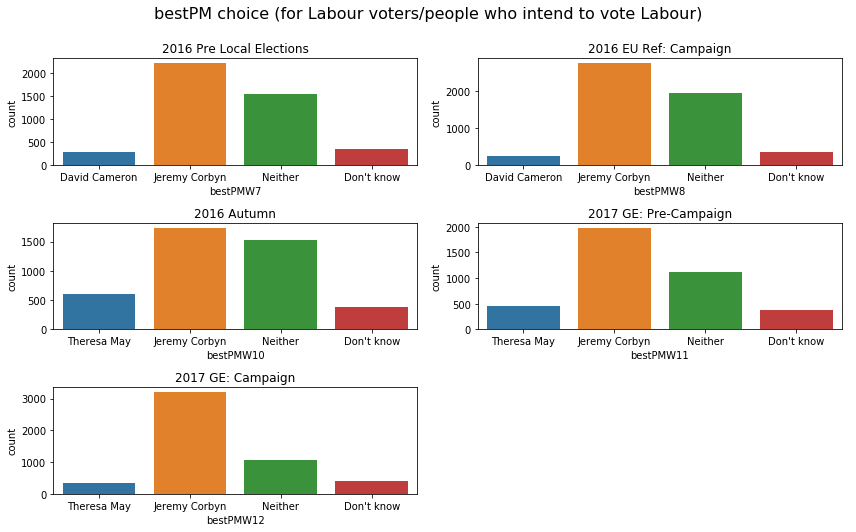

In [186]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,7))
count = 0
for target_var in var_list:
#     print(count%2,int( count/2))
    sns.countplot(BES_Panel[target_var][ (BES_Panel["generalElectionVoteW" + str(wave_no)]=="Labour") & (BES_Panel["country"]=="England") ],
                  ax=axes[int( count/2),count%2] ) 
    wave_no = int( re.search( 'W(\d+)($|[_]+[a-zA-Z])', target_var ).groups()[0] )
    nice_title = BES_file_manifest[(BES_file_manifest["Wave No"] == wave_no) &\
                      (BES_file_manifest["Only_or_Combined"] == "Only") ]["Friendlier_Description"].values[0]
    axes[int( count/2),count%2].set_title(nice_title)
    count = count + 1
    

plt.tight_layout()
plt.suptitle("bestPM choice (for Labour voters/people who intend to vote Labour)", y=1.05,  verticalalignment='top', fontsize=16);
axes[-1, -1].axis('off')

fig.savefig(output_subfolder + "bestPM(forLabourVoters)"+".png", bbox_inches='tight')


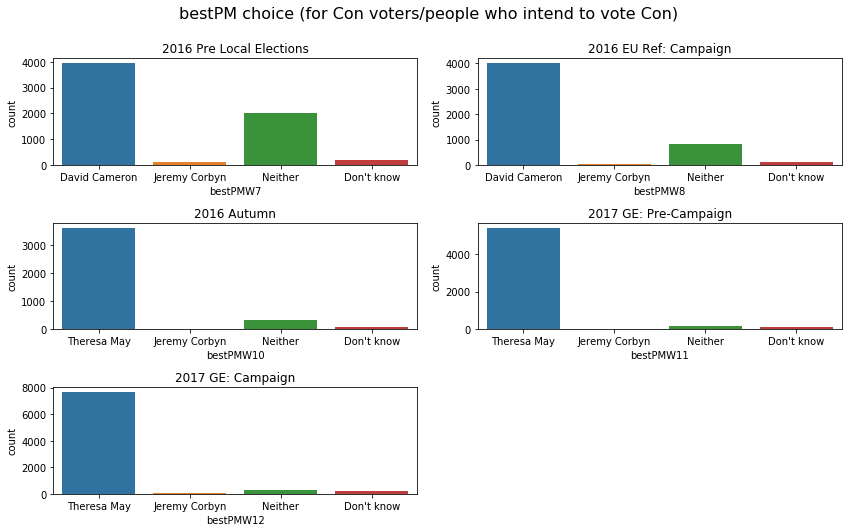

In [187]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,7))
count = 0
for target_var in var_list:
#     print(count%2,int( count/2))
    sns.countplot(BES_Panel[target_var][ (BES_Panel["generalElectionVoteW" + str(wave_no)]=="Conservative") & (BES_Panel["country"]=="England") ],
                  ax=axes[int( count/2),count%2] ) 
    wave_no = int( re.search( 'W(\d+)($|[_]+[a-zA-Z])', target_var ).groups()[0] )
    nice_title = BES_file_manifest[(BES_file_manifest["Wave No"] == wave_no) &\
                      (BES_file_manifest["Only_or_Combined"] == "Only") ]["Friendlier_Description"].values[0]
    axes[int( count/2),count%2].set_title(nice_title)
    count = count + 1
    

plt.tight_layout()
plt.suptitle("bestPM choice (for Con voters/people who intend to vote Con)", y=1.05,  verticalalignment='top', fontsize=16);
axes[-1, -1].axis('off')

fig.savefig(output_subfolder + "bestPM(forConVoters)"+".png", bbox_inches='tight')


In [181]:
output_subfolder

'../BES_analysis_output/xgboost&shap&completedata&drop_like_neither_or_jc\\bestPMW12\\'

In [136]:
(BES_file_manifest["Only_or_Combined"] == "Only"

Name                                          BES_Title  \
0           W13_only  Wave 13 of the 2014-2018 British Election Stud...   
1           W13_comb  British Election Study Combined Wave 1-13 Inte...   
2   W13_comb_strings  British Election Study Combined Wave 1-13 Inte...   
3           W12_only  Wave 12 of the 2014-2018 British Election Stud...   
4           W11_only  Wave 11 of the 2014-2018 British Election Stud...   
5           W10_comb  British Election Study Combined Wave 1-10 Inte...   
6           W10_only  Wave 10 of the 2014-2018 British Election Stud...   
7            W9_comb  British Election Study Combined Wave 1-9 Inter...   
8            W9_only  Wave 9 of the 2014-2018 British Election Study...   
9            W8_only  Wave 8 of the 2014-2018 British Election Study...   
10           W8_comb  British Election Study Combined Wave 1, 2, 3, ...   
11           W7_only  Wave 7 of the 2014-2018 British Election Study...   
12           W7_comb  British Election Study Combined Wave 1, 2, 3, ...   
13           W6_only  Post-Election Wave 6 of the 2014-2018 British ...   
14           W6_comb  British Election Study Combined Wave 1, 2, 3, ...   
15           W5_comb  British Election Study Combined Wave 1, 2, 3, ...   
16           W5_only  Wave 5 of the 2014-2018 British Election Study...   
17           W4_only  Updated Wave 4 of the 2014-2018 British Electi...   
18           W4_comb  Updated British Election Study Combined Wave 1...   
19           W3_only  Wave 3 of the 2014-2018 British Election Study...   
20           W3_comb  2015 British Election Study Combined Wave 1, 2...   
21           W2_only  Wave 2 of the 2014-2018 British Election Study...   
22           W1_only  Wave 1 of the 2014-2018 British Election Study...   

                                              BES_Url  Wave No  \
0   http://www.britishelectionstudy.com/data-objec...       13   
1   http://www.britishelectionstudy.com/data-objec...       13   
2   http://www.britishelectionstudy.com/data-objec...       13   
3   http://www.britishelectionstudy.com/data-objec...       12   
4   http://www.britishelectionstudy.com/data-objec...       11   
5   http://www.britishelectionstudy.com/data-objec...       10   
6   http://www.britishelectionstudy.com/data-objec...       10   
7   http://www.britishelectionstudy.com/data-objec...        9   
8   http://www.britishelectionstudy.com/data-objec...        9   
9   http://www.britishelectionstudy.com/data-objec...        8   
10  http://www.britishelectionstudy.com/data-objec...        8   
11  http://www.britishelectionstudy.com/data-objec...        7   
12  http://www.britishelectionstudy.com/data-objec...        7   
13  http://www.britishelectionstudy.com/data-objec...        6   
14  http://www.britishelectionstudy.com/data-objec...        6   
15  http://www.britishelectionstudy.com/data-objec...        5   
16  http://www.britishelectionstudy.com/data-objec...        5   
17  http://www.britishelectionstudy.com/data-objec...        4   
18  http://www.britishelectionstudy.com/data-objec...        4   
19  http://www.britishelectionstudy.com/data-objec...        3   
20  http://www.britishelectionstudy.com/data-objec...        3   
21  http://www.britishelectionstudy.com/data-objec...        2   
22  http://www.britishelectionstudy.com/data-objec...        1   

   Only_or_Combined Base_or_Strings           Mode  Version  \
0              Only            Base  Online Survey      1.2   
1          Combined            Base  Online Survey      1.2   
2          Combined         Strings  Online Survey      1.0   
3              Only            Base  Online Survey      1.2   
4              Only            Base  Online Survey      1.2   
5          Combined            Base  Online Survey      0.3   
6              Only            Base  Online Survey      0.6   
7          Combined            Base  Online Survey      1.2   
8              Only            Base  Online Survey      1.2   


In [118]:
# target_var = "bestPMW7"
# wave_no = 7

# England = (BES_Panel["country"]=="England")
# mask = BES_Panel[target_var].notnull()
# extra_mask = (BES_Panel["generalElectionVoteW" + str(wave_no)]=="Labour") &\
# ( (BES_Panel["bestPMW" + str(wave_no)]=="Neither") | (BES_Panel["bestPMW" + str(wave_no)]=="Jeremy Corbyn") ) &\
# England

# mask = mask & extra_mask
# target = (BES_Panel[target_var][mask]=="Neither")

In [14]:
# target = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if "edlevel" in x]].mean(axis=1)
# mask = target.notnull()
# target = target[mask]

# train  = BES_reduced_with_na[mask].copy()
# train = pd.concat([train,immigDiff[mask]],axis=1)

In [ ]:
# %%time
#     target_var = "immigSelfW10__Allow many more"
# weight_var = 'wt_new_W10'  
all_waves = True

num_to_wave = {x:"W"+str(x) for x in range(1,14)}
num_to_weight = { y:[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,14) }
# 'wt_new_W10'

In [19]:
#'wt_full_W9'
# track base variable in list

var_stub = "edlevel"
# var_list = [x for x in BES_reduced_with_na.columns if var_stub in x]
var_stub_list = ["edlevel","education", "profile_education_age", "anyUni"]
# var_list = ['edlevelW13__Postgrad']
# var_list

var_list = ["edlevel_allwaves"]

# base_var = 0
# for target_var in var_list:
target_var = "edlevel_allwaves"

In [ ]:
# del BES_Panel
#     wave_no = 10
if not all_waves:
    wave_no = int( re.search( 'W(\d+)($|[_]+[a-zA-Z])', target_var ).groups()[0] )
    weight_var = num_to_weight[wave_no]

    print( target_var, wave_no )
else:
    print( target_var, "all_wave")


target = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if "edlevel" in x]].mean(axis=1)
mask = target.notnull()
target = target[mask]

train  = BES_reduced_with_na[mask].copy()
del BES_reduced_with_na

train = pd.concat([train,immigDiff[mask],pan_dataset_values.drop('id',axis=1)[mask]],axis=1)

train.drop(train.columns[train.var()==0], axis=1, inplace=True)

if not all_waves:
    other_waves = "("+"|".join([num_to_wave[x] for x in range(1,14) if (x>wave_no) or (x<wave_no) ]) +")" +"([^0-9]|$)"
    train = train.drop( [x for x in train.columns if re.search(other_waves,x)] , axis=1 )   

stub_drop_list =[]
for var_stub in var_stub_list:
    stub_drop_list.extend([x for x in train.columns if var_stub in x])

train.drop(stub_drop_list, axis=1, inplace=True)

if not all_waves:
    sample_weights = BES_Panel[weight_var][mask]

    print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
    sample_weights = sample_weights.fillna(sample_weights.median())
else:
    sample_weights = pd.DataFrame(np.ones(target[mask].shape))[0]



In [27]:
target_var = "edlevel_allwaves_cleaner"

output_subfolder = BES_output_folder + "xgboost&shap&completedata" + os.sep + target_var + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

var_stub_list = ['edlevel', 'education', 'profile_education_age', 'anyUni',
                 'xt_std_lr', 'xt_std_al','lr_uniform','al_uniform', 'subjectHE']
stub_drop_list =[]
for var_stub in var_stub_list:
    stub_drop_list.extend([x for x in train.columns if var_stub in x])

train.drop(stub_drop_list, axis=1, inplace=True)

In [28]:
%time
############################

alg = XGBRegressor(
    learning_rate =0.04,
    n_estimators= 2000,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.75,
    colsample_bytree=0.9,
    colsample_bylevel=.85,
    objective= 'reg:linear',
    scale_pos_weight=1.0,
    reg_alpha=0,
    reg_lambda=1,
    njobs=3,
    seed=27)
  


# split data into train and test sets
# fit, validate and find overfitting limit
seed = 7
test_size = 0.33
if not all_waves:
    X_train, X_test, y_train, y_test = train_test_split(pd.concat([train,sample_weights],axis=1), target, test_size=test_size,
                                                        random_state=seed, stratify=round(target))
else:
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=test_size,
                                                        random_state=seed, stratify=round(target))



eval_set = [(X_test, y_test)]



if not all_waves: #weights
    sample_weight = X_train[weight_var].values
    sample_weight_eval_set = X_test[weight_var].values
    X_train.drop(weight_var, axis=1, inplace=True)
    X_test.drop(weight_var, axis=1, inplace=True)        
    alg.fit(X_train, y_train, eval_metric='rmse', 
            early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
            verbose=True, sample_weight= sample_weight)
else: #noweights
    alg.fit(X_train, y_train, eval_metric='rmse', 
            early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
            verbose=True)        

# make predictions for test data
predictions = alg.predict(X_test)

# evaluate predictions
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
EV = explained_variance_score(y_test, predictions)
R2 = r2_score(y_test, predictions)

print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
alg.set_params(n_estimators=alg.best_iteration)

Wall time: 1e+03 µs
[0]	validation_0-rmse:2.75773
Will train until validation_0-rmse hasn't improved in 200.0 rounds.
[1]	validation_0-rmse:2.66692
[2]	validation_0-rmse:2.5808
[3]	validation_0-rmse:2.49828
[4]	validation_0-rmse:2.42002
[5]	validation_0-rmse:2.34549
[6]	validation_0-rmse:2.27462
[7]	validation_0-rmse:2.20717
[8]	validation_0-rmse:2.14281
[9]	validation_0-rmse:2.08187
[10]	validation_0-rmse:2.02414
[11]	validation_0-rmse:1.96892
[12]	validation_0-rmse:1.91664
[13]	validation_0-rmse:1.86683
[14]	validation_0-rmse:1.82004
[15]	validation_0-rmse:1.77546
[16]	validation_0-rmse:1.73357
[17]	validation_0-rmse:1.69394
[18]	validation_0-rmse:1.65607
[19]	validation_0-rmse:1.62048
[20]	validation_0-rmse:1.58682
[21]	validation_0-rmse:1.55519
[22]	validation_0-rmse:1.52491
[23]	validation_0-rmse:1.49633
[24]	validation_0-rmse:1.46973
[25]	validation_0-rmse:1.4445
[26]	validation_0-rmse:1.42048
[27]	validation_0-rmse:1.39821
[28]	validation_0-rmse:1.3771
[29]	validation_0-rmse:1.3

[256]	validation_0-rmse:0.991791
[257]	validation_0-rmse:0.991544
[258]	validation_0-rmse:0.991487
[259]	validation_0-rmse:0.991405
[260]	validation_0-rmse:0.991322
[261]	validation_0-rmse:0.991222
[262]	validation_0-rmse:0.991058
[263]	validation_0-rmse:0.990966
[264]	validation_0-rmse:0.990896
[265]	validation_0-rmse:0.990763
[266]	validation_0-rmse:0.990608
[267]	validation_0-rmse:0.990485
[268]	validation_0-rmse:0.99039
[269]	validation_0-rmse:0.99031
[270]	validation_0-rmse:0.990161
[271]	validation_0-rmse:0.990104
[272]	validation_0-rmse:0.990035
[273]	validation_0-rmse:0.98995
[274]	validation_0-rmse:0.989876
[275]	validation_0-rmse:0.989818
[276]	validation_0-rmse:0.989688
[277]	validation_0-rmse:0.989624
[278]	validation_0-rmse:0.98949
[279]	validation_0-rmse:0.989403
[280]	validation_0-rmse:0.989144
[281]	validation_0-rmse:0.989018
[282]	validation_0-rmse:0.988918
[283]	validation_0-rmse:0.988773
[284]	validation_0-rmse:0.98854
[285]	validation_0-rmse:0.988478
[286]	validatio

[506]	validation_0-rmse:0.974465
[507]	validation_0-rmse:0.974426
[508]	validation_0-rmse:0.974453
[509]	validation_0-rmse:0.974393
[510]	validation_0-rmse:0.97437
[511]	validation_0-rmse:0.974272
[512]	validation_0-rmse:0.974195
[513]	validation_0-rmse:0.974173
[514]	validation_0-rmse:0.974141
[515]	validation_0-rmse:0.974102
[516]	validation_0-rmse:0.974077
[517]	validation_0-rmse:0.974012
[518]	validation_0-rmse:0.973962
[519]	validation_0-rmse:0.973796
[520]	validation_0-rmse:0.973739
[521]	validation_0-rmse:0.973698
[522]	validation_0-rmse:0.973635
[523]	validation_0-rmse:0.97356
[524]	validation_0-rmse:0.97349
[525]	validation_0-rmse:0.973396
[526]	validation_0-rmse:0.973347
[527]	validation_0-rmse:0.973333
[528]	validation_0-rmse:0.973325
[529]	validation_0-rmse:0.973231
[530]	validation_0-rmse:0.973212
[531]	validation_0-rmse:0.973188
[532]	validation_0-rmse:0.973132
[533]	validation_0-rmse:0.973108
[534]	validation_0-rmse:0.973055
[535]	validation_0-rmse:0.972996
[536]	validat

[755]	validation_0-rmse:0.96679
[756]	validation_0-rmse:0.966771
[757]	validation_0-rmse:0.966752
[758]	validation_0-rmse:0.966739
[759]	validation_0-rmse:0.96671
[760]	validation_0-rmse:0.966732
[761]	validation_0-rmse:0.966713
[762]	validation_0-rmse:0.966707
[763]	validation_0-rmse:0.966708
[764]	validation_0-rmse:0.966649
[765]	validation_0-rmse:0.966606
[766]	validation_0-rmse:0.966562
[767]	validation_0-rmse:0.966544
[768]	validation_0-rmse:0.966524
[769]	validation_0-rmse:0.966505
[770]	validation_0-rmse:0.966511
[771]	validation_0-rmse:0.966516
[772]	validation_0-rmse:0.9665
[773]	validation_0-rmse:0.966432
[774]	validation_0-rmse:0.966408
[775]	validation_0-rmse:0.966393
[776]	validation_0-rmse:0.966401
[777]	validation_0-rmse:0.966389
[778]	validation_0-rmse:0.966369
[779]	validation_0-rmse:0.966369
[780]	validation_0-rmse:0.966349
[781]	validation_0-rmse:0.966354
[782]	validation_0-rmse:0.966361
[783]	validation_0-rmse:0.966348
[784]	validation_0-rmse:0.966337
[785]	validati

KeyboardInterrupt: 

In [34]:
####################################
# del X_train, X_test, y_train, y_test

alg = XGBRegressor(
    learning_rate =0.04,
    n_estimators= 1000,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.75,
    colsample_bytree=0.9,
    colsample_bylevel=.85,
    objective= 'reg:linear',
    scale_pos_weight=1.0,
    reg_alpha=0,
    reg_lambda=1,
    njobs=3,
    seed=27)

# fit to full dataset at non-overfitting level
if not all_waves: #weights
    alg.fit(train, target, verbose=True, sample_weight= sample_weights)
else:
    alg.fit(train, target, verbose=True)

In [ ]:
shap_values = shap.TreeExplainer(alg).shap_values(train);


#################################
threshold = .1
min_features = 40
global_shap_vals = np.abs(shap_values).mean(0)[:-1]
n_top_features = sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold)
if n_top_features <min_features:
    n_top_features = min_features



##########################

inds = np.argsort(global_shap_vals)[-n_top_features:]

In [ ]:
y_pos = np.arange(n_top_features)
plt.figure(figsize=(16,10))
plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
plt.yticks(y_pos, train.columns[inds])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("mean SHAP value magnitude (change in log odds)")
plt.gcf().set_size_inches(6, 4.5)

plt.savefig(output_subfolder + "mean_impact" + ".png", bbox_inches='tight')

plt.show()

####################
fig = plt.figure()
shap.summary_plot(shap_values, train, max_display=n_top_features, plot_type='dot');
fig.savefig(output_subfolder + "summary_plot" + ".png", bbox_inches='tight')

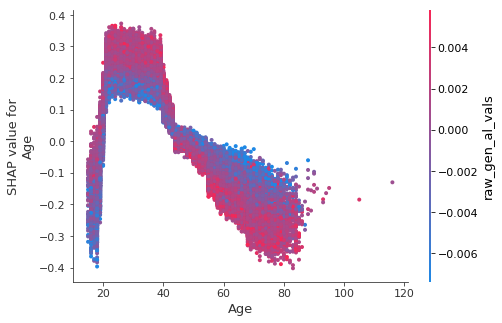

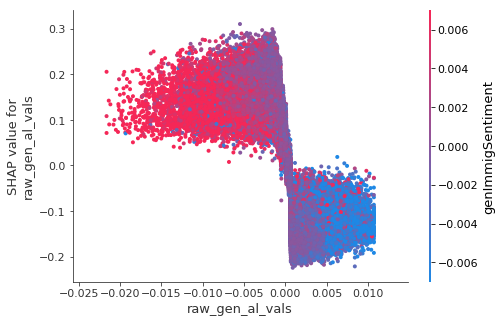

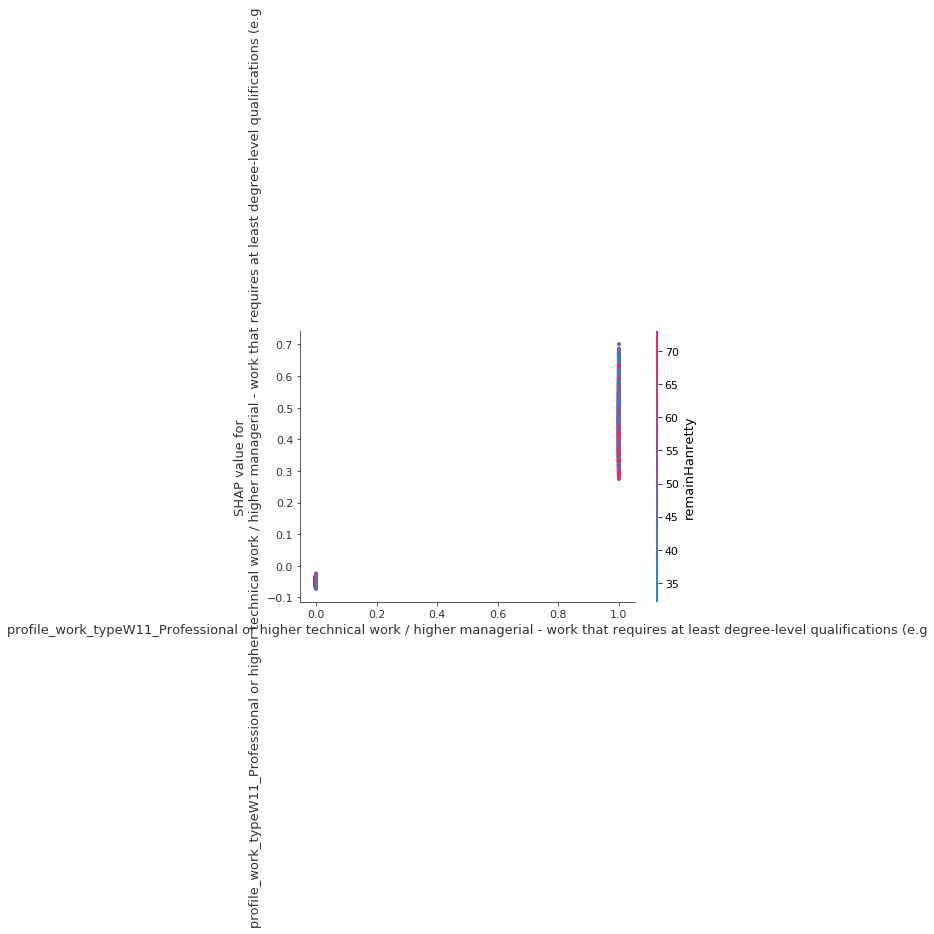

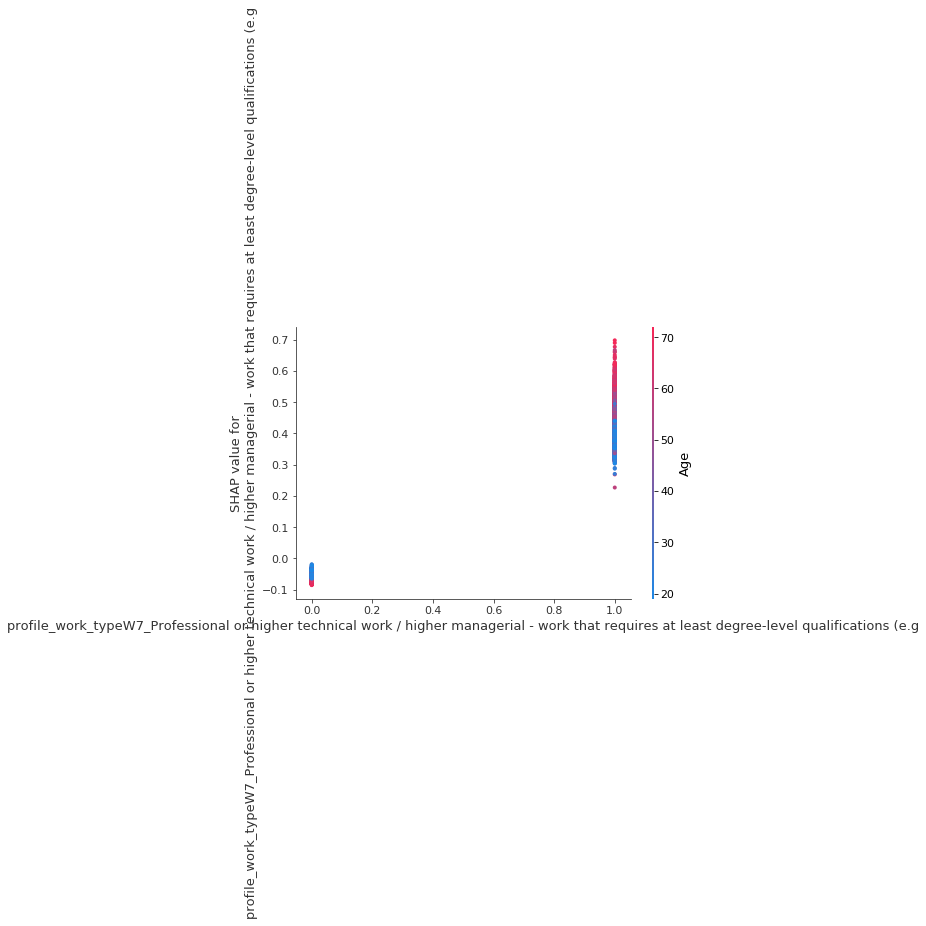

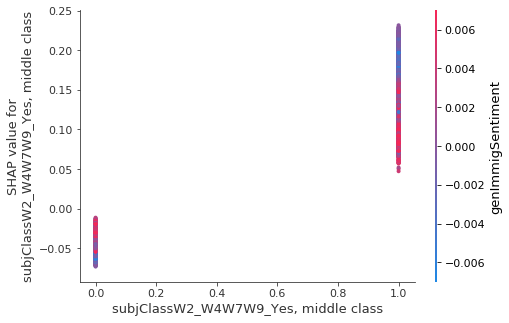

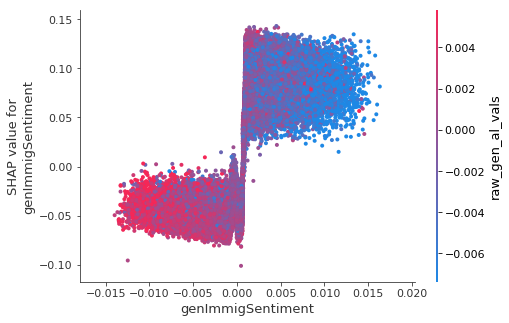

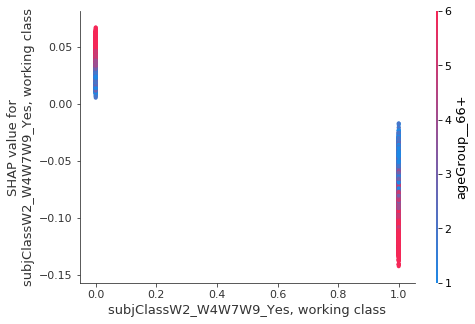

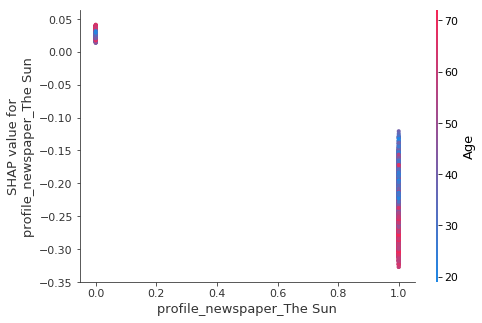

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x00000000165B2B00>>
Traceback (most recent call last):
  File "C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


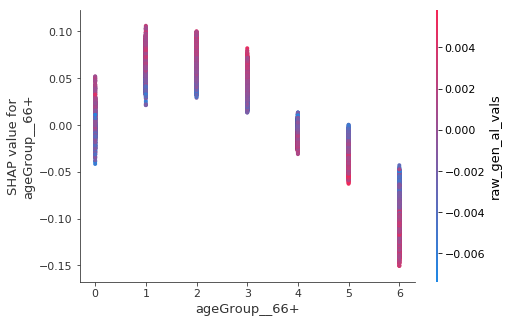

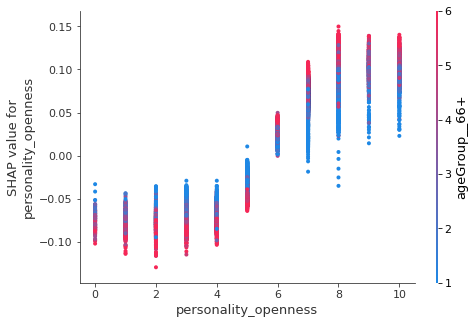

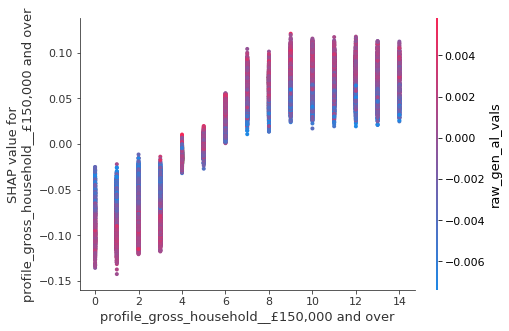

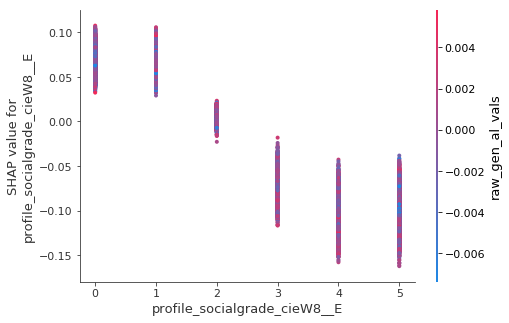

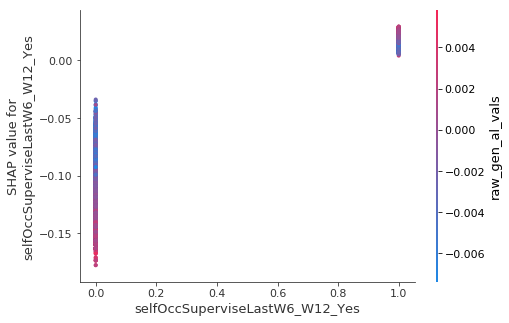

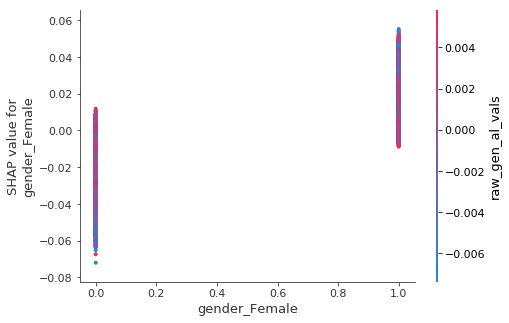

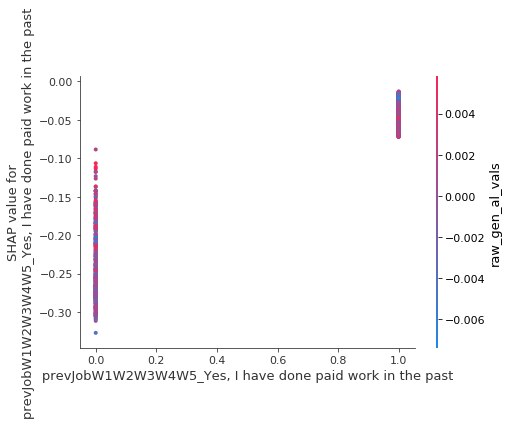

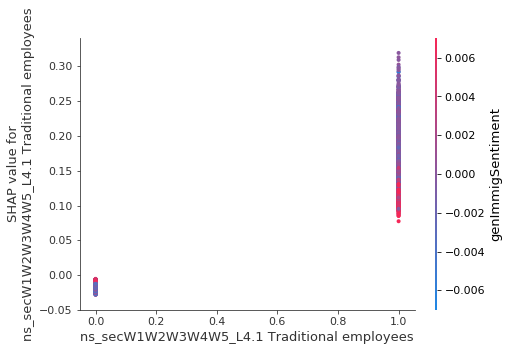

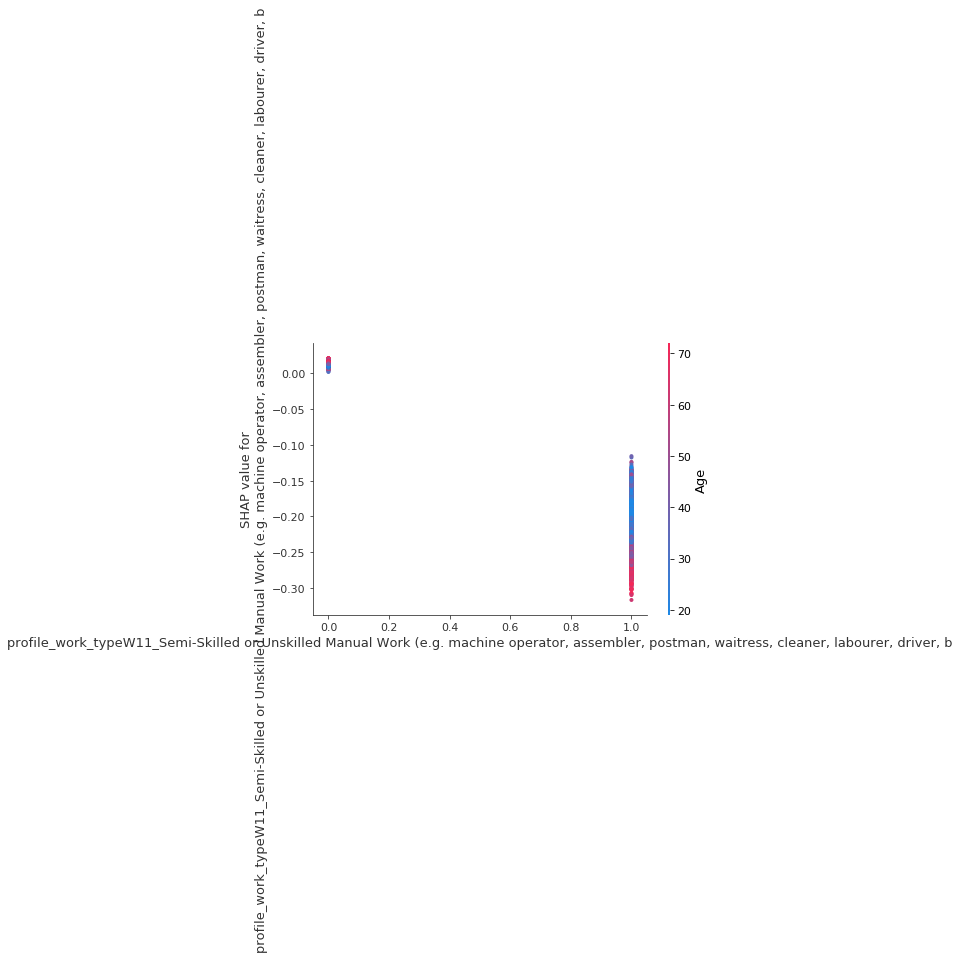

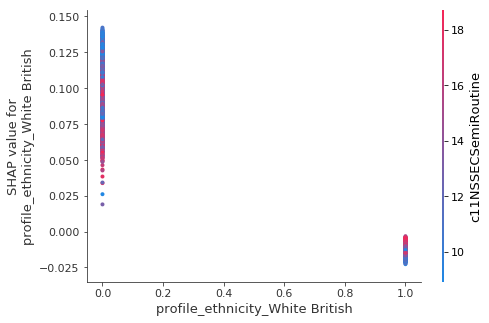

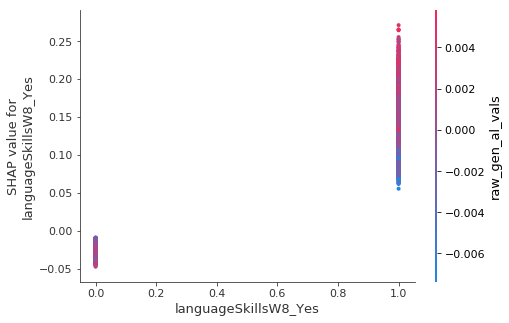

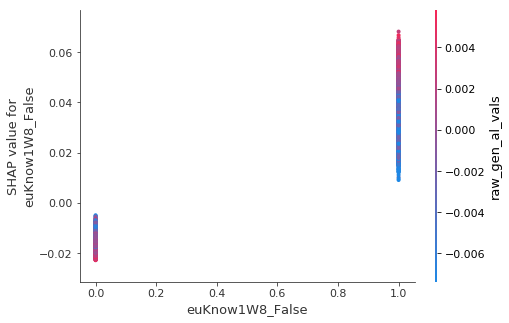

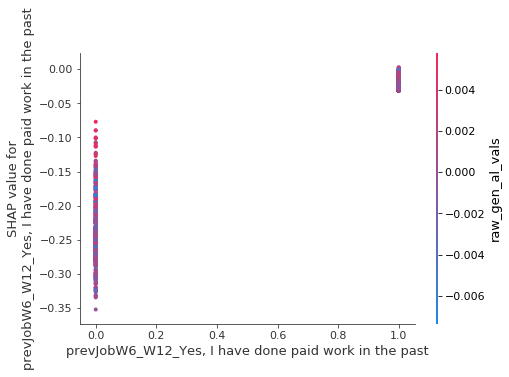

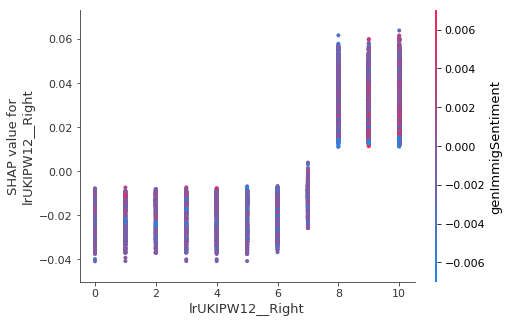

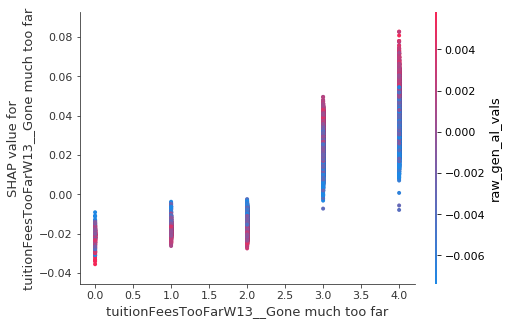

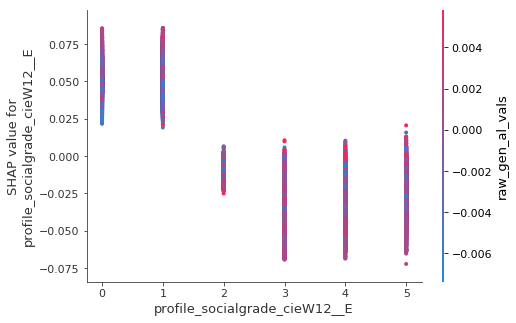

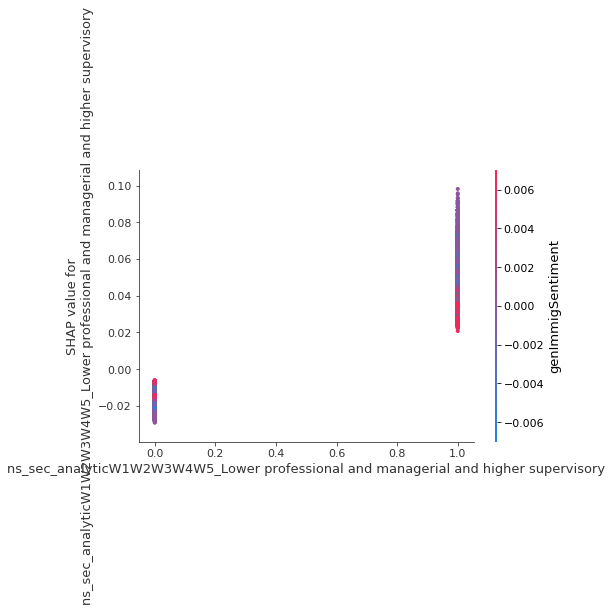

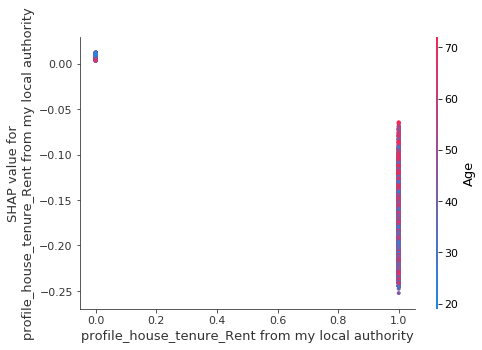

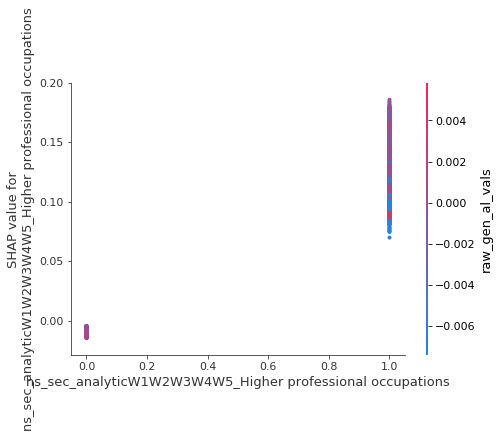

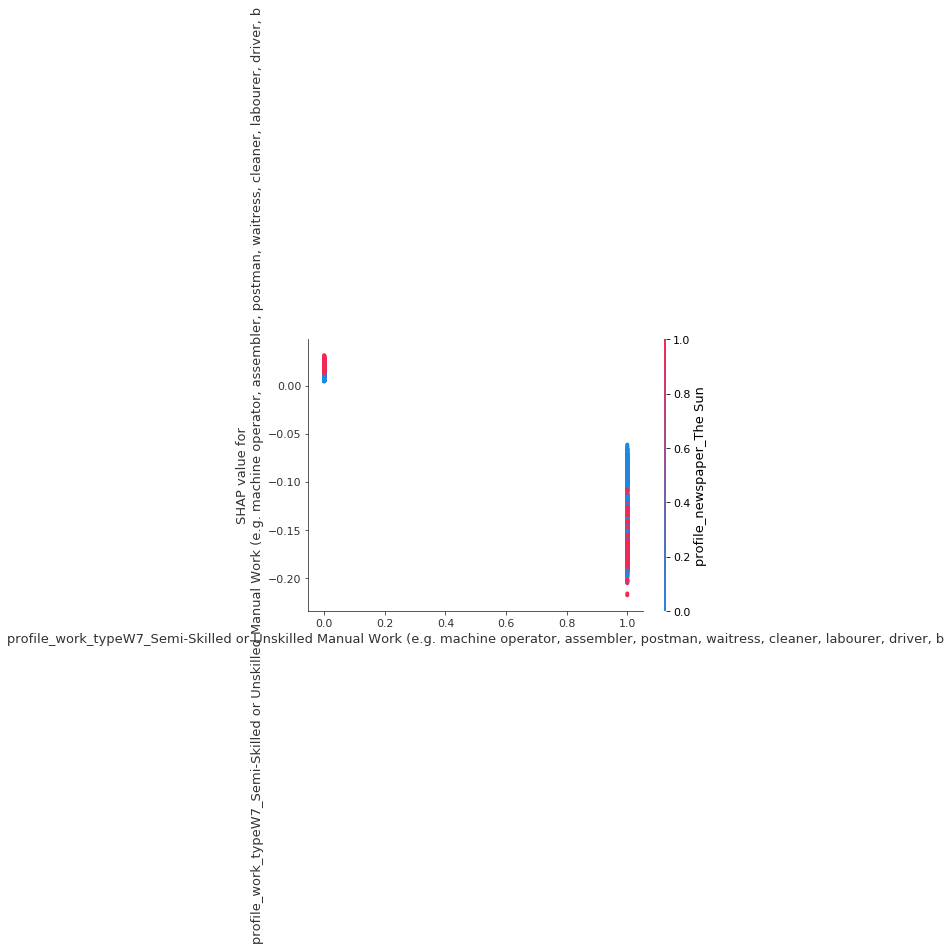

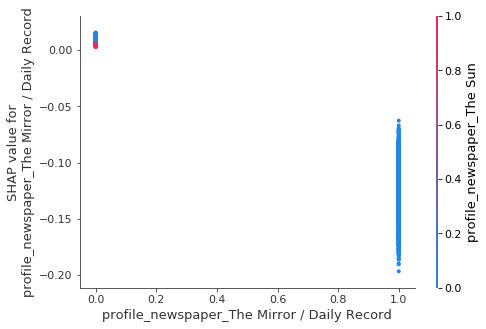

In [ ]:
##################
count = 0
for name in train.columns[inds[::-1]]:
    fig = plt.figure(figsize = (16,10))    
    shap.dependence_plot(name, shap_values, train)
    short_name = name[0:30]
    fig.savefig(output_subfolder + "featureNo "+str(count) + " " + short_name.replace("/","_") + ".png", bbox_inches='tight')
    count = count + 1

In [ ]:
# education, profile_education_age, anyUni
# xt_std_lr, xt_std_al,lr_uniform,al_uniform, subjectHE

In [ ]:
# immigUKIPW8__Allow many more: high
# Who the fuck are these people?


In [59]:
output_subfolder = BES_output_folder + "xgboost&shap&completedata" + os.sep + target_var + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )


############################

alg = XGBRegressor(
 learning_rate =0.04,
 n_estimators= 500,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 njobs=3,
 seed=27)

#     alg = XGBRegressor(
#      learning_rate =0.04,
#      n_estimators= 500,
#      max_depth=7,
#      min_child_weight=7,
#      gamma=.36,
#      subsample=0.35,
#      colsample_bytree=0.94,
#      colsample_bylevel=.85,
#      objective= 'reg:linear',
#      scale_pos_weight=1.0,
#      reg_alpha=0,
#      reg_lambda=1,
#      njobs=4,
#      seed=27)    

# {'colsample_bylevel': 0.85,
#  'colsample_bytree': 0.9406878704353334,
#  'gamma': 0.3602431963104453,
#  'max_depth': 7,
#  'min_child_weight': 7,
#  'subsample': 0.35}    


# split data into train and test sets
# fit, validate and find overfitting limit
seed = 7
test_size = 0.33
if not all_waves:
    X_train, X_test, y_train, y_test = train_test_split(pd.concat([train,sample_weights],axis=1), target, test_size=test_size,
                                                        random_state=seed, stratify=round(target))
else:
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=test_size,
                                                        random_state=seed, stratify=round(target))



eval_set = [(X_test, y_test)]



if not all_waves: #weights
    sample_weight = X_train[weight_var].values
    sample_weight_eval_set = X_test[weight_var].values
    X_train.drop(weight_var, axis=1, inplace=True)
    X_test.drop(weight_var, axis=1, inplace=True)        
    alg.fit(X_train, y_train, eval_metric='rmse', 
            early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
            verbose=True, sample_weight= sample_weight)
else: #noweights
    alg.fit(X_train, y_train, eval_metric='rmse', 
            early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
            verbose=True)        

# make predictions for test data
predictions = alg.predict(X_test)

# evaluate predictions
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
EV = explained_variance_score(y_test, predictions)
R2 = r2_score(y_test, predictions)

print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
alg.set_params(n_estimators=alg.best_iteration)

####################################
# fit to full dataset at non-overfitting level
if not all_waves: #weights
    alg.fit(train, target, verbose=True, sample_weight= sample_weights)
else:
    alg.fit(train, target, verbose=True)




shap_values = shap.TreeExplainer(alg).shap_values(train);


#################################
threshold = .1
min_features = 30
global_shap_vals = np.abs(shap_values).mean(0)[:-1]
n_top_features = sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold)
if n_top_features <min_features:
    n_top_features = min_features



##########################

inds = np.argsort(global_shap_vals)[-n_top_features:]

y_pos = np.arange(n_top_features)
plt.figure(figsize=(16,10))
plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
plt.yticks(y_pos, train.columns[inds])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("mean SHAP value magnitude (change in log odds)")
plt.gcf().set_size_inches(6, 4.5)

plt.savefig(output_subfolder + "mean_impact" + ".png", bbox_inches='tight')

plt.show()

####################
fig = plt.figure()
shap.summary_plot(shap_values, train, max_display=n_top_features, plot_type='dot');
fig.savefig(output_subfolder + "summary_plot" + ".png", bbox_inches='tight')



##################
count = 0
for name in train.columns[inds[::-1]]:
    fig = plt.figure(figsize = (16,10))    
    shap.dependence_plot(name, shap_values, train)
    fig.savefig(output_subfolder + "featureNo "+str(count) + " " + name.replace("/","_") + ".png", bbox_inches='tight')
    count = count + 1

ValueError: Found input variables with inconsistent numbers of samples: [68625, 64176]

In [ ]:
train[mask].shape

In [ ]:
# Why do people who vote Labour not pick Corbyn as bestPM?
# W8
# likeCorbyn/disliking Cameron
# euID7W7 - => -
# immigUKIPW8 + => +
# likeGove + => +

In [38]:
gc.collect()

32783

In [37]:
train.shape

(64176, 10281)

In [31]:
sample_weights.shape

(64176,)

In [32]:
gc.collect()

14

In [24]:
sample_weights = pd.DataFrame(np.ones(target[mask].shape))[0]

In [30]:
variables = pd.DataFrame.from_dict({key:sys.getsizeof(value) for (key,value) in locals().items()},orient='index')
variables.sort_values(by=0,ascending=False)
#     print(var, sys.getsizeof(obj))

0
train                       5272250952
immigDiff                    133956024
_23                            4392104
___                            4392104
pan_dataset_values             4392104
mask                           3239089
immig                          2745024
BES_census_data                2091696
target                         1026840
sample_weights                  513512
new_old_col_names               295008
predictions                      84812
BES_file_manifest                38332
rcParams                          9336
variables                         8833
_12                               8833
_i18                              3502
_i20                              3502
_i16                              3500
_i28                              2004
_ii                               2004
XGBRegressor                      2000
manifest                          1707
census_vars                       1672
LinearSegmentedColormap           1464
_i7                               1442
_i22                              1400
_i8                               1336
_i4                               1231
LinearDiscriminantAnalysis        1056
...                                ...
get_ipython                         64
stub_drop_list                      64
_i25                                62
encoding                            59
var_stub                            58
_i24                                57
__name__                            57
quit                                56
fig                                 56
alg                                 56
exit                                56
_20                                 56
_24                                 55
__                                  55
R2                                  32
MSE                                 32
MAE                                 32
EV                                  32
min_features                        28
count                               28
seed                                28
n_top_features                      28
all_waves                           28
num                                 28
threshold                           24
test_size                           24
skip                                24
__spec__                            16
__loader__                          16
__package__                         16

[172 rows x 1 columns]

In [41]:
var_zero_cols = BES_reduced_with_na.columns[BES_reduced_with_na.var() == 0]

In [42]:
var_zero_cols

Index(['partyContactGrnW11__No', 'partyContactGrnW12__No'], dtype='object')

In [45]:
missing_vals = BES_reduced_with_na.isnull().sum()/BES_reduced_with_na.shape[0]

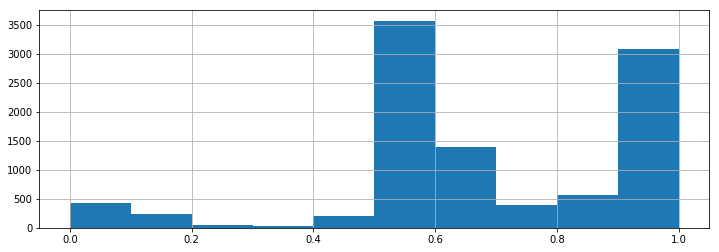

In [47]:
missing_vals.hist()

In [15]:
[x for x in BES_Panel.columns if "thatcher" in x]
#'blairGoodW1'
#'thatcherGoodW1'

['thatcherGoodW1']

In [ ]:
# divide up by past vote, ec left right, soc lib con, Remain Leave

In [51]:
[x for x in BES_reduced_with_na.columns if "blair" in x.lower()]

#'blairGoodW1_Good for Britain'
#'thatcherGoodW1_Good for Britain'

['likeBlairW11__Strongly like', 'blairGoodW1_Good for Britain']

In [45]:
import seaborn as sns
granularity = 5
g = sns.factorplot(x=BES_reduced_with_na["blairGoodW1_Good for Britain"],
                y=pd.qcut(pan_dataset_values["raw_gen_al_vals"],granularity, labels=range(1,granularity+1)),
                hue=pd.qcut(pan_dataset_values["raw_gen_lr_vals"],granularity, labels=range(1,granularity+1)) )

TypeError: object of type 'NoneType' has no len()

In [38]:
gc.collect()

306

In [42]:
BES_reduced_with_na["blairGoodW1_Good for Britain"].value_counts()

0.0    15141
1.0     7195
Name: blairGoodW1_Good for Britain, dtype: int64

In [47]:
blair_corr = BES_reduced_with_na.corrwith(BES_reduced_with_na["blairGoodW1_Good for Britain"])

In [50]:
blair_corr.dropna().sort_values()

tyneFirstW12_Stewart Hay (Conservative)                   -0.563602
preferLabMajorityW5__Ranked fifth                         -0.406932
preferLabMajorityW4__Ranked fifth                         -0.405445
westFirstW12_Tim Bowles (Conservative)                    -0.383300
responsibleDebtLabourW1_Yes                               -0.377356
responsibleDebtLabourW2_Yes                               -0.366837
wmidsFirstW12_Andy Street (Conservative)                  -0.358295
responsibleDebtLabourW3_Yes                               -0.355923
changeImmigLabW3__Getting a lot higher                    -0.346485
changeCostLiveLabW3__Getting a lot higher                 -0.341291
responsibleDebtLabourW4_Yes                               -0.340528
selfNumEmployeesW6_W12__500 or more employees             -0.333333
profile_past_vote_2005_Conservative Party                 -0.327741
changeCostLiveLabW2__Getting a lot higher                 -0.322823
changeImmigLabW1__Getting a lot higher          

In [83]:
%time
ques = "blairGoodW1_Good for Britain"
min_vales = 100
mask = BES_reduced_with_na[ques].notnull()
min_coverage = (BES_reduced_with_na[mask].notnull().sum()>min_vales)
min_cov_vars = BES_reduced_with_na.columns[min_coverage]
blair_corr_W11 = BES_reduced_with_na[min_cov_vars][mask].corrwith(BES_reduced_with_na[ques][mask], drop=True)
blair_corr_W11.dropna().sort_values()

Wall time: 0 ns


preferLabMajorityW5__Ranked fifth                            -0.406932
preferLabMajorityW4__Ranked fifth                            -0.405445
responsibleDebtLabourW1_Yes                                  -0.377356
responsibleDebtLabourW2_Yes                                  -0.366837
wmidsFirstW12_Andy Street (Conservative)                     -0.358295
responsibleDebtLabourW3_Yes                                  -0.355923
changeImmigLabW3__Getting a lot higher                       -0.346485
changeCostLiveLabW3__Getting a lot higher                    -0.341291
responsibleDebtLabourW4_Yes                                  -0.340528
profile_past_vote_2005_Conservative Party                    -0.327741
changeCostLiveLabW2__Getting a lot higher                    -0.322823
changeImmigLabW1__Getting a lot higher                       -0.321955
changeImmigLabW2__Getting a lot higher                       -0.320507
changeImmigLabW4__Getting a lot higher                       -0.319451
change

In [82]:
%time
ques = 'likeBlairW11__Strongly like'
min_vales = 100
mask = BES_reduced_with_na[ques].notnull()
min_coverage = (BES_reduced_with_na[mask].notnull().sum()>min_vales)
min_cov_vars = BES_reduced_with_na.columns[min_coverage]
blair_corr_W11 = BES_reduced_with_na[min_cov_vars][mask].corrwith(BES_reduced_with_na[ques][mask], drop=True)
blair_corr_W11.dropna().sort_values()

Wall time: 1 ms


partyPreferredW13_United Kingdom Independence Party (UKIP)   -0.396587
preferLabMajorityW5__Ranked fifth                            -0.380185
euRefVoteUnsqueezeW7_Leave the EU                            -0.378601
euIDW7_The leave side                                        -0.378251
euExpRefW7_To leave the European Union                       -0.375939
euRefVoteUnsqueezeW8_Leave the EU                            -0.371488
preferLabMajorityW4__Ranked fifth                            -0.368070
euRefVoteW1_Leave the EU                                     -0.368069
euRefVoteW7_Leave the EU                                     -0.366876
euRefVoteW3_Leave the EU                                     -0.362402
euIDW12_The leave side                                       -0.360418
euRefVoteW2_Leave the EU                                     -0.358661
euRefVote2W8_Leave the EU                                    -0.358367
euIDW8_The leave side                                        -0.357998
euRefV

In [84]:
%time
ques = 'likeCorbynW11__Strongly like'
min_vales = 100
mask = BES_reduced_with_na[ques].notnull()
min_coverage = (BES_reduced_with_na[mask].notnull().sum()>min_vales)
min_cov_vars = BES_reduced_with_na.columns[min_coverage]
corbyn_corr_W11 = BES_reduced_with_na[min_cov_vars][mask].corrwith(BES_reduced_with_na[ques][mask], drop=True)
corbyn_corr_W11.dropna().sort_values()

Wall time: 0 ns


generalElectionVoteUnsqueezeW11_Conservative     -0.622313
generalElectionVoteUnsqueezeW12_Conservative     -0.615628
reaskVoteW12_Conservative                        -0.591406
leftRightW13__Right                              -0.586335
leftRightW12__Right                              -0.581908
leftRightW11__Right                              -0.580977
generalElectionVoteW11_Conservative              -0.569006
ptvConW12__Very likely                           -0.568803
teesFirstW12_Ben Houchen (Conservative)          -0.567836
generalElectionVoteW12_Conservative              -0.567328
ptvConW11__Very likely                           -0.564847
leftRightW10__Right                              -0.560602
liverpoolFirstW12_Tony Caldeira (Conservative)   -0.560150
leftRightW9__Right                               -0.556320
likeConW11__Strongly like                        -0.556191
generalElectionVoteW13_Conservative              -0.556128
ptvConW13__Very likely                           -0.5544